In [ ]:
!pip install -q flwr[simulation]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.1/465.1 kB 14.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import copy
import os
import glob
from typing import List, Tuple, Dict, Optional, Union
from collections import OrderedDict

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, BatchNormalization, Attention, MaxPooling1D, Flatten, Reshape,  Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import flwr as fl
from flwr.server.strategy import FedAvg
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.simulation import run_simulation
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common.logger import log
from flwr.common import parameters_to_ndarrays, ndarrays_to_parameters, NDArrays, Scalar, Context, Metrics, Parameters

import random
from prophet import Prophet
from logging import INFO
import pickle
from pathlib import Path
from numpy.linalg import norm

/usr/local/lib/python3.10/dist-packages/holidays/__init__.py:32: FutureIncompatibilityWarning: 

This is a future version incompatibility warning from Python Holidays library v0.56
to inform you about an upcoming change in our API versioning strategy that may affect your
project's dependencies. Starting from version 1.0 onwards, we will be following a loose form of
Semantic Versioning (SemVer, https://semver.org) to provide clearer communication regarding any
potential breaking changes.

This means that while we strive to maintain backward compatibility, there might be occasional
updates that introduce breaking changes to our API. To ensure the stability of your projects,
we highly recommend pinning the version of our API that you rely on. You can pin your current
holidays v0.x dependency (e.g., holidays==0.56) or limit it (e.g., holidays<1.0) in order to
avoid potentially unwanted upgrade to the version 1.0 when it's released (ETA 2024Q4 - 2025Q1).

If you have any questions or concer

In [ ]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GPU is available


## Data Preprocessing

###Functions

In [ ]:
def MinProcessing(df, feature, min_value):
    """
    Suppress values below min_value and interpolate missing ones.
    """
    df_min = df.copy()
    df_min.loc[df_min[feature] < min_value, feature] = np.nan
    df_min[feature] = df_min[feature].interpolate()
    return df_min


def MaxProcessing(df, feature, max_value):
    """
    Suppress values above max_value and interpolate missing ones.
    """
    df_max = df.copy()
    df_max.loc[df_max[feature] > max_value, feature] = np.nan
    df_max[feature] = df_max[feature].interpolate()
    return df_max

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###Datasets Soil Moisture

In [ ]:
def watering(df, feature, threshold, merge_size=20):
    """
    Detect peaks in the derivative of a feature, mark them as 1 in 'Watered', and merge close peaks.
    """
    # Copy the DataFrame and compute the gradient of the feature
    df_water = df.copy()
    df_water['Soil Hum Derivative'] = np.gradient(df_water[feature])
    derivative = df_water['Soil Hum Derivative'].values

    # Find indices where the derivative exceeds the threshold
    indices = np.where(derivative > threshold)[0]

    # Detect separate peaks
    peaks = []
    start = indices[0]
    for i in range(1, len(indices)):
        if indices[i] != indices[i-1] + 1:
            peaks.append((start, indices[i-1]))
            start = indices[i]
    peaks.append((start, indices[-1]))

    # Merge peaks that are close together
    merged_peaks = []
    merged_start, merged_end = peaks[0]
    for current_start, current_end in peaks[1:]:
        if current_start - merged_end <= merge_size:
            merged_end = current_end
        else:
            merged_peaks.append((merged_start, merged_end))
            merged_start, merged_end = current_start, current_end
    merged_peaks.append((merged_start, merged_end))

    # Mark the detected peaks in the 'Watered' column
    df_water['Watered'] = 0
    for start, end in merged_peaks:
        df_water.loc[start:end+1, 'Watered'] = 1

    return df_water, merged_peaks

Row's number 2900


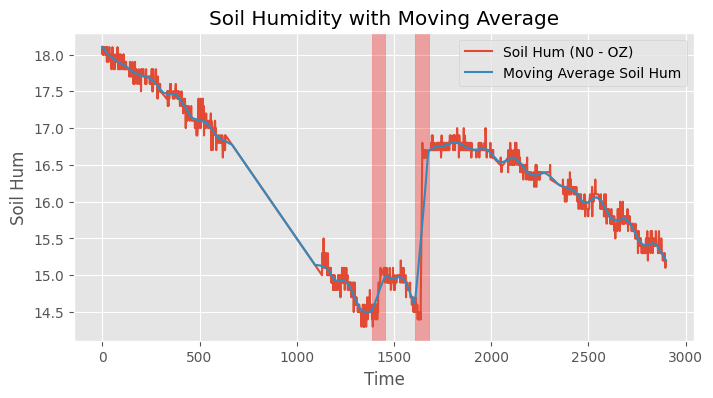

In [ ]:
df_N0OZ_later = pd.read_csv('N0OZ_later.csv')
window_size = 70

# Convert 'Time' column to datetime
df_N0OZ_later['Time'] = pd.to_datetime(df_N0OZ_later['Time'], unit='ms')

# Process and clean data
df_N0OZ_later = MinProcessing(df_N0OZ_later, 'Soil Hum (N0 - OZ)', 10)
df_N0OZ_later = df_N0OZ_later.dropna(subset=['Soil Hum (N0 - OZ)'])

# Calculate moving average and remove NaN values
df_N0OZ_later['Moving Average Soil Hum'] = df_N0OZ_later['Soil Hum (N0 - OZ)'].rolling(window=window_size, center=True).mean()
df_N0OZ_later = df_N0OZ_later.dropna(subset=['Moving Average Soil Hum'])

# Limit dataset and reset index
df_N0OZ_later = df_N0OZ_later.iloc[:2900].reset_index(drop=True)

# Detect watering events and plot them
df_N0OZ_later, peaks = watering(df_N0OZ_later, 'Moving Average Soil Hum', 0.005)
for start, end in peaks:
    plt.axvspan(start, end, color='red', alpha=0.3)

# Display results
print(f"Row's number {len(df_N0OZ_later)}")
plt.plot(np.arange(len(df_N0OZ_later)), df_N0OZ_later['Soil Hum (N0 - OZ)'], label='Soil Hum (N0 - OZ)')
plt.plot(np.arange(len(df_N0OZ_later)), df_N0OZ_later['Moving Average Soil Hum'], label='Moving Average Soil Hum')
plt.xlabel('Time')
plt.ylabel('Soil Hum')
plt.title('Soil Humidity with Moving Average')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Row's number 2650


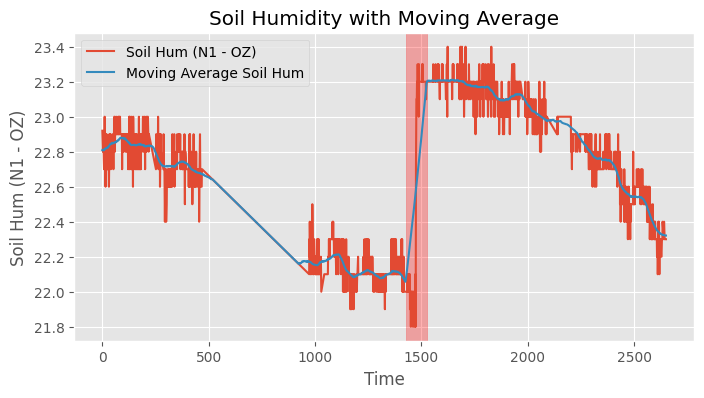

In [ ]:
df_N1OZ_later = pd.read_csv('N1OZ_later.csv')
window_size = 100  # Moving average window size

df_N1OZ_later['Time'] = pd.to_datetime(df_N1OZ_later['Time'], unit='ms')
df_N1OZ_later = MinProcessing(df_N1OZ_later, 'Soil Hum (N1 - OZ)', 10)
df_N1OZ_later = df_N1OZ_later.dropna(subset=['Soil Hum (N1 - OZ)'])

# Calculate and clean up the moving average
df_N1OZ_later['Moving Average Soil Hum'] = df_N1OZ_later['Soil Hum (N1 - OZ)'].rolling(window=window_size, center=True).mean()
df_N1OZ_later = df_N1OZ_later.dropna(subset=['Moving Average Soil Hum'])

# Select a specific data range
df_N1OZ_later = df_N1OZ_later.iloc[150:2800].reset_index(drop=True)

# Detect and mark watering events
df_N1OZ_later, peaks = watering(df_N1OZ_later, 'Moving Average Soil Hum', 0.005)
for start, end in peaks:
    plt.axvspan(start, end, color='red', alpha=0.3)

# Plot the data
print(f"Row's number {len(df_N1OZ_later)}")
plt.plot(np.arange(len(df_N1OZ_later)), df_N1OZ_later['Soil Hum (N1 - OZ)'], label='Soil Hum (N1 - OZ)')
plt.plot(np.arange(len(df_N1OZ_later)), df_N1OZ_later['Moving Average Soil Hum'], label='Moving Average Soil Hum')
plt.xlabel('Time')
plt.ylabel('Soil Hum (N1 - OZ)')
plt.title('Soil Humidity with Moving Average')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Row's number 2211


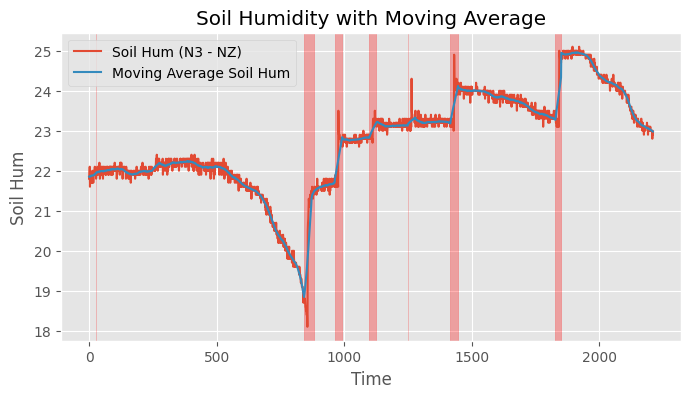

In [ ]:
df_N3NZ = pd.read_csv('N3NZ.csv')
window_size = 30

df_N3NZ['Time'] = pd.to_datetime(df_N3NZ['Time'], unit='ms')
df_N3NZ = df_N3NZ.dropna(subset=['Soil Hum (N3 - NZ)'])

# Calculate the moving average and clean up
df_N3NZ['Moving Average Soil Hum'] = df_N3NZ['Soil Hum (N3 - NZ)'].rolling(window=window_size, center=True).mean()
df_N3NZ = df_N3NZ.dropna(subset=['Moving Average Soil Hum'])

# Load and preprocess the later N3NZ dataset
df_N3NZ_later = pd.read_csv('N3NZ_later.csv')

df_N3NZ_later['Time'] = pd.to_datetime(df_N3NZ_later['Time'], unit='ms')
df_N3NZ_later = df_N3NZ_later.dropna(subset=['Soil Hum (N3 - NZ)'])

df_N3NZ_later['Moving Average Soil Hum'] = df_N3NZ_later['Soil Hum (N3 - NZ)'].rolling(window=window_size, center=True).mean()
df_N3NZ_later = df_N3NZ_later.dropna(subset=['Moving Average Soil Hum'])

# Reset index and select a specific data range
df_N3NZ_later = df_N3NZ_later.reset_index(drop=True)
df_N3NZ_later = df_N3NZ_later.iloc[:360]

# Concatenate the two datasets
df_N3NZ = pd.concat([df_N3NZ, df_N3NZ_later], axis=0).reset_index(drop=True)

# Detect and mark watering events
df_N3NZ, peaks = watering(df_N3NZ, 'Moving Average Soil Hum', 0.012)
for start, end in peaks:
    plt.axvspan(start, end, color='red', alpha=0.3)

# Plot the data
print(f"Row's number {len(df_N3NZ)}")
plt.plot(np.arange(len(df_N3NZ)), df_N3NZ['Soil Hum (N3 - NZ)'], label='Soil Hum (N3 - NZ)')
plt.plot(np.arange(len(df_N3NZ)), df_N3NZ['Moving Average Soil Hum'], label='Moving Average Soil Hum')
plt.xlabel('Time')
plt.ylabel('Soil Hum')
plt.title('Soil Humidity with Moving Average')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Row's number 1800


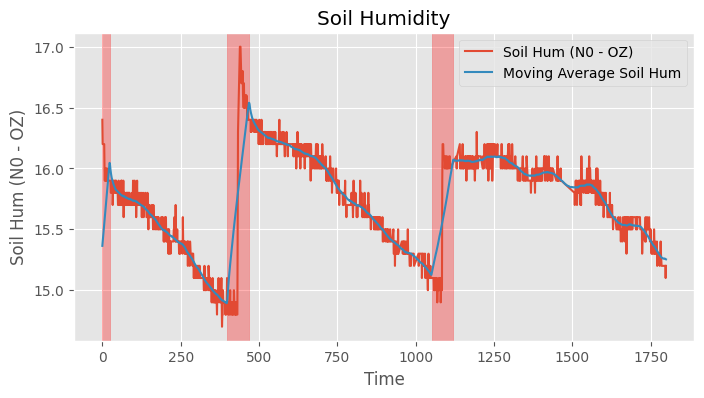

In [ ]:
df_N0OZ = pd.read_csv('N0OZ.csv')
window_size = 70

df_N0OZ['Time'] = pd.to_datetime(df_N0OZ['Time'], unit='ms')

# Apply Min and Max processing
df_N0OZ = MinProcessing(df_N0OZ, 'Soil Hum (N0 - OZ)', 10)
df_N0OZ = MaxProcessing(df_N0OZ, 'Soil Hum (N0 - OZ)', 18)
df_N0OZ = df_N0OZ.dropna(subset=['Soil Hum (N0 - OZ)'])

# Calculate and clean up the moving average
df_N0OZ['Moving Average Soil Hum'] = df_N0OZ['Soil Hum (N0 - OZ)'].rolling(window=window_size, center=True).mean()
df_N0OZ = df_N0OZ.dropna(subset=['Moving Average Soil Hum'])

# Separate, process, and recombine parts of the dataset
df_N0OZ_before = df_N0OZ.iloc[:1000, :]
df_N0OZ_after = df_N0OZ.iloc[1000:, :]
df_N0OZ_before = MaxProcessing(df_N0OZ_before, 'Soil Hum (N0 - OZ)', 17)
df_N0OZ = pd.concat([df_N0OZ_before, df_N0OZ_after], axis=0)

# Focus on a specific data range
df_N0OZ = df_N0OZ.iloc[100:1900].reset_index(drop=True)

# Detect and mark watering events
df_N0OZ, peaks = watering(df_N0OZ, 'Moving Average Soil Hum', 0.01)
for start, end in peaks:
    plt.axvspan(start, end, color='red', alpha=0.3)

# Plot the data
print(f"Row's number {len(df_N0OZ)}")
plt.plot(np.arange(len(df_N0OZ['Time'])), df_N0OZ['Soil Hum (N0 - OZ)'], label='Soil Hum (N0 - OZ)')
plt.plot(np.arange(len(df_N0OZ['Time'])), df_N0OZ['Moving Average Soil Hum'], label='Moving Average Soil Hum')
plt.xlabel('Time')
plt.ylabel('Soil Hum (N0 - OZ)')
plt.title('Soil Humidity')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Row's number 1681


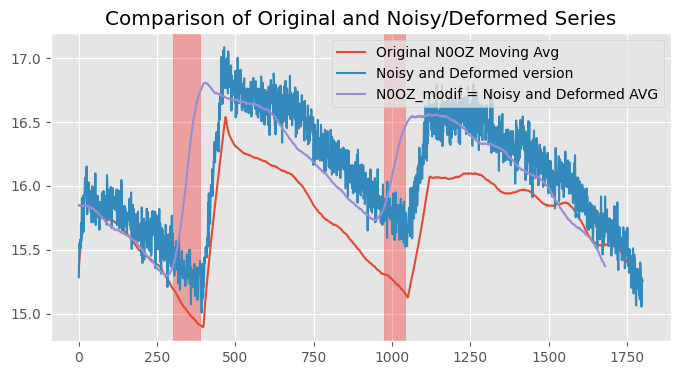

In [ ]:
serie = df_N0OZ['Moving Average Soil Hum']

# Add Gaussian noise to the series
noise = np.random.normal(0, 0.1, len(serie))
noisy_serie = serie + noise

# Deform the series with a sinusoidal pattern
deformed_serie = noisy_serie * (1 + 0.035 * np.sin(np.linspace(0, np.pi, len(noisy_serie))))

# Create a new DataFrame with the deformed series
df_N0OZ_modif = pd.DataFrame({
    'Soil Hum (N0 - OZ)': deformed_serie
})

# Calculate the moving average for the modified series
window_size = 70
df_N0OZ_modif['Moving Average Soil Hum'] = df_N0OZ_modif['Soil Hum (N0 - OZ)'].rolling(window=window_size, center=True).mean()

# Clean up and prepare the modified series
df_N0OZ_modif = df_N0OZ_modif.dropna(subset=['Moving Average Soil Hum'])
df_N0OZ_modif = df_N0OZ_modif.iloc[50:].reset_index(drop=True)

# Detect and mark watering events in the modified series
df_N0OZ_modif, peaks = watering(df_N0OZ_modif, 'Moving Average Soil Hum', 0.008)
for start, end in peaks:
    plt.axvspan(start, end, color='red', alpha=0.3)

# Plot the original, noisy/deformed, and modified series
print(f"Row's number {len(df_N0OZ_modif)}")
plt.plot(serie, label='Original N0OZ Moving Avg')
plt.plot(deformed_serie, label='Noisy and Deformed version')
plt.plot(df_N0OZ_modif['Moving Average Soil Hum'], label='N0OZ_modif = Noisy and Deformed AVG')
plt.legend()
plt.title('Comparison of Original and Noisy/Deformed Series')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Row's number 2571


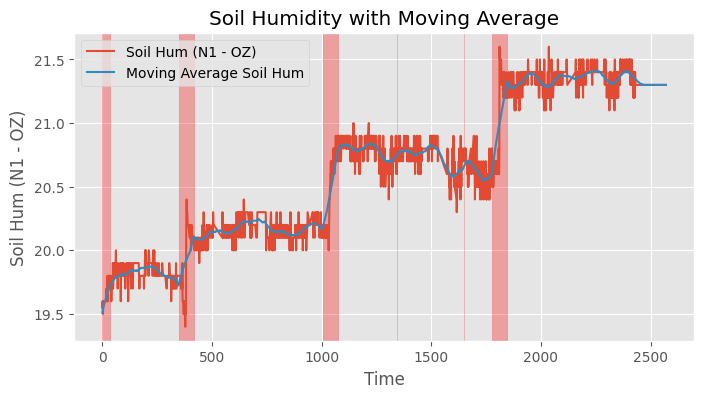

In [ ]:
df_N1OZ = pd.read_csv('N1OZ.csv')
window_size = 70

df_N1OZ['Time'] = pd.to_datetime(df_N1OZ['Time'], unit='ms')

# Apply minimum processing to clean the data
df_N1OZ = MinProcessing(df_N1OZ, 'Soil Hum (N1 - OZ)', 10)

# Remove rows with missing soil humidity data
df_N1OZ = df_N1OZ.dropna(subset=['Soil Hum (N1 - OZ)'])

# Calculate the moving average for soil humidity
df_N1OZ['Moving Average Soil Hum'] = df_N1OZ['Soil Hum (N1 - OZ)'].rolling(window=window_size, center=True).mean()

# Remove rows where the moving average could not be calculated
df_N1OZ = df_N1OZ.dropna(subset=['Moving Average Soil Hum'])

# Focus on a specific range of data
df_N1OZ = df_N1OZ.iloc[150:].reset_index(drop=True)

# Detect and mark watering events
df_N1OZ, peaks = watering(df_N1OZ, 'Moving Average Soil Hum', 0.005)
for start, end in peaks:
    plt.axvspan(start, end, color='red', alpha=0.3)

print(f"Row's number {len(df_N1OZ)}")

# Plot the soil humidity and its moving average
plt.plot(np.arange(len(df_N1OZ)), df_N1OZ['Soil Hum (N1 - OZ)'], label='Soil Hum (N1 - OZ)')
plt.plot(np.arange(len(df_N1OZ)), df_N1OZ['Moving Average Soil Hum'], label='Moving Average Soil Hum')
plt.xlabel('Time')
plt.ylabel('Soil Hum (N1 - OZ)')
plt.title('Soil Humidity with Moving Average')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Row's number 1850


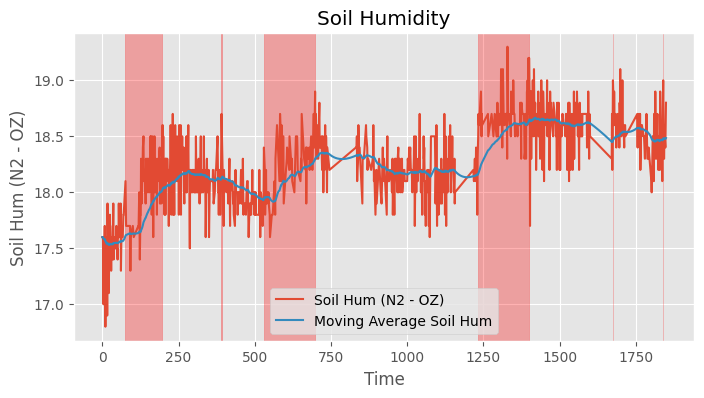

In [ ]:
df_N2OZ = pd.read_csv('N2OZ.csv')
window_size = 120

df_N2OZ['Time'] = pd.to_datetime(df_N2OZ['Time'], unit='ms')

# Apply Min and Max processing to clean the data
df_N2OZ = MinProcessing(df_N2OZ, 'Soil Hum (N2 - OZ)', 16)
df_N2OZ = MaxProcessing(df_N2OZ, 'Soil Hum (N2 - OZ)', 22)
df_N2OZ = df_N2OZ.dropna(subset=['Soil Hum (N2 - OZ)'])

# Calculate the exponentially weighted moving average for soil humidity
df_N2OZ['Moving Average Soil Hum'] = df_N2OZ['Soil Hum (N2 - OZ)'].ewm(span=window_size, adjust=False).mean()
df_N2OZ = df_N2OZ.dropna(subset=['Moving Average Soil Hum'])

# Focus on a specific data range
df_N2OZ = df_N2OZ.iloc[:1850].reset_index(drop=True)

# Detect and mark watering events with a custom merge size
df_N2OZ, peaks = watering(df_N2OZ, 'Moving Average Soil Hum', 0.007, merge_size=100)
for start, end in peaks:
    plt.axvspan(start, end, color='red', alpha=0.3)

# Print the number of rows in the final dataset
print(f"Row's number {len(df_N2OZ)}")

# Plot the soil humidity and its moving average
plt.plot(np.arange(len(df_N2OZ)), df_N2OZ['Soil Hum (N2 - OZ)'], label='Soil Hum (N2 - OZ)')
plt.plot(np.arange(len(df_N2OZ)), df_N2OZ['Moving Average Soil Hum'], label='Moving Average Soil Hum')
plt.xlabel('Time')
plt.ylabel('Soil Hum (N2 - OZ)')
plt.title('Soil Humidity')
plt.legend()
plt.show()


###Dataset Signal


Row's number 2255


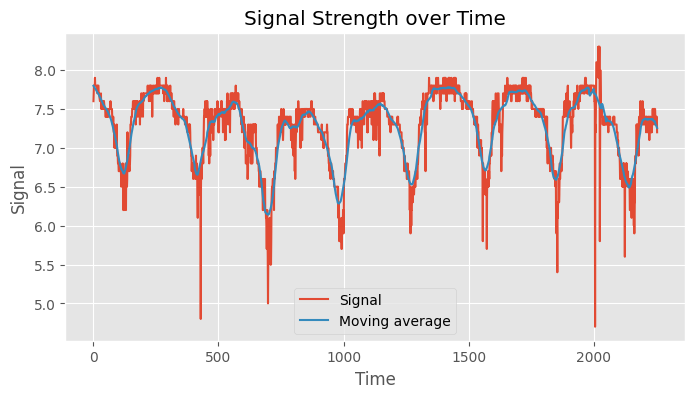

In [ ]:
J_T1_A = pd.read_csv('J_T1_A.csv')
J_T1_A['Time'] = pd.to_datetime(J_T1_A['Time'], dayfirst=True)
window_size = 50  # Set the window size for the moving average

# Apply MinProcessing to clean the signal data
J_T1_A = MinProcessing(J_T1_A, ' Avg', 2)

# Calculate the moving average of the signal
J_T1_A['Moving Avg'] = J_T1_A[' Avg'].rolling(window=window_size, center=True).mean()

# Remove rows where the moving average could not be calculated
J_T1_A = J_T1_A.dropna(subset=['Moving Avg']).reset_index(drop=True)

# Print the number of rows in the processed dataset
print(f"Row's number {len(J_T1_A)}")

# Plot the original signal and its moving average
plt.plot(np.arange(len(J_T1_A)), J_T1_A[' Avg'], label='Signal')
plt.plot(np.arange(len(J_T1_A)), J_T1_A['Moving Avg'], label='Moving average')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Signal Strength over Time')
plt.legend()
plt.show()


Row's number 2255


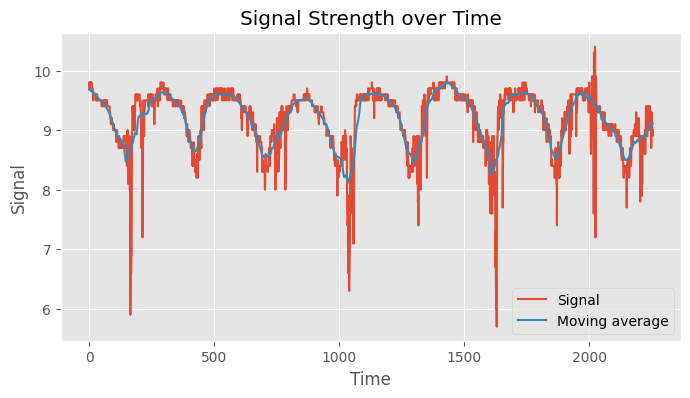

In [ ]:
J_T2_A = pd.read_csv('J_T2_A.csv')
J_T2_A['Time'] = pd.to_datetime(J_T2_A['Time'], dayfirst=True)
window_size = 50  # Set the window size for the moving average

# Apply MinProcessing to clean the signal data
J_T2_A = MinProcessing(J_T2_A, ' Avg', 2)

# Calculate the moving average of the signal
J_T2_A['Moving Avg'] = J_T2_A[' Avg'].rolling(window=window_size, center=True).mean()

# Remove rows where the moving average could not be calculated
J_T2_A = J_T2_A.dropna(subset=['Moving Avg']).reset_index(drop=True)

# Print the number of rows in the processed dataset
print(f"Row's number {len(J_T2_A)}")

# Plot the original signal and its moving average
plt.plot(np.arange(len(J_T2_A)), J_T2_A[' Avg'], label='Signal')
plt.plot(np.arange(len(J_T2_A)), J_T2_A['Moving Avg'], label='Moving average')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Signal Strength over Time')
plt.legend()
plt.show()

Row's number 1800


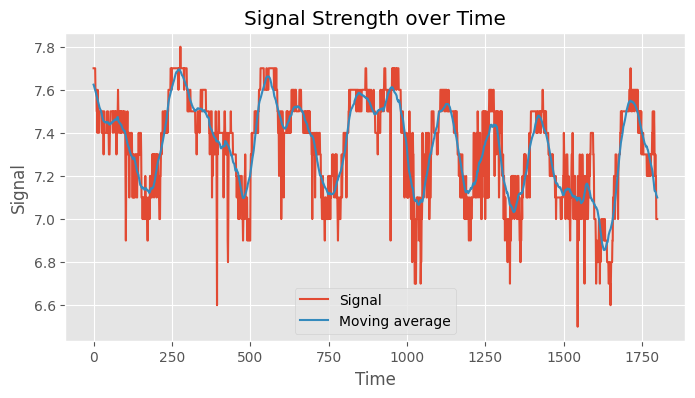

In [ ]:
J_T1_B = pd.read_csv('J_T1_B.csv')
J_T1_B['Time'] = pd.to_datetime(J_T1_B['Time'], dayfirst=True)
window_size = 50  # Set the window size for the moving average

# Apply MinProcessing to clean the signal data with a threshold of 6.4
J_T1_B = MinProcessing(J_T1_B, ' Avg', 6.4)

# Calculate the moving average of the signal
J_T1_B['Moving Avg'] = J_T1_B[' Avg'].rolling(window=window_size, center=True).mean()

# Remove rows where the moving average could not be calculated
J_T1_B = J_T1_B.dropna(subset=['Moving Avg'])

# Select the first 1800 rows for analysis
J_T1_B = J_T1_B.iloc[:1800].reset_index(drop=True)

# Print the number of rows in the processed dataset
print(f"Row's number {len(J_T1_B)}")

# Plot the original signal and its moving average
plt.plot(np.arange(len(J_T1_B)), J_T1_B[' Avg'], label='Signal')
plt.plot(np.arange(len(J_T1_B)), J_T1_B['Moving Avg'], label='Moving average')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Signal Strength over Time')
plt.legend()
plt.show()


<ipython-input-22-f29315d10096>:5: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  J_T2_B['Time'] = pd.to_datetime(J_T2_B['Time'], dayfirst=True)


Row's number 2255


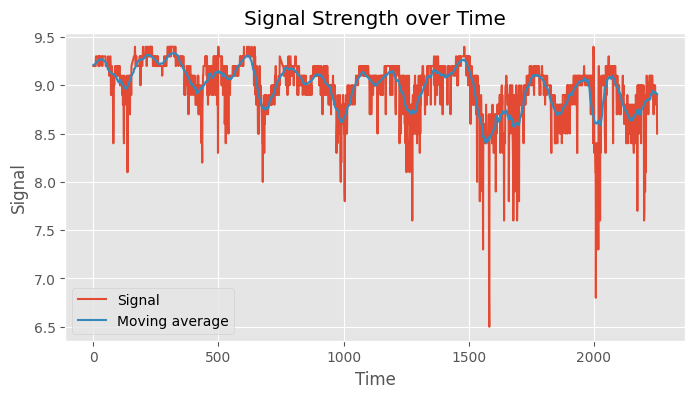

In [ ]:
# Load and preprocess the J_T2_B dataset, skipping the first row
J_T2_B = pd.read_csv('J_T2_B.csv', skiprows=1)

# Convert 'Time' column to datetime format with day-first notation
J_T2_B['Time'] = pd.to_datetime(J_T2_B['Time'], dayfirst=True)

# Set the window size for calculating the moving average
window_size = 50

# Apply minimum value processing to clean the data
J_T2_B = MinProcessing(J_T2_B, ' Avg', 6.4)

# Calculate the moving average of the ' Avg' column
J_T2_B['Moving Avg'] = J_T2_B[' Avg'].rolling(window=window_size, center=True).mean()

# Remove rows with missing values in 'Moving Avg'
J_T2_B = J_T2_B.dropna(subset=['Moving Avg']).reset_index(drop=True)

# Print the total number of rows after preprocessing
print(f"Row's number {len(J_T2_B)}")

# Plot the original signal and its moving average
plt.plot(np.arange(len(J_T2_B)), J_T2_B[' Avg'], label='Signal')
plt.plot(np.arange(len(J_T2_B)), J_T2_B['Moving Avg'], label='Moving average')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Signal Strength over Time')
plt.legend()
plt.show()


###Correlation Matrix

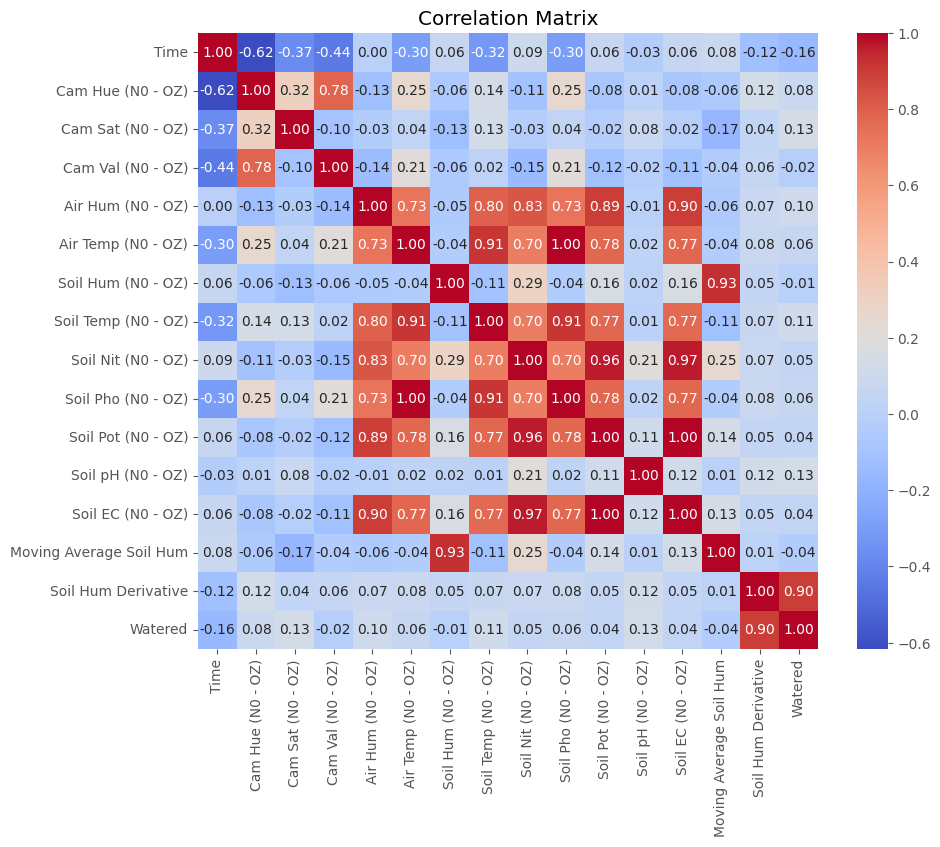

Most Correlated Soil Hum (N0 - OZ): ['Moving Average Soil Hum', 'Soil Nit (N0 - OZ)', 'Soil Pot (N0 - OZ)', 'Soil EC (N0 - OZ)', 'Time', 'Soil Hum Derivative', 'Soil pH (N0 - OZ)', 'Watered', 'Air Temp (N0 - OZ)', 'Soil Pho (N0 - OZ)', 'Air Hum (N0 - OZ)', 'Cam Val (N0 - OZ)', 'Cam Hue (N0 - OZ)', 'Soil Temp (N0 - OZ)', 'Cam Sat (N0 - OZ)']


In [ ]:
#Correlation MATRIX and most related features
df = df_N0OZ.copy() #Chose
target_feature = 'Soil Hum (N0 - OZ)' #Chose


correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

correlations = correlation_matrix[target_feature]

sorted_correlations = correlations.sort_values(ascending=False)
filtered_features = sorted_correlations.index.tolist()
filtered_features.remove(target_feature)

print(f"Most Correlated {target_feature}: {filtered_features}")


## Global functions


In [ ]:
def data_preparation(series, version, sequence_length, prediction_steps, train_size, val_size):
    """Prepare the data for training, validation, and testing based on the specified version."""

    if len(series) == 0:
        raise ValueError("The series is empty")  # Ensure the series is not empty

    # Calculate indices for splitting the series into training, validation, and test sets
    split_idx_train = int(train_size * len(series))
    split_idx_val = int((train_size + val_size) * len(series))

    # Split the series into training, validation, and test sets
    train_series = series[:split_idx_train].values
    val_series = series[split_idx_train:split_idx_val].values
    test_series = series[split_idx_val:].values

    scaler = MinMaxScaler(feature_range=(0, 1))

    # Scale the series based on the version type
    if version == 'features' or version == 'long_features':
        train_series_scaled = scaler.fit_transform(train_series)
        val_series_scaled = scaler.transform(val_series)
        test_series_scaled = scaler.transform(test_series)
    else:
        train_series_scaled = scaler.fit_transform(train_series.reshape(-1, 1))
        val_series_scaled = scaler.transform(val_series.reshape(-1, 1))
        test_series_scaled = scaler.transform(test_series.reshape(-1, 1))

    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    # Prepare sequences and targets for the 'long_features' version
    if version == 'long_features':
        for i in range(len(train_series_scaled) - sequence_length - prediction_steps + 1):
            X_train.append(train_series_scaled[i:i + sequence_length])
            y_train.append(train_series_scaled[i + sequence_length:i + sequence_length + prediction_steps])
        for i in range(len(val_series_scaled) - sequence_length - prediction_steps + 1):
            X_val.append(val_series_scaled[i:i + sequence_length])
            y_val.append(val_series_scaled[i + sequence_length:i + sequence_length + prediction_steps])
        for i in range(len(test_series_scaled) - sequence_length - prediction_steps + 1):
            X_test.append(test_series_scaled[i:i + sequence_length])
            y_test.append(test_series_scaled[i + sequence_length:i + sequence_length + prediction_steps])

    # Prepare sequences and targets for other versions
    else:
        for i in range(len(train_series_scaled) - sequence_length):
            X_train.append(train_series_scaled[i:i + sequence_length])
            y_train.append(train_series_scaled[i + sequence_length])
        for i in range(len(val_series_scaled) - sequence_length):
            X_val.append(val_series_scaled[i:i + sequence_length])
            y_val.append(val_series_scaled[i + sequence_length])
        for i in range(len(test_series_scaled) - sequence_length):
            X_test.append(test_series_scaled[i:i + sequence_length])
            y_test.append(test_series_scaled[i + sequence_length])

    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Adjust target shape based on the version type
    if version == 'features':
        y_train = y_train[:,0]
        y_val = y_val[:,0]
        y_test = y_test[:,0]

    if version == 'long_features':
        y_train = y_train[:,:,0]
        y_val = y_val[:,:,0]
        y_test = y_test[:,:,0]


    # Return the prepared datasets and the scaled series
    return X_train, y_train, X_val, y_val, X_test, y_test, train_series_scaled, val_series_scaled, test_series_scaled


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def build_lstm_model_conv(n_steps_in, num_layers, hidden_size, n_steps_out, input_shape):
    model = Sequential()

    # Input and initial Conv1D layer with causal padding
    model.add(Input(shape=(n_steps_in, input_shape)))
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, activation="relu", padding='causal'))

    # LSTM layers, with all but the last returning sequences
    for _ in range(num_layers - 1):
        model.add(LSTM(hidden_size, return_sequences=True))
    model.add(LSTM(hidden_size))

    # Dropout and Dense layers
    model.add(Dropout(0.2))
    model.add(Dense(hidden_size, activation="relu"))
    model.add(Dense(n_steps_out))

    return model


def build_model():
    model = build_lstm_model_conv(N_STEPS_IN, NUM_LAYERS, HIDDEN_SIZE, N_STEPS_OUT, INPUT_SHAPE)

    optimizer = Adam(clipvalue=5.0)
    loss = tf.keras.losses.MeanSquaredError()

    model.compile(optimizer=optimizer, loss=loss)

    return model

In [ ]:
def train_model(model, train_data, val_data, num_epochs, learning_rate, batch_size, val_training=True):
    X_train, y_train = train_data
    X_val, y_val = val_data

    # Check if a GPU is available for training, otherwise, use CPU
    if tf.config.list_physical_devices('GPU'):
        print("GPU is available. Training on GPU.")
    else:
        print("GPU is not available. Training on CPU.")

    # If validation during training is enabled, set up training with validation monioring
    if val_training:
        # Reduce learning rate when a metric has stopped improving
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0000001)
        # Stop training when a monitored metric has stopped improving
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        # Train the model with validation data
        history = model.fit(
            X_train, y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            verbose=1,
            validation_data=(X_val, y_val),
            callbacks=[reduce_lr, early_stopping]
        )
    else:
        # If no validation, use a simpler version of ReduceLROnPlateau and EarlyStopping without validation monitoring (for testing purposes, not used for now)
        reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=0.00001)
        early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
        # Train the model without validation data
        history = model.fit(
            X_train, y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=[reduce_lr, early_stopping]
        )

    # Return the trained model and the loss history on the training set (we could alos could return the loss on the validation set)
    return model, history.history['loss']



def evaluate_model(model, test_data, version):
    X_test, y_test = test_data

    # Generate predictions using the model
    predictions = model.predict(X_test, verbose=0)

    # Calculate evaluation metrics based on the version
    if version == 'long' or version == 'long_features':
        # For 'long' or 'long_features' version, compare only the first feature (the one of interest)
        mae = mean_absolute_error(y_test[:, 0], predictions[:, 0])
        mse = mean_squared_error(y_test[:, 0], predictions[:, 0])
        mape = mean_absolute_percentage_error(y_test[:, 0], predictions[:, 0])
    else:
        # For other versions, compare the entire output
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions)

    rmse = np.sqrt(mse)

    # Return the calculated metrics and predictions
    return mae, mse, rmse, mape, predictions


#Model Testing

##Model Definition for local model


In [ ]:
VERSION = 'long_features' #or 'classic' (but classic is not used)
DATASET = 'soil_moisture' #or = 'soil_moisture'

TRAIN_SIZE = 0.7
VAL_SIZE = 0.15

if DATASET == 'signal':
  FEATURES = ['Moving Avg']
else:
  FEATURES = ['Moving Average Soil Hum', 'Watered']

INPUT_SHAPE = 1
HIDDEN_SIZE = 128
NUM_LAYERS = 1
OUTPUT_SIZE = 1

N_STEPS_IN = 200
N_STEPS_OUT = 30

BATCH_SIZE = 64
LEARNING_RATE = 5e-3

NUM_EPOCHS = 30

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
if DATASET == 'soil_moisture':
  df_client = df_N1OZ_later[['Moving Average Soil Hum', 'Watered']]
else:
  df_client = J_T2_A['Moving Avg']

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, train_series_scaled, val_series_scaled, test_series_scaled = data_preparation(df_client, VERSION, N_STEPS_IN, N_STEPS_OUT, TRAIN_SIZE, VAL_SIZE)

model = build_model()
init_weights = model.get_weights()

model.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 200, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,454 (466.62 KB)

 Trainable params: 119,454 (466.62 KB)

 Non-trainable params: 0 (0.00 B)

##Training

###Learning Rate Tuning

In [ ]:
model.set_weights(init_weights)

START_LR = 1e-5
EPOCHS_LR = 20

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: START_LR * 10**(epoch / 20))

history = model.fit(X_train, y_train, epochs=EPOCHS_LR, callbacks=[lr_schedule])

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.4696 - learning_rate: 1.0000e-05
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.4433 - learning_rate: 1.1220e-05
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3863 - learning_rate: 1.2589e-05
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2849 - learning_rate: 1.4125e-05
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2519 - learning_rate: 1.5849e-05
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2441 - learning_rate: 1.7783e-05
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2408 - learning_rate: 1.9953e-05
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2378 - learning_rate: 2.2387e-05
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2345 - learning_rate: 2.5119e-05
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2312 - learning_rate: 2.8184e-05
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 1

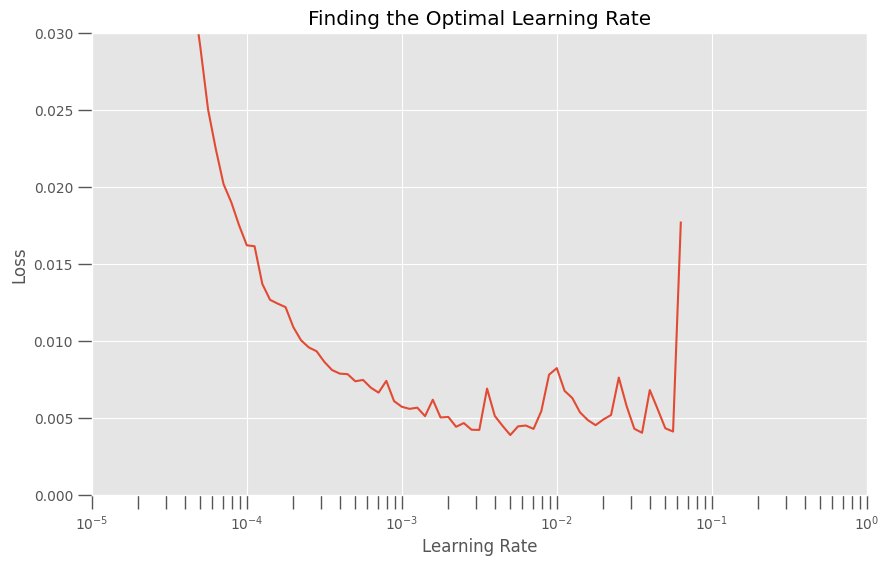

In [ ]:
# Generate a range of learning rates for testing
lrs = START_LR * (10 ** (np.arange(EPOCHS_LR) / 20))

plt.figure(figsize=(10, 6))
plt.grid(True)

# Plot the loss against the learning rates on a logarithmic scale
plt.semilogx(lrs, history.history["loss"])

# Customize tick marks on both axes
plt.tick_params('both', length=10, width=1, which='both')

# Set the axis limits: [x_min, x_max, y_min, y_max]
plt.axis([START_LR, 1, 0, 0.03])

plt.title('Finding the Optimal Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()


###Actual Training

In [ ]:
LEARNING_RATE = 5e-3
NUM_EPOCHS = 20

model.set_weights(init_weights)

model, epoch_losses = train_model(model, (X_train, y_train), (X_test, y_test), NUM_EPOCHS, LEARNING_RATE, BATCH_SIZE)

GPU is available. Training on GPU.
Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.4438 - val_loss: 0.2855 - learning_rate: 8.9125e-05
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2662 - val_loss: 0.2338 - learning_rate: 8.9125e-05
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2375 - val_loss: 0.2299 - learning_rate: 8.9125e-05
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2329 - val_loss: 0.2257 - learning_rate: 8.9125e-05
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2276 - val_loss: 0.2179 - learning_rate: 8.9125e-05
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2185 - val_loss: 0.1987 - learning_rate: 8.9125e-05
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1952 - val_loss: 0.1409 - learning_rate: 8.9125e-05
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1247 - val_loss: 0.0253 - learning_rate: 8.9125e-05
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.

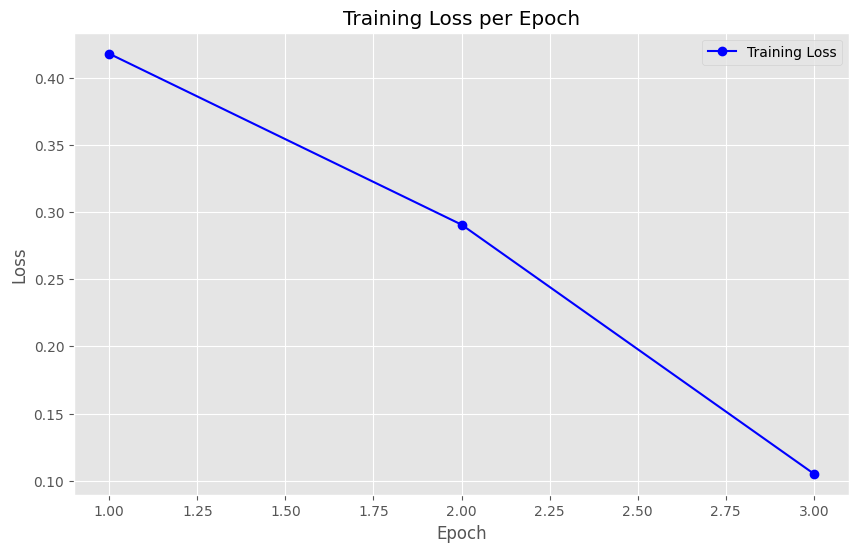

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, len(epoch_losses)), epoch_losses[1:], marker='o', linestyle='-', color='b', label='Training Loss')

plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()


#Federated Learning

##General Functions


In [ ]:
def set_parameters(net, parameters: List[np.ndarray]):
    net.set_weights(parameters)

def get_parameters(net) -> List[np.ndarray]:
    return net.get_weights()

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Dict[str, Scalar]:
    # Extract the number of samples from each metrics entry
    num_samples_list = [num_samples for num_samples, _ in metrics]
    num_samples_sum = sum(num_samples_list)

    weighted_metrics: Dict[str, List[float]] = {}

    # Calculate weighted values for each metric
    for num_samples, metrics_dict in metrics:
        for metric, value in metrics_dict.items():
            if metric not in weighted_metrics:
                weighted_metrics[metric] = []
            weighted_metrics[metric].append(value * num_samples)

    # Compute the final weighted average for each metric
    return {metric: sum(values) / num_samples_sum for metric, values in weighted_metrics.items()}


def compute_weighted_average_weights(weights1, weights2, alpha1, alpha2):
    averaged_weights = []
    for w1, w2 in zip(weights1, weights2):
        averaged_weight = alpha1 * w1 + alpha2 * w2
        averaged_weights.append(averaged_weight)
    return averaged_weights


def load_weights_from_pkl(filepath):
    """
    Load and return the 'global_parameters' from a pickle file (used to store model's parameters).
    """
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    return data['global_parameters']


## Client def

In [ ]:
DATASET = 'soil_moisture' #or 'signal'

if DATASET == 'signal':
    # Assign data to clients for the 'signal' dataset
    client_data_LS1 = {
        0: J_T1_A['Moving Avg'],
        1: J_T2_A['Moving Avg'],
    }
    client_data_LS2 = {
        0: J_T1_B['Moving Avg'],
        1: J_T2_B['Moving Avg'],
    }
    client_data = {
        0: J_T1_A['Moving Avg'],
        1: J_T2_A['Moving Avg'],
        2: J_T1_B['Moving Avg'],
        3: J_T2_B['Moving Avg'],
    }
elif DATASET == 'soil_moisture':
    # Assign data to clients for the 'soil_moisture' dataset
    client_data_LS1 = {
        0: df_N0OZ[['Moving Average Soil Hum', 'Watered']],
        1: df_N0OZ_modif[['Moving Average Soil Hum', 'Watered']]
    }

    client_data_LS2 = {
        0: df_N1OZ_later[['Moving Average Soil Hum', 'Watered']],
        1: df_N0OZ_later[['Moving Average Soil Hum', 'Watered']]
    }

    client_data = {
        0: df_N0OZ[['Moving Average Soil Hum', 'Watered']],
        1: df_N0OZ_modif[['Moving Average Soil Hum', 'Watered']],
        2: df_N1OZ_later[['Moving Average Soil Hum', 'Watered']],
        3: df_N0OZ_later[['Moving Average Soil Hum', 'Watered']]
    }

# Count the number of samples for each client in LS1 and LS2
num_ls1 = {client_id: data.shape[0] for client_id, data in client_data_LS1.items()}
num_ls2 = {client_id: data.shape[0] for client_id, data in client_data_LS2.items()}

# Calculate total samples in each dataset
total_samples_ls1 = sum(num_ls1.values())
total_samples_ls2 = sum(num_ls2.values())
total_samples = total_samples_ls1 + total_samples_ls2

# Print the total number of samples in LS1 and LS2
print("Total number of samples in client_data_LS1:", total_samples_ls1)
print("Total number of samples in client_data_LS2:", total_samples_ls2)


Total number of samples in client_data_LS1: 3481
Total number of samples in client_data_LS2: 5550


In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, X_train, y_train, X_val, y_val, X_test, y_test, cid):
        """Initialize the Flower client with model and data."""
        self.net = net
        self.x_train = X_train
        self.y_train = y_train
        self.x_val = X_val
        self.y_val = y_val
        self.x_test = X_test
        self.y_test = y_test
        self.cid = cid

    def get_parameters(self, config):
        """Return the current model parameters."""
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def set_parameters(self, config):
        """Set the model parameters from the server."""
        print(f"[Client {self.cid}] set_parameters")
        return set_parameters(self.net)

    def fit(self, parameters, config):
        """Train the model on the local dataset."""
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]
        batch_size = config["batch_size"]
        learning_rate = config["learning_rate"]
        print(f"[Client {self.cid}, round {server_round}] fit")

        # Set the model's weights from the received parameters
        self.net.set_weights(parameters)

        # Train the model with local data
        self.net, _ = train_model(self.net, (self.x_train, self.y_train), (self.x_val, self.y_val), local_epochs, learning_rate, batch_size)

        # Return the updated parameters and the number of training samples
        return get_parameters(self.net), len(self.x_train), {}

    def evaluate(self, parameters, config):
        """Evaluate the model on the local test dataset."""
        print(f"[Client {self.cid}] evaluate")

        # Set the model's weights from the received parameters
        self.net.set_weights(parameters)

        # Evaluate the model and return the metrics
        mae, mse, rmse, mape, _ = evaluate_model(self.net, (self.x_test, self.y_test), VERSION)
        return mse, len(self.x_test), {"mae": mae, "mse": mse, "rmse": rmse, "mape": mape}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def client_fn_LS1(context: Context) -> Client:
    """Create and return a Flower client for LS1."""
    model = build_model()  # Build the model

    # Get client ID from context
    cid = int(context.node_config["partition-id"])

    # Prepare data for the client
    X_train, y_train, X_val, y_val, X_test, y_test, train_series_scaled, val_series_scaled, test_series_scaled = data_preparation(
        client_data_LS1[cid], VERSION, N_STEPS_IN, N_STEPS_OUT, TRAIN_SIZE, VAL_SIZE
    )

    print(f"Client number {cid} created")

    # Return the Flower client wrapped in the expected client interface
    return FlowerClient(model, X_train, y_train, X_val, y_val, X_test, y_test, cid).to_client()


def client_fn_LS2(context: Context) -> Client:
    """Create and return a Flower client for LS2."""
    model = build_model()  # Build the model

    # Get client ID from context
    cid = int(context.node_config["partition-id"])

    # Prepare data for the client
    X_train, y_train, X_val, y_val, X_test, y_test, train_series_scaled, val_series_scaled, test_series_scaled = data_preparation(
        client_data_LS2[cid], VERSION, N_STEPS_IN, N_STEPS_OUT, TRAIN_SIZE, VAL_SIZE
    )

    print(f"Client number {cid} created")

    # Return the Flower client wrapped in the expected client interface
    return FlowerClient(model, X_train, y_train, X_val, y_val, X_test, y_test, cid).to_client()


##Strategy Functions

In [ ]:
class FedAvgWithModelSaving(fl.server.strategy.FedAvg):
    def __init__(self, save_path: str, count: int, local: bool, *args, **kwargs):
        """Initialize FedAvg strategy with model saving capability."""
        self.save_path = Path(save_path)
        self.save_path.mkdir(exist_ok=True, parents=True)  # Ensure the save directory exists
        super().__init__(*args, **kwargs)
        self.local = local
        if local:
            self.count = 0  # Initialize counter if count running locally
        else:
            self.count = count  # Use provided count if not local (imposed by code)

    def _save_global_model(self, server_round: int, parameters):
        """Save the global model parameters to a pickle file."""
        print(f"SAVING MODEL {self.count}")
        ndarrays = parameters_to_ndarrays(parameters)  # Convert parameters to ndarray format
        data = {'global_parameters': ndarrays}
        filename = str(self.save_path / f"parameters_round_{self.count}.pkl")

        if self.local:
            self.count += 1  # Increment the counter if running locally

        # Save the model parameters to a pickle file
        with open(filename, 'wb') as h:
            pickle.dump(data, h, protocol=pickle.HIGHEST_PROTOCOL)

        log(INFO, f"Checkpoint saved to: {filename}")

    def evaluate(self, server_round: int, parameters):
        """Evaluate the model and save the global model parameters."""
        self._save_global_model(server_round, parameters)  # Save model before evaluation
        return super().evaluate(server_round, parameters)  # Perform the evaluation from FedAvg


In [ ]:
def strategy(name, params, count, local):
    strategy = FedAvgWithModelSaving(
            local=local,
            save_path=name,
            count=count,
            fraction_fit=1.0,
            fraction_evaluate=1.0,
            min_available_clients=2,
            min_fit_clients=2,
            min_evaluate_clients=2,
            fit_metrics_aggregation_fn=weighted_average,
            evaluate_metrics_aggregation_fn=weighted_average,
            on_fit_config_fn=fit_config,
            initial_parameters=ndarrays_to_parameters(params),)
    return strategy

## Simulation Functions

In [ ]:
client_resources = {"num_cpus": 2}
if tf.config.get_visible_devices("GPU"):
    client_resources["num_gpus"] = 1

def simulation(name, strategy, num_rounds, num_clients):
  if name == 'LS1':
      history = fl.simulation.start_simulation(
      client_fn=client_fn_LS1,
      num_clients=num_clients,
      config=fl.server.ServerConfig(num_rounds=num_rounds),
      strategy=strategy,
      client_resources=client_resources
      )
  elif name == 'LS2':
    history = fl.simulation.start_simulation(
    client_fn=client_fn_LS2,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
    client_resources=client_resources
    )
  return history

In [ ]:
def fit_config(server_round: int):
    return {
        "batch_size": BATCH_SIZE,
        "server_round": server_round,
        "local_epochs": LOCAL_EPOCHS,
        "learning_rate": LEARNING_RATE,
    }

def evaluate_config(rnd: int):
    return {
        "batch_size": BATCH_SIZE,
    }

In [ ]:
def global_simulation(params_1, params_2):
    """Simulate global training across multiple rounds and save the best model based on aggregated loss."""
    losses_LS1, losses_LS2 = [], []
    params_LS1 = copy.deepcopy(params_1)
    params_LS2 = copy.deepcopy(params_2)

    # Create directory for global models
    os.makedirs('Global_Model', exist_ok=True)

    # Iterates over the number of total rounds
    for i in range(NUM_ROUNDS_GLOBAL):
        print(f"ROUNDS NUMBER {i+1}/{NUM_ROUNDS_GLOBAL}")

        # Initialize strategies for LS1 and LS2
        strategy_LS1 = strategy('LS1', params_LS1, i, False)
        strategy_LS2 = strategy('LS2', params_LS2, i, False)

        # Run simulations for LS1 and LS2
        print("BEGINNING SIMULATION LS1")
        history_LS1 = simulation('LS1', strategy_LS1, 1, NUM_CLIENTS)
        print("END SIMULATION LS1")

        print("BEGINNING SIMULATION LS2")
        history_LS2 = simulation('LS2', strategy_LS2, 1, NUM_CLIENTS)
        print("END SIMULATION LS2")

        # Store losses from each round
        losses_LS1.append(history_LS1.losses_distributed)
        losses_LS2.append(history_LS2.losses_distributed)

        # Load model weights from LS1 and LS2
        weights_LS1 = load_weights_from_pkl(f'LS1/parameters_round_{i}.pkl')
        weights_LS2 = load_weights_from_pkl(f'LS2/parameters_round_{i}.pkl')

        # Average weights from both simulations
        print("AVERAGING WEIGHTS...")
        params_GL = compute_weighted_average_weights(weights_LS1, weights_LS2, total_samples_ls1/total_samples, total_samples_ls2/total_samples)

        # Save the averaged global model parameters
        print(f"SAVING GLOBAL MODEL {i}")
        data = {'global_parameters': params_GL}
        filename = str(f"Global_Model/parameters_round_{i}.pkl")
        with open(filename, 'wb') as h:
            pickle.dump(data, h, protocol=pickle.HIGHEST_PROTOCOL)
        log(INFO, f"Checkpoint saved to: {filename}")

        print("AVERAGING WEIGHTS END")
        params_LS1, params_LS2 = params_GL, params_GL  # Update parameters for the next round

    # Calculate aggregated losses and find the round with the minimum loss
    list_losses_LS1 = [loss[0][1] for loss in losses_LS1]
    list_losses_LS2 = [loss[0][1] for loss in losses_LS2]
    loss_aggregated = [loss1 * total_samples_ls1 / total_samples + loss2 * total_samples_ls2 / total_samples for (loss1, loss2) in zip(list_losses_LS1, list_losses_LS2)]
    min_loss = loss_aggregated.index(min(loss_aggregated))

    print(f"Best global model from min aggregated loss: {min_loss+1}")

    # Load and return the best global model weights
    weights = load_weights_from_pkl(f"Global_Model/parameters_round_{min_loss}.pkl")

    return weights, losses_LS1, losses_LS2, loss_aggregated


def local_server_simulation(params_1, params_2):
    """Simulate local server training for LS1 and LS2, and return the best model weights."""
    losses_LS1, losses_LS2 = [], []
    params_LS1 = copy.deepcopy(params_1)
    params_LS2 = copy.deepcopy(params_2)

    # Initialize strategies for local simulations
    strategy_LS1 = strategy('LS1_local', params_LS1, _, True)
    strategy_LS2 = strategy('LS2_local', params_LS2, _, True)

    # Run simulations for LS1 and LS2
    print("BEGINNING SIMULATION LS1")
    history_LS1 = simulation('LS1', strategy_LS1, NUM_ROUNDS_LOCAL, NUM_CLIENTS)
    print("END SIMULATION LS1")

    print("BEGINNING SIMULATION LS2")
    history_LS2 = simulation('LS2', strategy_LS2, NUM_ROUNDS_LOCAL, NUM_CLIENTS)
    print("END SIMULATION LS2")

    # Store losses from the simulations
    losses_LS1.append(history_LS1.losses_distributed)
    losses_LS2.append(history_LS2.losses_distributed)

    # Find the round with the minimum loss for LS1 and LS2
    list_losses_LS1 = [point[1] for point in losses_LS1[0]]
    min_loss_LS1 = list_losses_LS1.index(min(list_losses_LS1))
    list_losses_LS2 = [point[1] for point in losses_LS2[0]]
    min_loss_LS2 = list_losses_LS2.index(min(list_losses_LS2))

    print(f"Best model : LS1: {min_loss_LS1+1}, LS2: {min_loss_LS2+1}")

    # Load and return the best model weights
    weights_LS1 = load_weights_from_pkl(f'LS1_local/parameters_round_{min_loss_LS1+1}.pkl')
    weights_LS2 = load_weights_from_pkl(f'LS2_local/parameters_round_{min_loss_LS2+1}.pkl')

    return weights_LS1, weights_LS2, losses_LS1, losses_LS2


def local_simulation(init_params):
    """Simulate local training for each client and return the trained models and their losses."""
    params = copy.deepcopy(init_params)
    models = []
    epochs_losses = []

    # Iterate over each client in the full dataset
    for client_id, df in client_data.items():
        print(f"Client ID: {client_id}")

        # Prepare the data for the current client
        X_train, y_train, X_val, y_val, X_test, y_test, train_series_scaled, val_series_scaled, test_series_scaled = data_preparation(
            df, VERSION, N_STEPS_IN, N_STEPS_OUT, TRAIN_SIZE, VAL_SIZE
        )
        print(f"Train samples: {len(X_train)}, Val samples: {len(X_val)}, Test samples: {len(X_test)}")

        # Build and set initial parameters for the model
        model = build_model()
        set_parameters(model, params)

        # Train the model and store the loss for each epoch
        model, epochs_loss = train_model(
            model, (X_train, y_train), (X_val, y_val), NUM_EPOCHS, LEARNING_RATE, BATCH_SIZE, val_training=True
        )
        epochs_losses.append(epochs_loss)
        models.append(model)

    # Return the list of trained models and their corresponding losses
    return models, epochs_losses


#Training and Testing

In [ ]:
VERSION = 'long_features' #or 'classic' (but classic is not used)
DATASET = 'soil_moisture' #or = 'soil_moisture' / 'signal'

TRAIN_SIZE = 0.7
VAL_SIZE = 0.15

if DATASET == 'signal':
  FEATURES = ['Moving Avg']
else:
  FEATURES = ['Moving Average Soil Hum', 'Watered']
NB_FEATURES = len(FEATURES)

INPUT_SHAPE = len(FEATURES)
HIDDEN_SIZE = 128
NUM_LAYERS = 1
OUTPUT_SIZE = 1

N_STEPS_IN = 200
N_STEPS_OUT = 30

BATCH_SIZE = 64
LEARNING_RATE = 5e-3

LOCAL_EPOCHS = 3
NUM_CLIENTS = 2
NUM_ROUNDS_GLOBAL = 25
NUM_ROUNDS_LOCAL = NUM_ROUNDS_GLOBAL*2
NUM_EPOCHS = NUM_ROUNDS_GLOBAL*2*LOCAL_EPOCHS

In [ ]:
model = build_model()
initial_params = get_parameters(model)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 200, 64)             │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,646 (467.37 KB)

 Trainable params: 119,646 (467.37 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
models, epochs_losses = local_simulation(initial_params)

Client ID: 0
Train samples: 1031, Val samples: 41, Test samples: 41
GPU is available. Training on GPU.
Epoch 1/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.2270 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0187 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0077 - val_loss: 9.2021e-04 - learning_rate: 0.0010
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054 - val_loss: 7.4843e-04 - learning_rate: 0.0010
Epoch 5/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0053 - val_loss: 5.9640e-04 - learning_rate: 0.0010
Epoch 6/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040 - val_loss: 3.5432e-04 - learning_rate: 0.0010
Epoch 7/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0039 - val_loss: 3.0205e-04 - learning_rate: 0.0010
Epoch 8/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038 - val_loss: 2.3674e-04 - learning_rate: 

In [ ]:
params_GL, losses_GL_LS1, losses_GL_LS2, loss_aggregated = global_simulation(initial_params, initial_params)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


ROUNDS NUMBER 1/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:04:43,785	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3982585036.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'memory': 7965170075.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 0


(pid=2730) 2024-09-18 16:04:46.788221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=2730) 2024-09-18 16:04:46.837353: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=2730) 2024-09-18 16:04:46.845838: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=2730) 2024-09-18 16:04:47.916638: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=2730) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=2730) I0000 00:00:1726675489.653526    2730 cuda_executor.cc:101

(ClientAppActor pid=2730) Client number 1 created
(ClientAppActor pid=2730) [Client 1, round 1] fit
(ClientAppActor pid=2730) GPU is available. Training on GPU.
(ClientAppActor pid=2730) Epoch 1/3


(ClientAppActor pid=2730) W0000 00:00:1726675492.382090    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675492.456355    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675492.457511    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675492.458692    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675492.459882    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675492.461036    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675492.462184    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:36 7s/step - loss: 0.4497
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4157


(ClientAppActor pid=2730) W0000 00:00:1726675496.995348    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675496.997342    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675496.998555    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675497.002330    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675497.003580    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675497.005707    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675497.007127    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3546
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3466


(ClientAppActor pid=2730) W0000 00:00:1726675497.255382    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675497.256457    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675497.257535    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675497.258599    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675497.259643    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675497.260674    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675497.261762    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.3397 - val_loss: 0.0196 - learning_rate: 0.0010
(ClientAppActor pid=2730) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0378
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0345
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0316 - val_loss: 0.0045 - learning_rate: 0.0010
(ClientAppActor pid=2730) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0118
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0113
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0109 - val_loss: 8.6241e-04 - learning_rate: 0.0010
(ClientAppActor pid=2730) Client number 0 created
(ClientAppActor pid=2730) [Client 0, round 1] fit
(ClientAppActor pid=2730) GPU is available. Training on GPU.
(ClientAppActor pid=2730) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.3201
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2528
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2300


(ClientAppActor pid=2730) W0000 00:00:1726675500.163057    2805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675500.163831    2805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675500.164530    2805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675500.165162    2805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675500.165783    2805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675500.166420    2805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675500.167045    2805 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2255 - val_loss: 0.0120 - learning_rate: 0.0010
(ClientAppActor pid=2730) Epoch 2/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0218


(ClientAppActor pid=2730) W0000 00:00:1726675500.402258    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675500.402975    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675500.403650    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675500.404338    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675500.405045    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675500.405725    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675500.406395    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0189
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0184 - val_loss: 0.0021 - learning_rate: 0.0010
(ClientAppActor pid=2730) Epoch 3/3
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0077


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_0.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0073
SAVING MODEL 0
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0071 - val_loss: 5.8947e-04 - learning_rate: 0.0010
(ClientAppActor pid=2730) Client number 1 created
(ClientAppActor pid=2730) [Client 1] evaluate


(ClientAppActor pid=2730) W0000 00:00:1726675501.133236    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675501.134526    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675501.135307    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675501.135961    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675501.136631    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675501.137268    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675501.137920    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=2730) Client number 0 created
(ClientAppActor pid=2730) [Client 0] evaluate


(ClientAppActor pid=2730) W0000 00:00:1726675501.395345    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675501.396028    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675501.396669    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675501.397340    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675501.397998    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675501.398640    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=2730) W0000 00:00:1726675501.399272    2804 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:05:06,378	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7965914727.0, 'object_store_memory': 3982957363.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 0


(pid=3233) 2024-09-18 16:05:12.695296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=3233) 2024-09-18 16:05:12.714888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=3233) 2024-09-18 16:05:12.720801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=3233) 2024-09-18 16:05:14.454686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=3233) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=3233) I0000 00:00:1726675516.228891    3233 cuda_executor.cc:101

(ClientAppActor pid=3233) Client number 1 created
(ClientAppActor pid=3233) [Client 1, round 1] fit
(ClientAppActor pid=3233) GPU is available. Training on GPU.
(ClientAppActor pid=3233) Epoch 1/3


(ClientAppActor pid=3233) W0000 00:00:1726675518.281804    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675518.356157    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675518.357329    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675518.358517    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675518.359700    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675518.360851    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675518.361983    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 1/29 ━━━━━━━━━━━━━━━━━━━━ 2:24 5s/step - loss: 0.3094
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2621
10/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2429
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2249
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2038


(ClientAppActor pid=3233) W0000 00:00:1726675522.348465    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675522.349246    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675522.349972    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675522.350718    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675522.351447    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675522.352175    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675522.352906    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1651
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1593


(ClientAppActor pid=3233) W0000 00:00:1726675523.564789    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675523.565908    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675523.566574    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675523.567230    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675523.567957    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675523.568624    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675523.569310    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.1566 - val_loss: 0.0023 - learning_rate: 0.0010
(ClientAppActor pid=3233) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0079
10/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0065
19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0059
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0055
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0054 - val_loss: 1.9492e-04 - learning_rate: 0.0010
(ClientAppActor pid=3233) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0033
 9/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0033
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0032
21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0032
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0032
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0031 - val_loss: 1.8077e-04 - learning_rate: 0.0010
(ClientAppActor pid=3233) Client number 0 created
(ClientAppActor pid=3233) [Client 0, round 1] fit
(ClientAppActor pid=3233) GPU i

(ClientAppActor pid=3233) W0000 00:00:1726675527.096979    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675527.097745    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675527.098452    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675527.099154    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675527.099863    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675527.100589    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675527.101296    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1974


(ClientAppActor pid=3233) W0000 00:00:1726675527.346960    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675527.347689    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675527.348342    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675527.349010    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675527.349679    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675527.350365    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675527.351007    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1940 - val_loss: 0.0084 - learning_rate: 0.0010
(ClientAppActor pid=3233) Epoch 2/3
 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0080
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0066
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0063 - val_loss: 7.3064e-04 - learning_rate: 0.0010
(ClientAppActor pid=3233) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0025
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_0.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036
SAVING MODEL 0
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - val_loss: 2.8097e-04 - learning_rate: 0.0010
(ClientAppActor pid=3233) Client number 0 created
(ClientAppActor pid=3233) [Client 0] evaluate


(ClientAppActor pid=3233) W0000 00:00:1726675528.262998    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675528.263731    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675528.264365    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675528.264986    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675528.265621    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675528.266256    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675528.266878    3318 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=3233) Client number 1 created
(ClientAppActor pid=3233) [Client 1] evaluate


(ClientAppActor pid=3233) W0000 00:00:1726675528.801690    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675528.802734    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675528.803473    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675528.804228    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675528.804946    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675528.805781    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3233) W0000 00:00:1726675528.807085    3319 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 0
AVERAGING WEIGHTS END
ROUNDS NUMBER 2/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:05:33,528	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7966005659.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3983002828.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 1


(pid=3738) 2024-09-18 16:05:36.095702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=3738) 2024-09-18 16:05:36.120975: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=3738) 2024-09-18 16:05:36.127749: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=3738) 2024-09-18 16:05:37.588025: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=3738) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=3738) I0000 00:00:1726675540.247143    3738 cuda_executor.cc:101

(ClientAppActor pid=3738) Client number 0 created
(ClientAppActor pid=3738) [Client 0, round 1] fit
(ClientAppActor pid=3738) GPU is available. Training on GPU.
(ClientAppActor pid=3738) Epoch 1/3


(ClientAppActor pid=3738) W0000 00:00:1726675542.551868    3818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675542.662829    3818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675542.665666    3818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675542.666973    3818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675542.668285    3818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675542.669548    3818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675542.670725    3818 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0082
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0104


(ClientAppActor pid=3738) W0000 00:00:1726675546.284954    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675546.285733    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675546.286462    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675546.287160    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675546.287855    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675546.288552    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675546.289253    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0104


(ClientAppActor pid=3738) W0000 00:00:1726675546.513131    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675546.514013    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675546.516981    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675546.517792    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675546.518651    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675546.519493    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675546.520273    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0103 - val_loss: 0.0013 - learning_rate: 0.0010
(ClientAppActor pid=3738) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0049
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0049
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0049 - val_loss: 2.5381e-04 - learning_rate: 0.0010
(ClientAppActor pid=3738) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0036
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0039 - val_loss: 3.9638e-04 - learning_rate: 0.0010
(ClientAppActor pid=3738) Client number 1 created
(ClientAppActor pid=3738) [Client 1, round 1] fit
(ClientAppActor pid=3738) GPU is available. Training on GPU.
(ClientAppActor pid=3738) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0059
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0126
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0125


(ClientAppActor pid=3738) W0000 00:00:1726675549.240787    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675549.241476    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675549.242111    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675549.242746    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675549.243382    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675549.244019    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675549.244659    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0123 - val_loss: 0.0012 - learning_rate: 0.0010
(ClientAppActor pid=3738) Epoch 2/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0090
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0083 - val_loss: 0.0010 - learning_rate: 0.0010
(ClientAppActor pid=3738) Epoch 3/3


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_1.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054 - val_loss: 1.5585e-04 - learning_rate: 0.0010
SAVING MODEL 1
(ClientAppActor pid=3738) Client number 1 created
(ClientAppActor pid=3738) [Client 1] evaluate


(ClientAppActor pid=3738) W0000 00:00:1726675550.160285    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675550.160964    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675550.161597    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675550.162218    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675550.162837    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675550.163465    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675550.164094    3819 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=3738) Client number 0 created
(ClientAppActor pid=3738) [Client 0] evaluate


(ClientAppActor pid=3738) W0000 00:00:1726675550.406806    3818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675550.407512    3818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675550.408160    3818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675550.408786    3818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675550.409410    3818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675550.410034    3818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=3738) W0000 00:00:1726675550.410740    3818 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:05:55,471	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3982789017.0, 'memory': 7965578036.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 1


(pid=4231) 2024-09-18 16:05:58.069879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=4231) 2024-09-18 16:05:58.092469: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=4231) 2024-09-18 16:05:58.098471: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=4231) 2024-09-18 16:05:59.217707: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=4231) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=4231) I0000 00:00:1726675560.946161    4231 cuda_executor.cc:101

(ClientAppActor pid=4231) Client number 0 created
(ClientAppActor pid=4231) [Client 0, round 1] fit
(ClientAppActor pid=4231) GPU is available. Training on GPU.
(ClientAppActor pid=4231) Epoch 1/3


(ClientAppActor pid=4231) W0000 00:00:1726675563.215916    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675563.394743    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675563.395941    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675563.399186    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675563.402184    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675563.403413    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675563.406187    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 1/26 ━━━━━━━━━━━━━━━━━━━━ 2:48 7s/step - loss: 0.0031
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0203


(ClientAppActor pid=4231) W0000 00:00:1726675568.188125    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675568.190138    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675568.191358    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675568.195091    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675568.196331    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675568.198451    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675568.199775    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0206
20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0185
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0174


(ClientAppActor pid=4231) W0000 00:00:1726675568.569100    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675568.569837    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675568.570563    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675568.571271    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675568.571964    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675568.572733    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675568.573595    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0170 - val_loss: 0.0012 - learning_rate: 0.0010
(ClientAppActor pid=4231) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0041
 9/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0045


(ClientAppActor pid=4231) W0000 00:00:1726675569.588722    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675569.589441    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675569.590123    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675569.590788    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675569.592158    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675569.592853    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675569.593558    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0043
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0041
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0040 - val_loss: 0.0012 - learning_rate: 0.0010
(ClientAppActor pid=4231) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0040
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - val_loss: 2.1470e-04 - learning_rate: 0.0010
(ClientAppActor pid=4231) Client number 1 created
(ClientAppActor pid=4231) [Client 1, round 1] fit
(ClientAppActor pid=4231) GPU is available. Training on GPU.
(ClientAppActor pid=4231) Epoch 1/3
 6/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0068
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0056


(ClientAppActor pid=4231) W0000 00:00:1726675572.140364    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675572.141083    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675572.141719    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675572.142368    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675572.142999    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675572.143636    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675572.144271    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0055 - val_loss: 0.0013 - learning_rate: 0.0010
(ClientAppActor pid=4231) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0035
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029


(ClientAppActor pid=4231) W0000 00:00:1726675572.380403    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675572.381096    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675572.381723    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675572.382373    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675572.383002    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675572.383633    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675572.384257    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - val_loss: 3.3217e-04 - learning_rate: 0.0010
(ClientAppActor pid=4231) Epoch 3/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_1.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018
SAVING MODEL 1
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 2.7950e-04 - learning_rate: 0.0010
(ClientAppActor pid=4231) Client number 1 created
(ClientAppActor pid=4231) [Client 1] evaluate


(ClientAppActor pid=4231) W0000 00:00:1726675573.365039    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675573.365753    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675573.366442    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675573.367112    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675573.367744    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675573.368388    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675573.369022    4299 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=4231) Client number 0 created
(ClientAppActor pid=4231) [Client 0] evaluate


(ClientAppActor pid=4231) W0000 00:00:1726675573.872840    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675573.873516    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675573.874144    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675573.874759    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675573.875411    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675573.876031    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4231) W0000 00:00:1726675573.876657    4298 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 1
AVERAGING WEIGHTS END
ROUNDS NUMBER 3/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:06:18,756	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7965732864.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'object_store_memory': 3982866432.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 2


(pid=4734) 2024-09-18 16:06:22.528865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=4734) 2024-09-18 16:06:22.563677: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=4734) 2024-09-18 16:06:22.572930: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=4734) 2024-09-18 16:06:23.675889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=4734) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=4734) I0000 00:00:1726675585.426659    4734 cuda_executor.cc:101

(ClientAppActor pid=4734) Client number 0 created
(ClientAppActor pid=4734) [Client 0, round 1] fit
(ClientAppActor pid=4734) GPU is available. Training on GPU.
(ClientAppActor pid=4734) Epoch 1/3


(ClientAppActor pid=4734) W0000 00:00:1726675587.436212    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675587.520556    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675587.521708    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675587.522887    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675587.524125    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675587.525278    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675587.526419    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0067
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0071


(ClientAppActor pid=4734) W0000 00:00:1726675591.396303    4799 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675591.397283    4799 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675591.398238    4799 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675591.399195    4799 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675591.400184    4799 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675591.401114    4799 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675591.402028    4799 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0070
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0069


(ClientAppActor pid=4734) W0000 00:00:1726675591.663007    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675591.663727    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675591.664390    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675591.665049    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675591.665705    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675591.666377    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675591.667023    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - loss: 0.0069 - val_loss: 0.0020 - learning_rate: 0.0010
(ClientAppActor pid=4734) Epoch 2/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0042
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0038 - val_loss: 3.1370e-04 - learning_rate: 0.0010
(ClientAppActor pid=4734) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0021
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0030 - val_loss: 2.4380e-04 - learning_rate: 0.0010
(ClientAppActor pid=4734) Client number 1 created
(ClientAppActor pid=4734) [Client 1, round 1] fit
(ClientAppActor pid=4734) GPU is available. Training on GPU.
(ClientAppActor pid=4734) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.0041
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0102
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - los

(ClientAppActor pid=4734) W0000 00:00:1726675595.733795    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675595.734717    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675595.735939    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675595.736803    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675595.737955    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675595.738848    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675595.739701    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0097 - val_loss: 5.9594e-04 - learning_rate: 0.0010
(ClientAppActor pid=4734) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0047
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_2.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0045 - val_loss: 0.0013 - learning_rate: 0.0010
(ClientAppActor pid=4734) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0038
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038
SAVING MODEL 2
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037 - val_loss: 2.9621e-04 - learning_rate: 0.0010
(ClientAppActor pid=4734) Client number 1 created
(ClientAppActor pid=4734) [Client 1] evaluate


(ClientAppActor pid=4734) W0000 00:00:1726675596.733790    4799 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675596.734490    4799 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675596.735171    4799 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675596.735805    4799 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675596.736452    4799 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675596.737090    4799 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675596.737770    4799 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=4734) Client number 0 created
(ClientAppActor pid=4734) [Client 0] evaluate


(ClientAppActor pid=4734) W0000 00:00:1726675597.002544    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675597.003272    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675597.004001    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675597.004727    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675597.005973    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675597.006786    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=4734) W0000 00:00:1726675597.007522    4798 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:06:41,130	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3982824652.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'memory': 7965649307.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 2


(pid=5222) 2024-09-18 16:06:44.108478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=5222) 2024-09-18 16:06:44.128712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=5222) 2024-09-18 16:06:44.134606: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=5222) 2024-09-18 16:06:45.253659: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=5222) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=5222) I0000 00:00:1726675607.487694    5222 cuda_executor.cc:101

(ClientAppActor pid=5222) Client number 1 created
(ClientAppActor pid=5222) [Client 1, round 1] fit
(ClientAppActor pid=5222) GPU is available. Training on GPU.
(ClientAppActor pid=5222) Epoch 1/3


(ClientAppActor pid=5222) W0000 00:00:1726675610.274267    5293 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675610.351154    5293 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675610.352303    5293 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675610.353488    5293 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675610.354679    5293 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675610.355832    5293 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675610.356963    5293 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 1/29 ━━━━━━━━━━━━━━━━━━━━ 2:38 6s/step - loss: 0.0034
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0050
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0047
21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0043


(ClientAppActor pid=5222) W0000 00:00:1726675614.278653    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675614.279400    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675614.280097    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675614.280776    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675614.281462    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675614.282149    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675614.282864    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0040


(ClientAppActor pid=5222) W0000 00:00:1726675615.136947    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675615.137637    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675615.138262    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675615.138960    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675615.139594    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675615.140245    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675615.140866    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0039 - val_loss: 6.0495e-04 - learning_rate: 0.0010
(ClientAppActor pid=5222) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0020
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 3.0296e-04 - learning_rate: 0.0010
(ClientAppActor pid=5222) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0012
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 2.2502e-04 - learning_rate: 0.0010
(ClientAppActor pid=5222) Client number 0 created
(ClientAppActor pid=5222) [Client 0, round 1] fit
(ClientAppActor pid=5222) GPU is available. Training on GPU.
(ClientAppActor pid=5222) Epoch 1/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step -

(ClientAppActor pid=5222) W0000 00:00:1726675617.621902    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675617.622579    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675617.623214    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675617.623844    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675617.624496    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675617.625152    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675617.625800    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0035 - val_loss: 0.0011 - learning_rate: 0.0010
(ClientAppActor pid=5222) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0016
11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 2.1760e-04 - learning_rate: 0.0010
(ClientAppActor pid=5222) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0012


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_2.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
SAVING MODEL 2
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013 - val_loss: 7.1948e-04 - learning_rate: 0.0010
(ClientAppActor pid=5222) Client number 0 created
(ClientAppActor pid=5222) [Client 0] evaluate


(ClientAppActor pid=5222) W0000 00:00:1726675618.784389    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675618.785081    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675618.785694    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675618.786315    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675618.786936    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675618.787591    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5222) W0000 00:00:1726675618.788220    5292 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=5222) Client number 1 created
(ClientAppActor pid=5222) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 16.45s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.00018124125846190624
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.01234829882397478)],
INFO :      	 'mape': [(1, 0.038904222192196636)],
INFO :      	 'mse': [(1, 0.00018124125846190624)],
INFO :      	 'rmse': [(1, 0.013414562678458513)]}
INFO :      
INFO :      Checkpoint saved to: Global_Model/parameters_round_2.pkl
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 2
AVERAGING WEIGHTS END
ROUNDS NUMBER 4/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:07:03,978	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'memory': 7965919643.0, 'object_store_memory': 3982959820.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 3


(pid=5718) 2024-09-18 16:07:06.577916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=5718) 2024-09-18 16:07:06.597581: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=5718) 2024-09-18 16:07:06.604184: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=5718) 2024-09-18 16:07:07.757923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=5718) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=5718) I0000 00:00:1726675629.484359    5718 cuda_executor.cc:101

(ClientAppActor pid=5718) Client number 1 created
(ClientAppActor pid=5718) [Client 1, round 1] fit
(ClientAppActor pid=5718) GPU is available. Training on GPU.
(ClientAppActor pid=5718) Epoch 1/3


(ClientAppActor pid=5718) W0000 00:00:1726675631.823520    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675631.943622    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675631.944819    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675631.946147    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675631.947443    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675631.948651    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675631.949814    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 4/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0113
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0123


(ClientAppActor pid=5718) W0000 00:00:1726675637.293557    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675637.294379    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675637.295169    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675637.295956    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675637.296755    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675637.297566    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675637.298410    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0119


(ClientAppActor pid=5718) W0000 00:00:1726675637.529338    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675637.530237    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675637.531270    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675637.532157    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675637.533039    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675637.533971    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675637.534838    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 0.0117 - val_loss: 2.4193e-04 - learning_rate: 0.0010
(ClientAppActor pid=5718) Epoch 2/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0047
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0044 - val_loss: 2.1914e-04 - learning_rate: 0.0010
(ClientAppActor pid=5718) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0035
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - val_loss: 2.6864e-04 - learning_rate: 0.0010
(ClientAppActor pid=5718) Client number 0 created
(ClientAppActor pid=5718) [Client 0, round 1] fit
(ClientAppActor pid=5718) GPU is available. Training on GPU.
(ClientAppActor pid=5718) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0023
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048


(ClientAppActor pid=5718) W0000 00:00:1726675640.254212    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675640.254978    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675640.255702    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675640.256414    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675640.257205    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675640.257903    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675640.258623    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046


(ClientAppActor pid=5718) W0000 00:00:1726675640.484954    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675640.485690    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675640.486419    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675640.487146    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675640.487866    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675640.488537    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675640.489173    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0046 - val_loss: 2.1584e-04 - learning_rate: 0.0010
(ClientAppActor pid=5718) Epoch 2/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034


INFO :      aggregate_fit: received 2 results and 0 failures


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - val_loss: 7.6987e-04 - learning_rate: 0.0010
(ClientAppActor pid=5718) Epoch 3/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024
SAVING MODEL 3


INFO :      Checkpoint saved to: LS1/parameters_round_3.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024 - val_loss: 0.0022 - learning_rate: 0.0010
(ClientAppActor pid=5718) Client number 0 created
(ClientAppActor pid=5718) [Client 0] evaluate


(ClientAppActor pid=5718) W0000 00:00:1726675641.208368    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675641.209044    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675641.209671    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675641.210357    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675641.211011    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675641.211671    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=5718) W0000 00:00:1726675641.212360    5784 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=5718) Client number 1 created
(ClientAppActor pid=5718) [Client 1] evaluate
END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:07:25,337	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3983076556.0, 'node:__internal_head__': 1.0, 'memory': 7966153115.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 3


(pid=6211) 2024-09-18 16:07:29.888323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=6211) 2024-09-18 16:07:29.925314: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=6211) 2024-09-18 16:07:29.935142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=6211) 2024-09-18 16:07:31.206108: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=6211) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=6211) I0000 00:00:1726675652.955851    6211 cuda_executor.cc:101

(ClientAppActor pid=6211) Client number 0 created
(ClientAppActor pid=6211) [Client 0, round 1] fit
(ClientAppActor pid=6211) GPU is available. Training on GPU.
(ClientAppActor pid=6211) Epoch 1/3


(ClientAppActor pid=6211) W0000 00:00:1726675654.982563    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675655.053595    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675655.054744    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675655.055947    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675655.057183    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675655.058376    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675655.059513    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0046
10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0052
16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0049
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0044


(ClientAppActor pid=6211) W0000 00:00:1726675659.044023    6289 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675659.044793    6289 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675659.045526    6289 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675659.046244    6289 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675659.046959    6289 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675659.047691    6289 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675659.048415    6289 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0043 - val_loss: 0.0011 - learning_rate: 0.0010
(ClientAppActor pid=6211) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0018
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 4.5437e-04 - learning_rate: 0.0010
(ClientAppActor pid=6211) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.8742e-04
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014 - val_loss: 1.6385e-04 - learning_rate: 0.0010
(ClientAppActor pid=6211) Client number 1 created
(ClientAppActor pid=6211) [Client 1, round 1] fit
(ClientAppActor pid=6211) GPU is available. Training on GPU.
(ClientAppActor pid=6211) Epoch 1/3
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 

(ClientAppActor pid=6211) W0000 00:00:1726675663.314114    6289 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675663.315032    6289 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675663.315833    6289 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675663.316629    6289 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675663.317434    6289 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675663.318491    6289 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675663.319327    6289 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0065
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0064


(ClientAppActor pid=6211) W0000 00:00:1726675663.702015    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675663.702793    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675663.703468    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675663.704135    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675663.704802    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675663.705485    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675663.706155    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0064 - val_loss: 3.0028e-04 - learning_rate: 0.0010
(ClientAppActor pid=6211) Epoch 2/3
 5/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015 - val_loss: 2.1598e-04 - learning_rate: 0.0010
(ClientAppActor pid=6211) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 9.8323e-04
 5/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011    
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013
21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_3.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013
SAVING MODEL 3
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013 - val_loss: 4.2158e-04 - learning_rate: 0.0010
(ClientAppActor pid=6211) Client number 1 created
(ClientAppActor pid=6211) [Client 1] evaluate


(ClientAppActor pid=6211) W0000 00:00:1726675665.119169    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675665.119951    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675665.121063    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675665.121800    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675665.122596    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675665.123607    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675665.124315    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=6211) Client number 0 created
(ClientAppActor pid=6211) [Client 0] evaluate


(ClientAppActor pid=6211) W0000 00:00:1726675665.692419    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675665.693115    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675665.693742    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675665.694366    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675665.694988    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675665.695620    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6211) W0000 00:00:1726675665.696248    6288 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 3
AVERAGING WEIGHTS END
ROUNDS NUMBER 5/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:07:50,580	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7965560832.0, 'object_store_memory': 3982780416.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 4


(pid=6714) 2024-09-18 16:07:53.212991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=6714) 2024-09-18 16:07:53.233580: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=6714) 2024-09-18 16:07:53.239599: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=6714) 2024-09-18 16:07:54.391379: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=6714) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=6714) I0000 00:00:1726675676.517058    6714 cuda_executor.cc:101

(ClientAppActor pid=6714) Client number 0 created
(ClientAppActor pid=6714) [Client 0, round 1] fit
(ClientAppActor pid=6714) GPU is available. Training on GPU.
(ClientAppActor pid=6714) Epoch 1/3


(ClientAppActor pid=6714) W0000 00:00:1726675679.616065    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675679.748570    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675679.749791    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675679.751047    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675679.752353    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675679.753598    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675679.754761    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:34 6s/step - loss: 0.0024
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0061


(ClientAppActor pid=6714) W0000 00:00:1726675683.048719    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675683.050677    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675683.051880    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675683.055656    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675683.056899    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675683.059031    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675683.060386    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0063
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0058


(ClientAppActor pid=6714) W0000 00:00:1726675683.323058    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675683.324046    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675683.324914    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675683.325745    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675683.326590    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675683.327425    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675683.328264    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.0058 - val_loss: 0.0011 - learning_rate: 0.0010
(ClientAppActor pid=6714) Epoch 2/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - val_loss: 2.2934e-04 - learning_rate: 0.0010
(ClientAppActor pid=6714) Epoch 3/3
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023 - val_loss: 3.8861e-04 - learning_rate: 0.0010
(ClientAppActor pid=6714) Client number 1 created
(ClientAppActor pid=6714) [Client 1, round 1] fit
(ClientAppActor pid=6714) GPU is available. Training on GPU.
(ClientAppActor pid=6714) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 0.0034
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0119


(ClientAppActor pid=6714) W0000 00:00:1726675686.264637    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675686.265318    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675686.265958    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675686.266589    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675686.267219    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675686.267849    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675686.268497    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0115 - val_loss: 3.8765e-04 - learning_rate: 0.0010
(ClientAppActor pid=6714) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0032
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0043


(ClientAppActor pid=6714) W0000 00:00:1726675686.483742    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675686.484508    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675686.485240    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675686.485969    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675686.486764    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675686.487545    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675686.488337    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0042 - val_loss: 4.3887e-05 - learning_rate: 0.0010
(ClientAppActor pid=6714) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0034
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031
SAVING MODEL 4
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - val_loss: 2.1567e-04 - learning_rate: 0.0010
(ClientAppActor pid=6714) Client number 1 created
(ClientAppActor pid=6714) [Client 1] evaluate


(ClientAppActor pid=6714) W0000 00:00:1726675687.206375    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675687.207108    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675687.207723    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675687.208374    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675687.208998    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675687.209663    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675687.210299    6784 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=6714) Client number 0 created
(ClientAppActor pid=6714) [Client 0] evaluate


(ClientAppActor pid=6714) W0000 00:00:1726675687.454600    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675687.455308    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675687.455943    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675687.456575    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675687.457208    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675687.457840    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6714) W0000 00:00:1726675687.458466    6785 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:08:13,089	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3982759526.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'memory': 7965519054.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 4


(pid=7209) 2024-09-18 16:08:15.724009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=7209) 2024-09-18 16:08:15.756161: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=7209) 2024-09-18 16:08:15.767869: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=7209) 2024-09-18 16:08:16.853862: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=7209) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=7209) I0000 00:00:1726675698.611882    7209 cuda_executor.cc:101

(ClientAppActor pid=7209) Client number 1 created
(ClientAppActor pid=7209) [Client 1, round 1] fit
(ClientAppActor pid=7209) GPU is available. Training on GPU.
(ClientAppActor pid=7209) Epoch 1/3


(ClientAppActor pid=7209) W0000 00:00:1726675700.639554    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675700.711342    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675700.712488    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675700.713658    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675700.714843    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675700.715987    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675700.717150    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0027
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0027


(ClientAppActor pid=7209) W0000 00:00:1726675705.184820    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675705.187323    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675705.188627    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675705.193339    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675705.194630    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675705.196827    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675705.198246    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0027
19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0025
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024


(ClientAppActor pid=7209) W0000 00:00:1726675705.744057    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675705.744840    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675705.745559    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675705.746279    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675705.746982    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675705.747711    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675705.748441    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0024 - val_loss: 1.3995e-04 - learning_rate: 0.0010
(ClientAppActor pid=7209) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0013
11/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013


(ClientAppActor pid=7209) W0000 00:00:1726675706.855444    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675706.856142    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675706.856804    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675706.857488    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675706.858154    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675706.858840    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675706.859510    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

16/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 1.0909e-04 - learning_rate: 0.0010
(ClientAppActor pid=7209) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0011
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 2.6466e-04 - learning_rate: 0.0010
(ClientAppActor pid=7209) Client number 0 created
(ClientAppActor pid=7209) [Client 0, round 1] fit
(ClientAppActor pid=7209) GPU is available. Training on GPU.
(ClientAppActor pid=7209) Epoch 1/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 0.0014
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0046


(ClientAppActor pid=7209) W0000 00:00:1726675709.361264    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675709.361948    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675709.362600    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675709.363280    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675709.363985    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675709.364703    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675709.367920    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0046 - val_loss: 0.0019 - learning_rate: 0.0010
(ClientAppActor pid=7209) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0014
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018


(ClientAppActor pid=7209) W0000 00:00:1726675709.605729    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675709.606412    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675709.607044    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675709.607674    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675709.608305    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675709.608973    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675709.609610    7277 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017 - val_loss: 8.6456e-04 - learning_rate: 0.0010
(ClientAppActor pid=7209) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0013


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_4.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
SAVING MODEL 4
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012 - val_loss: 2.5712e-04 - learning_rate: 0.0010
(ClientAppActor pid=7209) Client number 0 created
(ClientAppActor pid=7209) [Client 0] evaluate


(ClientAppActor pid=7209) W0000 00:00:1726675710.537466    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675710.538155    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675710.538792    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675710.539430    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675710.540081    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675710.540718    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7209) W0000 00:00:1726675710.541401    7276 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=7209) Client number 1 created
(ClientAppActor pid=7209) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 16.57s
INFO :      	History (loss, distributed):
INFO :      		round 1: 2.1938906355701438e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.0036549976290631203)],
INFO :      	 'mape': [(1, 0.011653838668535681)],
INFO :      	 'mse': [(1, 2.1938906355701438e-05)],
INFO :      	 'rmse': [(1, 0.004557769219049315)]}
INFO :      
INFO :      Checkpoint saved to: Global_Model/parameters_round_4.pkl
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 4
AVERAGING WEIGHTS END
ROUNDS NUMBER 6/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:08:35,900	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3982641561.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7965283124.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 5


(pid=7698) 2024-09-18 16:08:39.839473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=7698) 2024-09-18 16:08:39.875803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=7698) 2024-09-18 16:08:39.886928: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=7698) 2024-09-18 16:08:41.368979: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=7698) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=7698) I0000 00:00:1726675723.155035    7698 cuda_executor.cc:101

(ClientAppActor pid=7698) Client number 0 created
(ClientAppActor pid=7698) [Client 0, round 1] fit
(ClientAppActor pid=7698) GPU is available. Training on GPU.
(ClientAppActor pid=7698) Epoch 1/3


(ClientAppActor pid=7698) W0000 00:00:1726675725.337441    7780 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675725.445612    7780 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675725.446867    7780 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675725.448214    7780 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675725.449532    7780 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675725.450799    7780 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675725.451986    7780 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:20 5s/step - loss: 0.0034
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0049


(ClientAppActor pid=7698) W0000 00:00:1726675728.802412    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675728.804478    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675728.805690    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675728.809539    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675728.810799    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675728.812903    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675728.814276    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0049
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0046


(ClientAppActor pid=7698) W0000 00:00:1726675729.081447    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675729.082321    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675729.083155    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675729.083978    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675729.084819    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675729.085654    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675729.086530    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0045 - val_loss: 8.5552e-04 - learning_rate: 0.0010
(ClientAppActor pid=7698) Epoch 2/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0025 - val_loss: 1.4693e-04 - learning_rate: 0.0010
(ClientAppActor pid=7698) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0023
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0022
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - val_loss: 2.1327e-04 - learning_rate: 0.0010
(ClientAppActor pid=7698) Client number 1 created
(ClientAppActor pid=7698) [Client 1, round 1] fit
(ClientAppActor pid=7698) GPU is available. Training on GPU.
(ClientAppActor pid=7698) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0020
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0057
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0056
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step -

(ClientAppActor pid=7698) W0000 00:00:1726675732.637986    7780 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675732.638883    7780 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675732.639710    7780 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675732.640545    7780 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675732.641374    7780 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675732.642217    7780 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675732.643061    7780 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0055 - val_loss: 4.1081e-05 - learning_rate: 0.0010
(ClientAppActor pid=7698) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0026
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0030
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0029 - val_loss: 1.9882e-04 - learning_rate: 0.0010
(ClientAppActor pid=7698) Epoch 3/3
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_5.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024
SAVING MODEL 5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0024 - val_loss: 5.3474e-05 - learning_rate: 0.0010
(ClientAppActor pid=7698) Client number 1 created
(ClientAppActor pid=7698) [Client 1] evaluate


(ClientAppActor pid=7698) W0000 00:00:1726675733.979561    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675733.980321    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675733.981009    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675733.981725    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675733.982405    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675733.983122    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675733.983825    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=7698) Client number 0 created
(ClientAppActor pid=7698) [Client 0] evaluate


(ClientAppActor pid=7698) W0000 00:00:1726675734.379726    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675734.380510    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675734.381223    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675734.381920    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675734.382628    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675734.383323    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7698) W0000 00:00:1726675734.384014    7779 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:08:58,492	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7963086030.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3981543014.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 5


(pid=8200) 2024-09-18 16:09:01.537455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=8200) 2024-09-18 16:09:01.558045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=8200) 2024-09-18 16:09:01.563837: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=8200) 2024-09-18 16:09:02.638299: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=8200) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=8200) I0000 00:00:1726675744.383503    8200 cuda_executor.cc:101

(ClientAppActor pid=8200) Client number 0 created
(ClientAppActor pid=8200) [Client 0, round 1] fit
(ClientAppActor pid=8200) GPU is available. Training on GPU.
(ClientAppActor pid=8200) Epoch 1/3


(ClientAppActor pid=8200) W0000 00:00:1726675747.278318    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675747.438834    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675747.442770    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675747.444066    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675747.445436    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675747.453187    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675747.454893    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0026    
11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0027


(ClientAppActor pid=8200) W0000 00:00:1726675751.541018    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675751.543014    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675751.544268    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675751.548124    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675751.549379    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675751.551490    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675751.552820    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

15/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0024


(ClientAppActor pid=8200) W0000 00:00:1726675751.929596    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675751.930287    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675751.930932    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675751.931733    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675751.932392    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675751.933024    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675751.933666    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 0.0024 - val_loss: 0.0012 - learning_rate: 0.0010
(ClientAppActor pid=8200) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0012
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011


(ClientAppActor pid=8200) W0000 00:00:1726675752.771689    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675752.772423    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675752.773057    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675752.773703    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675752.774366    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675752.775004    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675752.775666    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 5.4023e-04 - learning_rate: 0.0010
(ClientAppActor pid=8200) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0013
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0010 - val_loss: 7.9492e-05 - learning_rate: 0.0010
(ClientAppActor pid=8200) Client number 1 created
(ClientAppActor pid=8200) [Client 1, round 1] fit
(ClientAppActor pid=8200) GPU is available. Training on GPU.
(ClientAppActor pid=8200) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.0025
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023
19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019


(ClientAppActor pid=8200) W0000 00:00:1726675755.386410    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675755.387096    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675755.387796    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675755.388472    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675755.389127    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675755.389757    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675755.390390    8270 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0019 - val_loss: 9.5656e-05 - learning_rate: 0.0010
(ClientAppActor pid=8200) Epoch 2/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.7036e-04
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.9495e-04
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010    
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0010 - val_loss: 1.0327e-04 - learning_rate: 0.0010
(ClientAppActor pid=8200) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.6832e-04


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_5.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
SAVING MODEL 5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - val_loss: 0.0013 - learning_rate: 0.0010
(ClientAppActor pid=8200) Client number 1 created
(ClientAppActor pid=8200) [Client 1] evaluate


(ClientAppActor pid=8200) W0000 00:00:1726675756.628992    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675756.629781    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675756.630504    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675756.631245    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675756.631931    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675756.632584    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8200) W0000 00:00:1726675756.633216    8269 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=8200) Client number 0 created
(ClientAppActor pid=8200) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 16.85s
INFO :      	History (loss, distributed):
INFO :      		round 1: 3.1209924285640394e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.004798065447483909)],
INFO :      	 'mape': [(1, 0.01547821996263169)],
INFO :      	 'mse': [(1, 3.1209924285640394e-05)],
INFO :      	 'rmse': [(1, 0.005531142939913266)]}
INFO :      
INFO :      Checkpoint saved to: Global_Model/parameters_round_5.pkl
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 5
AVERAGING WEIGHTS END
ROUNDS NUMBER 7/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:09:21,709	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3982099660.0, 'node:__internal_head__': 1.0, 'memory': 7964199323.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 6


(pid=8705) 2024-09-18 16:09:25.409273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=8705) 2024-09-18 16:09:25.430744: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=8705) 2024-09-18 16:09:25.436667: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=8705) 2024-09-18 16:09:26.555137: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=8705) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=8705) I0000 00:00:1726675768.289182    8705 cuda_executor.cc:101

(ClientAppActor pid=8705) Client number 0 created
(ClientAppActor pid=8705) [Client 0, round 1] fit
(ClientAppActor pid=8705) GPU is available. Training on GPU.
(ClientAppActor pid=8705) Epoch 1/3


(ClientAppActor pid=8705) W0000 00:00:1726675770.316218    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675770.388221    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675770.389399    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675770.390628    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675770.391821    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675770.392981    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675770.394132    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:27 5s/step - loss: 0.0056
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0054


(ClientAppActor pid=8705) W0000 00:00:1726675774.280394    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675774.282773    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675774.284040    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675774.288921    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675774.290234    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675774.292424    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675774.293823    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0051
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0050


(ClientAppActor pid=8705) W0000 00:00:1726675774.615804    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675774.616643    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675774.617468    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675774.618250    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675774.619059    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675774.619866    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675774.620658    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0049 - val_loss: 7.0561e-04 - learning_rate: 0.0010
(ClientAppActor pid=8705) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0023
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0028
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0027
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0027 - val_loss: 8.4927e-04 - learning_rate: 0.0010
(ClientAppActor pid=8705) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0027
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0021 - val_loss: 1.9963e-04 - learning_rate: 0.0010
(ClientAppActor pid=8705) Client number 1 created
(ClientAppActor pid=8705) [Client 1, round 1] fit
(ClientAppActor pid=8705) GPU is available. Training on GPU.
(ClientAppActor pid=8705) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.0030
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 

(ClientAppActor pid=8705) W0000 00:00:1726675778.633170    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675778.634015    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675778.634852    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675778.635668    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675778.636505    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675778.637322    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675778.638135    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0035 - val_loss: 7.7907e-04 - learning_rate: 0.0010
(ClientAppActor pid=8705) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0026
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024


(ClientAppActor pid=8705) W0000 00:00:1726675778.879875    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675778.880691    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675778.881466    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675778.882240    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675778.883030    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675778.883811    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675778.884587    8769 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0023 - val_loss: 5.7422e-04 - learning_rate: 0.0010
(ClientAppActor pid=8705) Epoch 3/3
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022
SAVING MODEL 6
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022 - val_loss: 1.2259e-04 - learning_rate: 0.0010
(ClientAppActor pid=8705) Client number 1 created
(ClientAppActor pid=8705) [Client 1] evaluate


(ClientAppActor pid=8705) W0000 00:00:1726675779.632318    8770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675779.633005    8770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675779.633650    8770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675779.634278    8770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675779.634903    8770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675779.635546    8770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675779.636189    8770 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=8705) Client number 0 created
(ClientAppActor pid=8705) [Client 0] evaluate


(ClientAppActor pid=8705) W0000 00:00:1726675779.876811    8770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675779.877504    8770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675779.878134    8770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675779.878761    8770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675779.879391    8770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675779.880042    8770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8705) W0000 00:00:1726675779.880670    8770 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:09:45,092	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7962695271.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'object_store_memory': 3981347635.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 6


(pid=9197) 2024-09-18 16:09:47.901780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=9197) 2024-09-18 16:09:47.934651: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=9197) 2024-09-18 16:09:47.944708: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=9197) 2024-09-18 16:09:49.612020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=9197) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=9197) I0000 00:00:1726675792.116529    9197 cuda_executor.cc:101

(ClientAppActor pid=9197) Client number 0 created
(ClientAppActor pid=9197) [Client 0, round 1] fit
(ClientAppActor pid=9197) GPU is available. Training on GPU.
(ClientAppActor pid=9197) Epoch 1/3


(ClientAppActor pid=9197) W0000 00:00:1726675794.199561    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675794.307164    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675794.308356    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675794.309688    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675794.310950    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675794.312182    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675794.313349    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 1/26 ━━━━━━━━━━━━━━━━━━━━ 2:05 5s/step - loss: 0.0014
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0054


(ClientAppActor pid=9197) W0000 00:00:1726675797.649743    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675797.651764    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675797.652971    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675797.657006    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675797.658341    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675797.660501    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675797.661857    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0053
20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0046
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0043


(ClientAppActor pid=9197) W0000 00:00:1726675798.034912    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675798.035734    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675798.036509    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675798.037280    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675798.038066    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675798.038843    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675798.039609    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0042 - val_loss: 1.0890e-04 - learning_rate: 0.0010
(ClientAppActor pid=9197) Epoch 2/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010


(ClientAppActor pid=9197) W0000 00:00:1726675798.894495    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675798.895196    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675798.895858    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675798.896495    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675798.897140    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675798.897770    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675798.898402    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.9025e-04
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.9020e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.8799e-04 - val_loss: 1.5458e-04 - learning_rate: 0.0010
(ClientAppActor pid=9197) Epoch 3/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.3568e-04 
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.5532e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.6101e-04 - val_loss: 8.5181e-05 - learning_rate: 0.0010
(ClientAppActor pid=9197) Client number 1 created
(ClientAppActor pid=9197) [Client 1, round 1] fit
(ClientAppActor pid=9197) GPU is available. Training on GPU.
(ClientAppActor pid=9197) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.0015
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033
19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0024


(ClientAppActor pid=9197) W0000 00:00:1726675801.348741    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675801.349422    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675801.350058    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675801.350693    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675801.351326    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675801.351963    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675801.352600    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0024 - val_loss: 6.1955e-05 - learning_rate: 0.0010
(ClientAppActor pid=9197) Epoch 2/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0010
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010 - val_loss: 4.3885e-04 - learning_rate: 0.0010
(ClientAppActor pid=9197) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 6.7089e-04
 9/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.9054e-04


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_6.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.2748e-04
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.5955e-04
SAVING MODEL 6
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.6748e-04 - val_loss: 5.7952e-05 - learning_rate: 0.0010
(ClientAppActor pid=9197) Client number 0 created
(ClientAppActor pid=9197) [Client 0] evaluate


(ClientAppActor pid=9197) W0000 00:00:1726675802.893765    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675802.894500    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675802.895302    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675802.895959    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675802.896650    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675802.897306    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675802.897959    9276 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=9197) Client number 1 created
(ClientAppActor pid=9197) [Client 1] evaluate


(ClientAppActor pid=9197) W0000 00:00:1726675803.658891    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675803.660276    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675803.661437    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675803.662132    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675803.664509    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675803.665170    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9197) W0000 00:00:1726675803.665823    9277 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 6
AVERAGING WEIGHTS END
ROUNDS NUMBER 8/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:10:08,822	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3981410304.0, 'memory': 7962820608.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 7


(pid=9696) 2024-09-18 16:10:11.574766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=9696) 2024-09-18 16:10:11.593962: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=9696) 2024-09-18 16:10:11.599939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=9696) 2024-09-18 16:10:12.686012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=9696) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=9696) I0000 00:00:1726675814.437043    9696 cuda_executor.cc:101

(ClientAppActor pid=9696) Client number 0 created
(ClientAppActor pid=9696) [Client 0, round 1] fit
(ClientAppActor pid=9696) GPU is available. Training on GPU.
(ClientAppActor pid=9696) Epoch 1/3


(ClientAppActor pid=9696) W0000 00:00:1726675817.499479    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675817.671763    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675817.672984    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675817.676361    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675817.679662    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675817.680888    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675817.683570    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0040
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0041


(ClientAppActor pid=9696) W0000 00:00:1726675821.804201    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675821.806175    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675821.807392    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675821.811259    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675821.812517    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675821.814637    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675821.815962    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0040
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0040


(ClientAppActor pid=9696) W0000 00:00:1726675822.085775    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675822.086767    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675822.087735    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675822.088702    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675822.089650    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675822.090606    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675822.091558    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 0.0040 - val_loss: 4.4552e-04 - learning_rate: 0.0010
(ClientAppActor pid=9696) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0026
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - val_loss: 5.0680e-04 - learning_rate: 0.0010
(ClientAppActor pid=9696) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0017
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - val_loss: 3.9234e-04 - learning_rate: 0.0010
(ClientAppActor pid=9696) Client number 1 created
(ClientAppActor pid=9696) [Client 1, round 1] fit
(ClientAppActor pid=9696) GPU is available. Training on GPU.
(ClientAppActor pid=9696) Epoch 1/3
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049


(ClientAppActor pid=9696) W0000 00:00:1726675825.034057    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675825.034760    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675825.035423    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675825.036055    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675825.036701    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675825.037339    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675825.037973    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0047 - val_loss: 4.4534e-05 - learning_rate: 0.0010
(ClientAppActor pid=9696) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0027
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - val_loss: 1.9965e-04 - learning_rate: 0.0010
(ClientAppActor pid=9696) Epoch 3/3


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_7.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021
SAVING MODEL 7
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021 - val_loss: 5.9599e-05 - learning_rate: 0.0010
(ClientAppActor pid=9696) Client number 1 created
(ClientAppActor pid=9696) [Client 1] evaluate


(ClientAppActor pid=9696) W0000 00:00:1726675825.945475    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675825.946154    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675825.946818    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675825.947449    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675825.948081    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675825.948699    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675825.949335    9763 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=9696) Client number 0 created
(ClientAppActor pid=9696) [Client 0] evaluate


(ClientAppActor pid=9696) W0000 00:00:1726675826.201310    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675826.201987    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675826.202649    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675826.203271    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675826.203895    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675826.204538    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9696) W0000 00:00:1726675826.205185    9764 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:10:31,545	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7961586894.0, 'object_store_memory': 3980793446.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 7


(pid=10197) 2024-09-18 16:10:35.230518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=10197) 2024-09-18 16:10:35.254555: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=10197) 2024-09-18 16:10:35.260234: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=10197) 2024-09-18 16:10:36.341828: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=10197) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=10197) I0000 00:00:1726675838.073107   10197 cuda_executor.

(ClientAppActor pid=10197) Client number 1 created
(ClientAppActor pid=10197) [Client 1, round 1] fit
(ClientAppActor pid=10197) GPU is available. Training on GPU.
(ClientAppActor pid=10197) Epoch 1/3


(ClientAppActor pid=10197) W0000 00:00:1726675840.072158   10265 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675840.147742   10265 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675840.148878   10265 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675840.150050   10265 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675840.151324   10265 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675840.152471   10265 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675840.153613   10265 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/29 ━━━━━━━━━━━━━━━━━━━━ 2:25 5s/step - loss: 0.0019
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0018
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0017
20/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015


(ClientAppActor pid=10197) W0000 00:00:1726675844.265364   10264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675844.266066   10264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675844.266756   10264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675844.267410   10264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675844.268057   10264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675844.268718   10264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675844.269404   10264 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0015 - val_loss: 1.9767e-04 - learning_rate: 0.0010
(ClientAppActor pid=10197) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0011
 6/29 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.6022e-04
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.5096e-04
16/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.4477e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.3836e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.3575e-04 - val_loss: 4.0219e-04 - learning_rate: 0.0010
(ClientAppActor pid=10197) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 7.3827e-04
10/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.3326e-04
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.4993e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.5371e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.5192e-04 - val_loss: 5.7126e-05 - learning_rate: 0.0010
(ClientAppActor pid=10197) Client number 0 created
(ClientAppActor pid=10197) [Client

(ClientAppActor pid=10197) W0000 00:00:1726675849.292791   10265 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675849.293482   10265 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675849.294132   10265 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675849.294767   10265 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675849.295404   10265 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675849.296030   10265 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675849.296679   10265 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0033 - val_loss: 0.0017 - learning_rate: 0.0010
(ClientAppActor pid=10197) Epoch 2/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 8.3203e-05 - learning_rate: 0.0010
(ClientAppActor pid=10197) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0011


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_7.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8849e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6607e-04
SAVING MODEL 7
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.6688e-04 - val_loss: 8.0686e-05 - learning_rate: 0.0010
(ClientAppActor pid=10197) Client number 1 created
(ClientAppActor pid=10197) [Client 1] evaluate


(ClientAppActor pid=10197) W0000 00:00:1726675850.459091   10264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675850.459769   10264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675850.460401   10264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675850.461030   10264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675850.461685   10264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675850.462397   10264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675850.463097   10264 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=10197) Client number 0 created
(ClientAppActor pid=10197) [Client 0] evaluate


(ClientAppActor pid=10197) W0000 00:00:1726675850.987938   10265 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675850.988754   10265 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675850.989416   10265 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675850.990111   10265 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10197) W0000 00:00:1726675850.990794   10265 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 17.05s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.667861908946431e-05
INFO :      	History (metrics, 

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 7
AVERAGING WEIGHTS END
ROUNDS NUMBER 9/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:10:55,727	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7963167131.0, 'object_store_memory': 3981583564.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 8


(pid=10685) 2024-09-18 16:10:58.408460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=10685) 2024-09-18 16:10:58.427348: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=10685) 2024-09-18 16:10:58.433133: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=10685) 2024-09-18 16:10:59.910320: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=10685) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=10685) I0000 00:00:1726675862.629566   10685 cuda_executor.

(ClientAppActor pid=10685) Client number 1 created
(ClientAppActor pid=10685) [Client 1, round 1] fit
(ClientAppActor pid=10685) GPU is available. Training on GPU.
(ClientAppActor pid=10685) Epoch 1/3


(ClientAppActor pid=10685) W0000 00:00:1726675864.671485   10770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675864.743952   10770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675864.745133   10770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675864.746318   10770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675864.747509   10770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675864.748653   10770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675864.749782   10770 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0046
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0048


(ClientAppActor pid=10685) W0000 00:00:1726675868.305003   10770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675868.307035   10770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675868.308296   10770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675868.312277   10770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675868.313655   10770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675868.315914   10770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675868.317359   10770 gpu_timer.cc:114] Skipping the delay kernel, measurem

14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0047


(ClientAppActor pid=10685) W0000 00:00:1726675868.561722   10771 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675868.562558   10771 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675868.563334   10771 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675868.564124   10771 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675868.564889   10771 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675868.565694   10771 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675868.566458   10771 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0047 - val_loss: 1.2056e-04 - learning_rate: 0.0010
(ClientAppActor pid=10685) Epoch 2/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030 - val_loss: 7.7844e-05 - learning_rate: 0.0010
(ClientAppActor pid=10685) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0018
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - val_loss: 6.1733e-04 - learning_rate: 0.0010
(ClientAppActor pid=10685) Client number 0 created
(ClientAppActor pid=10685) [Client 0, round 1] fit
(ClientAppActor pid=10685) GPU is available. Training on GPU.
(ClientAppActor pid=10685) Epoch 1/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029


(ClientAppActor pid=10685) W0000 00:00:1726675871.555800   10771 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675871.556475   10771 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675871.557124   10771 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675871.557756   10771 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675871.558373   10771 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675871.558997   10771 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675871.559635   10771 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0029 - val_loss: 1.4059e-04 - learning_rate: 0.0010
(ClientAppActor pid=10685) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0018
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_8.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022 - val_loss: 2.9147e-04 - learning_rate: 0.0010
(ClientAppActor pid=10685) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0018
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016
SAVING MODEL 8
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 2.2834e-04 - learning_rate: 0.0010
(ClientAppActor pid=10685) Client number 0 created
(ClientAppActor pid=10685) [Client 0] evaluate


(ClientAppActor pid=10685) W0000 00:00:1726675872.542003   10770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675872.542722   10770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675872.543395   10770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675872.544022   10770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675872.544673   10770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675872.545308   10770 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10685) W0000 00:00:1726675872.545947   10770 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=10685) Client number 1 created
(ClientAppActor pid=10685) [Client 1] evaluate
END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:11:18,082	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7963007387.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3981503692.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 8


(pid=11190) 2024-09-18 16:11:20.753612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=11190) 2024-09-18 16:11:20.773429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=11190) 2024-09-18 16:11:20.779304: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=11190) 2024-09-18 16:11:21.911728: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=11190) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=11190) I0000 00:00:1726675883.658542   11190 cuda_executor.

(ClientAppActor pid=11190) Client number 1 created
(ClientAppActor pid=11190) [Client 1, round 1] fit
(ClientAppActor pid=11190) GPU is available. Training on GPU.
(ClientAppActor pid=11190) Epoch 1/3


(ClientAppActor pid=11190) W0000 00:00:1726675886.283538   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675886.496809   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675886.498038   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675886.501785   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675886.503120   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675886.504409   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675886.505619   11258 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/29 ━━━━━━━━━━━━━━━━━━━━ 3:09 7s/step - loss: 0.0015
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019


(ClientAppActor pid=11190) W0000 00:00:1726675890.919768   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675890.921787   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675890.923003   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675890.926831   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675890.928093   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675890.930214   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675890.931549   11258 gpu_timer.cc:114] Skipping the delay kernel, measurem

13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018
21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0017
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016


(ClientAppActor pid=11190) W0000 00:00:1726675891.367990   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675891.368784   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675891.369524   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675891.370248   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675891.370964   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675891.371692   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675891.372427   11258 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.0016 - val_loss: 2.1999e-04 - learning_rate: 0.0010
(ClientAppActor pid=11190) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.5126e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.7142e-04


(ClientAppActor pid=11190) W0000 00:00:1726675892.235438   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675892.236118   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675892.236742   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675892.237384   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675892.238004   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675892.238624   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675892.239243   11258 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.6839e-04
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.5768e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.5330e-04 - val_loss: 8.5157e-05 - learning_rate: 0.0010
(ClientAppActor pid=11190) Epoch 3/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.2433e-04 
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.3786e-04
18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.4374e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.4804e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.4802e-04 - val_loss: 1.5743e-04 - learning_rate: 0.0010
(ClientAppActor pid=11190) Client number 0 created
(ClientAppActor pid=11190) [Client 0, round 1] fit
(ClientAppActor pid=11190) GPU is available. Training on GPU.
(ClientAppActor pid=11190) Epoch 1/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040   
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034


(ClientAppActor pid=11190) W0000 00:00:1726675894.736320   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675894.737014   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675894.737669   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675894.738297   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675894.738924   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675894.739553   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675894.740181   11258 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0033 - val_loss: 1.0264e-04 - learning_rate: 0.0010
(ClientAppActor pid=11190) Epoch 2/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.5063e-04
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.4084e-04
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.3985e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.3824e-04 - val_loss: 9.2623e-05 - learning_rate: 0.0010
(ClientAppActor pid=11190) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.4586e-04


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_8.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.9398e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.9743e-04
SAVING MODEL 8
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.9807e-04 - val_loss: 5.0309e-04 - learning_rate: 0.0010
(ClientAppActor pid=11190) Client number 1 created
(ClientAppActor pid=11190) [Client 1] evaluate


(ClientAppActor pid=11190) W0000 00:00:1726675895.913095   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675895.913790   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675895.914449   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675895.915094   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675895.915751   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675895.916394   11258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11190) W0000 00:00:1726675895.917022   11258 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=11190) Client number 0 created
(ClientAppActor pid=11190) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 16.93s
INFO :      	History (loss, distributed):
INFO :      		round 1: 6.822596103943197e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.007512951797405471)],
INFO :      	 'mape': [(1, 0.024400881366933594)],
INFO :      	 'mse': [(1, 6.822596103943197e-05)],
INFO :      	 'rmse': [(1, 0.008108235396464231)]}
INFO :      
INFO :      Checkpoint saved to: Global_Model/parameters_round_8.pkl
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 8
AVERAGING WEIGHTS END
ROUNDS NUMBER 10/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:11:42,172	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'GPU': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'memory': 7961144526.0, 'object_store_memory': 3980572262.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 9


(pid=11685) 2024-09-18 16:11:45.046532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=11685) 2024-09-18 16:11:45.067723: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=11685) 2024-09-18 16:11:45.073599: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=11685) 2024-09-18 16:11:46.187241: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=11685) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=11685) I0000 00:00:1726675908.155219   11685 cuda_executor.

(ClientAppActor pid=11685) Client number 1 created
(ClientAppActor pid=11685) [Client 1, round 1] fit
(ClientAppActor pid=11685) GPU is available. Training on GPU.
(ClientAppActor pid=11685) Epoch 1/3


(ClientAppActor pid=11685) W0000 00:00:1726675910.252321   11759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675910.331912   11759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675910.333063   11759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675910.334284   11759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675910.335481   11759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675910.336637   11759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675910.337774   11759 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:25 6s/step - loss: 0.0026
 3/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0027
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0028
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0028
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0028


(ClientAppActor pid=11685) W0000 00:00:1726675915.146667   11759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675915.147629   11759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675915.148539   11759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675915.149455   11759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675915.150361   11759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675915.151266   11759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675915.152195   11759 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 0.0028 - val_loss: 0.0017 - learning_rate: 0.0010
(ClientAppActor pid=11685) Epoch 2/3
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0023
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0022 - val_loss: 1.7814e-04 - learning_rate: 0.0010
(ClientAppActor pid=11685) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0018
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 3.7733e-05 - learning_rate: 0.0010
(ClientAppActor pid=11685) Client number 0 created
(ClientAppActor pid=11685) [Client 0, round 1] fit
(ClientAppActor pid=11685) GPU is available. Training on GPU.
(ClientAppActor pid=11685) Epoch 1/3
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027


(ClientAppActor pid=11685) W0000 00:00:1726675918.852794   11760 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675918.853471   11760 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675918.854107   11760 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675918.854739   11760 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675918.855371   11760 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675918.855998   11760 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675918.856640   11760 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026


(ClientAppActor pid=11685) W0000 00:00:1726675919.108096   11759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675919.108787   11759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675919.109434   11759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675919.110079   11759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675919.110704   11759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675919.111393   11759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675919.112562   11759 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0026 - val_loss: 2.3067e-04 - learning_rate: 0.0010
(ClientAppActor pid=11685) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0024
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020 - val_loss: 2.2336e-04 - learning_rate: 0.0010
(ClientAppActor pid=11685) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0014


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_9.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018
SAVING MODEL 9
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 4.4680e-04 - learning_rate: 0.0010
(ClientAppActor pid=11685) Client number 0 created
(ClientAppActor pid=11685) [Client 0] evaluate


(ClientAppActor pid=11685) W0000 00:00:1726675919.837563   11760 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675919.838242   11760 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675919.838866   11760 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675919.839490   11760 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675919.840118   11760 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675919.840742   11760 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11685) W0000 00:00:1726675919.841362   11760 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=11685) Client number 1 created
(ClientAppActor pid=11685) [Client 1] evaluate
END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:12:05,005	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7960584192.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'object_store_memory': 3980292096.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 9


(pid=12186) 2024-09-18 16:12:08.051549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=12186) 2024-09-18 16:12:08.083316: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=12186) 2024-09-18 16:12:08.092994: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=12186) 2024-09-18 16:12:09.745624: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=12186) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=12186) I0000 00:00:1726675932.064783   12186 cuda_executor.

(ClientAppActor pid=12186) Client number 0 created
(ClientAppActor pid=12186) [Client 0, round 1] fit
(ClientAppActor pid=12186) GPU is available. Training on GPU.
(ClientAppActor pid=12186) Epoch 1/3


(ClientAppActor pid=12186) W0000 00:00:1726675934.196860   12263 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675934.311154   12263 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675934.312369   12263 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675934.313698   12263 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675934.315009   12263 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675934.316280   12263 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675934.317473   12263 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/26 ━━━━━━━━━━━━━━━━━━━━ 2:06 5s/step - loss: 0.0013
 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0034
10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0035
16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0032


(ClientAppActor pid=12186) W0000 00:00:1726675938.080301   12264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675938.081016   12264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675938.081724   12264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675938.082390   12264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675938.083044   12264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675938.083729   12264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675938.085416   12264 gpu_timer.cc:114] Skipping the delay kernel, measurem

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0028
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0028


(ClientAppActor pid=12186) W0000 00:00:1726675939.015366   12263 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675939.016043   12263 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675939.016683   12263 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675939.017335   12263 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675939.017987   12263 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675939.018663   12263 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675939.019299   12263 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0028 - val_loss: 1.0800e-04 - learning_rate: 0.0010
(ClientAppActor pid=12186) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.6814e-04
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.0293e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.0494e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.0515e-04 - val_loss: 6.6958e-05 - learning_rate: 0.0010
(ClientAppActor pid=12186) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.2593e-04
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6812e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.4939e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.4693e-04 - val_loss: 7.6389e-05 - learning_rate: 0.0010
(ClientAppActor pid=12186) Client number 1 created
(ClientAppActor pid=12186) [Client 1, round 1] fit
(ClientAppActor pid=12186) GPU is available. Training on GPU.
(ClientAppActor pid=12186) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.0014
13/

(ClientAppActor pid=12186) W0000 00:00:1726675941.509350   12264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675941.510117   12264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675941.511187   12264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675941.512508   12264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675941.513180   12264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675941.513829   12264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675941.514492   12264 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0016 - val_loss: 1.1789e-04 - learning_rate: 0.0010
(ClientAppActor pid=12186) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 7.6461e-04
10/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.2894e-04
19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.2341e-04
22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.1834e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.0496e-04 - val_loss: 9.3330e-05 - learning_rate: 0.0010
(ClientAppActor pid=12186) Epoch 3/3
 6/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8362e-04
14/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.8297e-04


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_9.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.1503e-04
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.1894e-04
SAVING MODEL 9
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.1815e-04 - val_loss: 1.9334e-04 - learning_rate: 0.0010
(ClientAppActor pid=12186) Client number 0 created
(ClientAppActor pid=12186) [Client 0] evaluate


(ClientAppActor pid=12186) W0000 00:00:1726675943.281152   12264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675943.281883   12264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675943.282547   12264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675943.283219   12264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675943.283887   12264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675943.284547   12264 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675943.285348   12264 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=12186) Client number 1 created
(ClientAppActor pid=12186) [Client 1] evaluate


(ClientAppActor pid=12186) W0000 00:00:1726675944.085340   12263 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675944.086107   12263 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675944.086759   12263 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675944.087438   12263 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675944.088135   12263 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675944.088990   12263 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12186) W0000 00:00:1726675944.089723   12263 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 9
AVERAGING WEIGHTS END
ROUNDS NUMBER 11/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:12:29,067	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3980590694.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'memory': 7961181390.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 10


(pid=12686) 2024-09-18 16:12:31.741008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=12686) 2024-09-18 16:12:31.760222: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=12686) 2024-09-18 16:12:31.766055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=12686) 2024-09-18 16:12:32.850313: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=12686) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=12686) I0000 00:00:1726675954.585923   12686 cuda_executor.

(ClientAppActor pid=12686) Client number 0 created
(ClientAppActor pid=12686) [Client 0, round 1] fit
(ClientAppActor pid=12686) GPU is available. Training on GPU.
(ClientAppActor pid=12686) Epoch 1/3


(ClientAppActor pid=12686) W0000 00:00:1726675957.649742   12755 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675957.947868   12755 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675957.953805   12755 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675957.958226   12755 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675957.960655   12755 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675957.965712   12755 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675957.968733   12755 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0036
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0032


(ClientAppActor pid=12686) W0000 00:00:1726675961.886987   12754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675961.888009   12754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675961.888995   12754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675961.889967   12754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675961.890942   12754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675961.891899   12754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675961.892862   12754 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0030


(ClientAppActor pid=12686) W0000 00:00:1726675962.134355   12754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675962.135039   12754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675962.135740   12754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675962.136699   12754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675962.138948   12754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675962.139645   12754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675962.140334   12754 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 0.0029 - val_loss: 4.4372e-04 - learning_rate: 0.0010
(ClientAppActor pid=12686) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0026
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - val_loss: 2.3852e-04 - learning_rate: 0.0010
(ClientAppActor pid=12686) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0015
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 8.4183e-04 - learning_rate: 0.0010
(ClientAppActor pid=12686) Client number 1 created
(ClientAppActor pid=12686) [Client 1, round 1] fit
(ClientAppActor pid=12686) GPU is available. Training on GPU.
(ClientAppActor pid=12686) Epoch 1/3
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032


(ClientAppActor pid=12686) W0000 00:00:1726675964.875682   12754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675964.876397   12754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675964.877053   12754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675964.877731   12754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675964.878388   12754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675964.879028   12754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675964.879673   12754 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0031 - val_loss: 2.7804e-04 - learning_rate: 0.0010
(ClientAppActor pid=12686) Epoch 2/3
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018 - val_loss: 1.9064e-04 - learning_rate: 0.0010


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_10.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=12686) Epoch 3/3
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017 - val_loss: 2.8684e-04 - learning_rate: 0.0010
SAVING MODEL 10
(ClientAppActor pid=12686) Client number 0 created
(ClientAppActor pid=12686) [Client 0] evaluate


(ClientAppActor pid=12686) W0000 00:00:1726675965.804157   12755 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675965.804828   12755 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675965.805511   12755 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675965.806147   12755 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675965.806774   12755 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675965.807403   12755 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12686) W0000 00:00:1726675965.808052   12755 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=12686) Client number 1 created
(ClientAppActor pid=12686) [Client 1] evaluate
END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:12:51,377	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'accelerator_type:T4': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7959770727.0, 'object_store_memory': 3979885363.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 10


(pid=13185) 2024-09-18 16:12:54.849286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=13185) 2024-09-18 16:12:54.879680: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=13185) 2024-09-18 16:12:54.889142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=13185) 2024-09-18 16:12:56.037903: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=13185) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=13185) I0000 00:00:1726675977.808239   13185 cuda_executor.

(ClientAppActor pid=13185) Client number 1 created
(ClientAppActor pid=13185) [Client 1, round 1] fit
(ClientAppActor pid=13185) GPU is available. Training on GPU.
(ClientAppActor pid=13185) Epoch 1/3


(ClientAppActor pid=13185) W0000 00:00:1726675979.930017   13255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675980.046872   13255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675980.048128   13255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675980.049417   13255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675980.050715   13255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675980.051976   13255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675980.053232   13255 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/29 ━━━━━━━━━━━━━━━━━━━━ 2:24 5s/step - loss: 7.2143e-04
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0017
14/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0017
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015


(ClientAppActor pid=13185) W0000 00:00:1726675983.955198   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675983.955935   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675983.956624   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675983.957310   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675983.957989   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675983.958698   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675983.959392   13256 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0015 - val_loss: 9.2945e-05 - learning_rate: 0.0010
(ClientAppActor pid=13185) Epoch 2/3
 5/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.2900e-04
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.3773e-04
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.2328e-04
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.9912e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.9398e-04 - val_loss: 9.2263e-05 - learning_rate: 0.0010
(ClientAppActor pid=13185) Epoch 3/3
 5/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.7459e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.5108e-04
20/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.4405e-04
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.4549e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.4416e-04 - val_loss: 6.9349e-04 - learning_rate: 0.0010
(ClientAppActor pid=13185) Client number 0 created
(ClientAppActor pid=13185) [Client 0, round 1] fit
(ClientAppActor pid=13185) GPU is avai

(ClientAppActor pid=13185) W0000 00:00:1726675988.594002   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675988.594774   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675988.595495   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675988.596211   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675988.596931   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675988.597689   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675988.598447   13256 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0025


(ClientAppActor pid=13185) W0000 00:00:1726675988.835401   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675988.836091   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675988.836724   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675988.837362   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675988.837994   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675988.838648   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675988.839323   13256 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0025 - val_loss: 0.0012 - learning_rate: 0.0010
(ClientAppActor pid=13185) Epoch 2/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.4492e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.3137e-04 - val_loss: 4.5850e-04 - learning_rate: 0.0010
(ClientAppActor pid=13185) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.8123e-04


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_10.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6414e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8870e-04
SAVING MODEL 10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.9097e-04 - val_loss: 1.3954e-04 - learning_rate: 0.0010
(ClientAppActor pid=13185) Client number 0 created
(ClientAppActor pid=13185) [Client 0] evaluate


(ClientAppActor pid=13185) W0000 00:00:1726675989.780803   13255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675989.781529   13255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675989.782166   13255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675989.782797   13255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675989.783439   13255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675989.784082   13255 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675989.784780   13255 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=13185) Client number 1 created
(ClientAppActor pid=13185) [Client 1] evaluate


(ClientAppActor pid=13185) W0000 00:00:1726675990.308229   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675990.309038   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675990.309794   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675990.311144   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675990.311902   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675990.312602   13256 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13185) W0000 00:00:1726675990.313605   13256 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 10
AVERAGING WEIGHTS END
ROUNDS NUMBER 12/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:13:15,069	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3979812864.0, 'node:__internal_head__': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7959625728.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 11


(pid=13672) 2024-09-18 16:13:17.980093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=13672) 2024-09-18 16:13:18.012628: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=13672) 2024-09-18 16:13:18.022608: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=13672) 2024-09-18 16:13:19.803108: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=13672) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=13672) I0000 00:00:1726676002.193968   13672 cuda_executor.

(ClientAppActor pid=13672) Client number 1 created
(ClientAppActor pid=13672) [Client 1, round 1] fit
(ClientAppActor pid=13672) GPU is available. Training on GPU.
(ClientAppActor pid=13672) Epoch 1/3


(ClientAppActor pid=13672) W0000 00:00:1726676004.232940   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676004.305675   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676004.306814   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676004.307995   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676004.309206   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676004.310354   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676004.311480   13759 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:12 5s/step - loss: 0.0019
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0049
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0047
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0046


(ClientAppActor pid=13672) W0000 00:00:1726676008.168329   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676008.169173   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676008.169914   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676008.170662   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676008.171439   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676008.172383   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676008.173194   13759 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 0.0046 - val_loss: 0.0026 - learning_rate: 0.0010
(ClientAppActor pid=13672) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0030
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - val_loss: 1.7449e-04 - learning_rate: 0.0010
(ClientAppActor pid=13672) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0017
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020 - val_loss: 3.7298e-04 - learning_rate: 0.0010
(ClientAppActor pid=13672) Client number 0 created
(ClientAppActor pid=13672) [Client 0, round 1] fit
(ClientAppActor pid=13672) GPU is available. Training on GPU.
(ClientAppActor pid=13672) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0029
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032


(ClientAppActor pid=13672) W0000 00:00:1726676011.155826   13760 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676011.156549   13760 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676011.157199   13760 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676011.157834   13760 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676011.158469   13760 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676011.159149   13760 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676011.159786   13760 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031


(ClientAppActor pid=13672) W0000 00:00:1726676011.405459   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676011.406208   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676011.406847   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676011.407526   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676011.408174   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676011.408810   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676011.409447   13759 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0031 - val_loss: 0.0013 - learning_rate: 0.0010
(ClientAppActor pid=13672) Epoch 2/3
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020 - val_loss: 2.6737e-04 - learning_rate: 0.0010
(ClientAppActor pid=13672) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0010


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_11.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014
SAVING MODEL 11
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014 - val_loss: 4.0070e-04 - learning_rate: 0.0010
(ClientAppActor pid=13672) Client number 0 created
(ClientAppActor pid=13672) [Client 0] evaluate


(ClientAppActor pid=13672) W0000 00:00:1726676012.428790   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676012.429535   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676012.430202   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676012.430854   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676012.431522   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676012.432184   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676012.432836   13759 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=13672) Client number 1 created
(ClientAppActor pid=13672) [Client 1] evaluate


INFO :      [SUMMARY]
(ClientAppActor pid=13672) W0000 00:00:1726676012.955634   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676012.956908   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676012.957587   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676012.958244   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676012.958891   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676012.959545   13759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13672) W0000 00:00:1726676012.961026   13759 gpu_timer.cc:114] Skipping the 

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:13:36,937	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3980041420.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7960082843.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 11


(pid=14175) 2024-09-18 16:13:40.026924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=14175) 2024-09-18 16:13:40.046120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=14175) 2024-09-18 16:13:40.051898: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=14175) 2024-09-18 16:13:41.126298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=14175) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=14175) I0000 00:00:1726676022.860030   14175 cuda_executor.

(ClientAppActor pid=14175) Client number 1 created
(ClientAppActor pid=14175) [Client 1, round 1] fit
(ClientAppActor pid=14175) GPU is available. Training on GPU.
(ClientAppActor pid=14175) Epoch 1/3


(ClientAppActor pid=14175) W0000 00:00:1726676025.326514   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676025.521718   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676025.522908   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676025.526173   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676025.527442   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676025.530668   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676025.531819   14240 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/29 ━━━━━━━━━━━━━━━━━━━━ 3:17 7s/step - loss: 0.0012
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014


(ClientAppActor pid=14175) W0000 00:00:1726676030.435388   14239 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676030.437375   14239 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676030.438591   14239 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676030.442360   14239 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676030.443598   14239 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676030.445719   14239 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676030.447077   14239 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012


(ClientAppActor pid=14175) W0000 00:00:1726676030.849923   14239 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676030.850617   14239 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676030.851254   14239 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676030.851883   14239 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676030.852514   14239 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676030.853152   14239 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676030.853797   14239 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.0012 - val_loss: 5.6311e-05 - learning_rate: 0.0010
(ClientAppActor pid=14175) Epoch 2/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9131e-04


(ClientAppActor pid=14175) W0000 00:00:1726676031.716185   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676031.716860   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676031.717486   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676031.718151   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676031.718795   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676031.719431   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676031.720053   14240 gpu_timer.cc:114] Skipping the delay kernel, measurem

19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9092e-04
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.0287e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.0510e-04 - val_loss: 1.5899e-04 - learning_rate: 0.0010
(ClientAppActor pid=14175) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.9775e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.0065e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.7248e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.6084e-04 - val_loss: 8.6077e-05 - learning_rate: 0.0010
(ClientAppActor pid=14175) Client number 0 created
(ClientAppActor pid=14175) [Client 0, round 1] fit
(ClientAppActor pid=14175) GPU is available. Training on GPU.
(ClientAppActor pid=14175) Epoch 1/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027


(ClientAppActor pid=14175) W0000 00:00:1726676034.182779   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676034.183461   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676034.184100   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676034.184725   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676034.185356   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676034.186019   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676034.186656   14240 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0027 - val_loss: 1.6454e-04 - learning_rate: 0.0010
(ClientAppActor pid=14175) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.7962e-04
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.0982e-04


(ClientAppActor pid=14175) W0000 00:00:1726676034.433264   14239 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676034.433987   14239 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676034.434679   14239 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676034.435346   14239 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676034.436012   14239 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676034.436683   14239 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676034.437359   14239 gpu_timer.cc:114] Skipping the delay kernel, measurem

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.1882e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.1852e-04 - val_loss: 8.2284e-05 - learning_rate: 0.0010
(ClientAppActor pid=14175) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.9942e-04


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_11.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.5837e-04
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.3597e-04
SAVING MODEL 11
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.2498e-04 - val_loss: 8.8907e-05 - learning_rate: 0.0010
(ClientAppActor pid=14175) Client number 0 created
(ClientAppActor pid=14175) [Client 0] evaluate


(ClientAppActor pid=14175) W0000 00:00:1726676035.384771   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676035.385455   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676035.386116   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676035.386771   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676035.387424   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676035.388083   14240 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14175) W0000 00:00:1726676035.388719   14240 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=14175) Client number 1 created
(ClientAppActor pid=14175) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 17.17s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.2915587691181909e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.0029586070641828594)],
INFO :      	 'mape': [(1, 0.009408921863049593)],
INFO :      	 'mse': [(1, 1.2915587691181909e-05)],
INFO :      	 'rmse': [(1, 0.0035935534535211484)]}
INFO :      
INFO :      Checkpoint saved to: Global_Model/parameters_round_11.pkl
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 11
AVERAGING WEIGHTS END
ROUNDS NUMBER 13/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:14:00,738	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3980056166.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'memory': 7960112334.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 12


(pid=14675) 2024-09-18 16:14:04.829375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=14675) 2024-09-18 16:14:04.850148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=14675) 2024-09-18 16:14:04.856206: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=14675) 2024-09-18 16:14:05.979156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=14675) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=14675) I0000 00:00:1726676047.716889   14675 cuda_executor.

(ClientAppActor pid=14675) Client number 0 created
(ClientAppActor pid=14675) [Client 0, round 1] fit
(ClientAppActor pid=14675) GPU is available. Training on GPU.
(ClientAppActor pid=14675) Epoch 1/3


(ClientAppActor pid=14675) W0000 00:00:1726676049.781486   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676049.855360   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676049.856506   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676049.857688   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676049.858877   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676049.860029   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676049.861208   14747 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:25 5s/step - loss: 0.0012
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0024


(ClientAppActor pid=14675) W0000 00:00:1726676053.568339   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676053.570719   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676053.571986   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676053.576867   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676053.578175   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676053.580364   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676053.581757   14747 gpu_timer.cc:114] Skipping the delay kernel, measurem

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0025


(ClientAppActor pid=14675) W0000 00:00:1726676053.910672   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676053.911669   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676053.912620   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676053.913564   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676053.914518   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676053.915481   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676053.916434   14747 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0025


(ClientAppActor pid=14675) W0000 00:00:1726676054.284832   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676054.285652   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676054.286426   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676054.287206   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676054.287957   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676054.288713   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676054.289476   14746 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.0025 - val_loss: 6.8003e-04 - learning_rate: 0.0010
(ClientAppActor pid=14675) Epoch 2/3
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016 - val_loss: 1.5621e-04 - learning_rate: 0.0010
(ClientAppActor pid=14675) Epoch 3/3
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0014
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014 - val_loss: 6.2076e-04 - learning_rate: 0.0010
(ClientAppActor pid=14675) Client number 1 created
(ClientAppActor pid=14675) [Client 1, round 1] fit
(ClientAppActor pid=14675) GPU is available. Training on GPU.
(ClientAppActor pid=14675) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0024
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0026
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms

(ClientAppActor pid=14675) W0000 00:00:1726676058.250064   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676058.251132   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676058.252109   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676058.253043   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676058.253973   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676058.254956   14747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676058.256480   14747 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0024 - val_loss: 1.5950e-04 - learning_rate: 0.0010
(ClientAppActor pid=14675) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0014
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015


(ClientAppActor pid=14675) W0000 00:00:1726676058.507468   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676058.508269   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676058.509018   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676058.509780   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676058.510538   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676058.511280   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676058.512023   14746 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 - val_loss: 9.9452e-05 - learning_rate: 0.0010
(ClientAppActor pid=14675) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0011
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
SAVING MODEL 12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - val_loss: 1.6874e-04 - learning_rate: 0.0010
(ClientAppActor pid=14675) Client number 1 created
(ClientAppActor pid=14675) [Client 1] evaluate


(ClientAppActor pid=14675) W0000 00:00:1726676059.236086   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676059.236826   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676059.237465   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676059.238129   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676059.238764   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676059.239416   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676059.240060   14746 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=14675) Client number 0 created
(ClientAppActor pid=14675) [Client 0] evaluate


(ClientAppActor pid=14675) W0000 00:00:1726676059.494267   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676059.494942   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676059.495612   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676059.496255   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676059.496900   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676059.497537   14746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14675) W0000 00:00:1726676059.498227   14746 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:14:23,694	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7959303783.0, 'object_store_memory': 3979651891.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 12


(pid=15171) 2024-09-18 16:14:26.746096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=15171) 2024-09-18 16:14:26.767228: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=15171) 2024-09-18 16:14:26.773042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=15171) 2024-09-18 16:14:28.134828: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=15171) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=15171) I0000 00:00:1726676070.803017   15171 cuda_executor.

(ClientAppActor pid=15171) Client number 0 created
(ClientAppActor pid=15171) [Client 0, round 1] fit
(ClientAppActor pid=15171) GPU is available. Training on GPU.
(ClientAppActor pid=15171) Epoch 1/3


(ClientAppActor pid=15171) W0000 00:00:1726676073.751129   15243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676073.826699   15243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676073.827856   15243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676073.829042   15243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676073.830285   15243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676073.831473   15243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676073.832627   15243 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/26 ━━━━━━━━━━━━━━━━━━━━ 2:10 5s/step - loss: 0.0011
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
15/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013


(ClientAppActor pid=15171) W0000 00:00:1726676077.071911   15244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676077.072593   15244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676077.073247   15244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676077.073873   15244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676077.074521   15244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676077.075156   15244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676077.075786   15244 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0013 - val_loss: 2.4020e-04 - learning_rate: 0.0010
(ClientAppActor pid=15171) Epoch 2/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.5961e-04
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.2121e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.0716e-04 - val_loss: 4.7755e-04 - learning_rate: 0.0010
(ClientAppActor pid=15171) Epoch 3/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.6209e-04 
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.2099e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.9905e-04 - val_loss: 7.4160e-05 - learning_rate: 0.0010
(ClientAppActor pid=15171) Client number 1 created
(ClientAppActor pid=15171) [Client 1, round 1] fit
(ClientAppActor pid=15171) GPU is available. Training on GPU.
(ClientAppActor pid=15171) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 8.7101e-04
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023
19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021
25/29 ━

(ClientAppActor pid=15171) W0000 00:00:1726676080.394199   15244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676080.394918   15244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676080.395562   15244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676080.396192   15244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676080.396812   15244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676080.397470   15244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676080.398150   15244 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0019 - val_loss: 6.3207e-05 - learning_rate: 0.0010
(ClientAppActor pid=15171) Epoch 2/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.7176e-04 
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.6561e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.5770e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.4919e-04 - val_loss: 5.7145e-05 - learning_rate: 0.0010
(ClientAppActor pid=15171) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.5159e-04
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.4972e-04
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.5486e-04


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_12.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.5069e-04
SAVING MODEL 12
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.4973e-04 - val_loss: 2.5899e-04 - learning_rate: 0.0010
(ClientAppActor pid=15171) Client number 1 created
(ClientAppActor pid=15171) [Client 1] evaluate


(ClientAppActor pid=15171) W0000 00:00:1726676081.847618   15243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676081.848351   15243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676081.849008   15243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676081.849662   15243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676081.850323   15243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676081.850988   15243 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676081.851660   15243 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=15171) Client number 0 created
(ClientAppActor pid=15171) [Client 0] evaluate


(ClientAppActor pid=15171) W0000 00:00:1726676082.619055   15244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676082.619808   15244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676082.620466   15244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676082.621127   15244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676082.621775   15244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676082.622420   15244 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15171) W0000 00:00:1726676082.623064   15244 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 12
AVERAGING WEIGHTS END
ROUNDS NUMBER 14/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:14:47,431	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3979468800.0, 'memory': 7958937600.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 13


(pid=15662) 2024-09-18 16:14:50.129649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=15662) 2024-09-18 16:14:50.149313: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=15662) 2024-09-18 16:14:50.157763: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=15662) 2024-09-18 16:14:51.481332: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=15662) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=15662) I0000 00:00:1726676093.218607   15662 cuda_executor.

(ClientAppActor pid=15662) Client number 1 created
(ClientAppActor pid=15662) [Client 1, round 1] fit
(ClientAppActor pid=15662) GPU is available. Training on GPU.
(ClientAppActor pid=15662) Epoch 1/3


(ClientAppActor pid=15662) W0000 00:00:1726676095.903497   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676096.115328   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676096.116573   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676096.117866   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676096.122517   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676096.123794   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676096.124983   15729 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:33 7s/step - loss: 0.0022
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0026


(ClientAppActor pid=15662) W0000 00:00:1726676100.355883   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676100.357880   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676100.359092   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676100.362867   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676100.364120   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676100.366237   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676100.367613   15729 gpu_timer.cc:114] Skipping the delay kernel, measurem

14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0024


(ClientAppActor pid=15662) W0000 00:00:1726676100.606854   15730 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676100.607708   15730 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676100.608549   15730 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676100.609380   15730 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676100.610195   15730 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676100.611006   15730 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676100.611818   15730 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.0023 - val_loss: 2.0751e-04 - learning_rate: 0.0010
(ClientAppActor pid=15662) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0016
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014 - val_loss: 2.1184e-04 - learning_rate: 0.0010
(ClientAppActor pid=15662) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0010
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - val_loss: 4.1172e-04 - learning_rate: 0.0010
(ClientAppActor pid=15662) Client number 0 created
(ClientAppActor pid=15662) [Client 0, round 1] fit
(ClientAppActor pid=15662) GPU is available. Training on GPU.
(ClientAppActor pid=15662) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0031
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024


(ClientAppActor pid=15662) W0000 00:00:1726676103.582665   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676103.583340   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676103.583967   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676103.584613   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676103.585251   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676103.585877   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676103.586514   15729 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0024 - val_loss: 1.6438e-04 - learning_rate: 0.0010
(ClientAppActor pid=15662) Epoch 2/3
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017


(ClientAppActor pid=15662) W0000 00:00:1726676103.821481   15730 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676103.822163   15730 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676103.822802   15730 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676103.823445   15730 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676103.824084   15730 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676103.824734   15730 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676103.825387   15730 gpu_timer.cc:114] Skipping the delay kernel, measurem

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 2.0482e-04 - learning_rate: 0.0010
(ClientAppActor pid=15662) Epoch 3/3
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_13.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018
SAVING MODEL 13
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 2.6596e-04 - learning_rate: 0.0010
(ClientAppActor pid=15662) Client number 1 created
(ClientAppActor pid=15662) [Client 1] evaluate


(ClientAppActor pid=15662) W0000 00:00:1726676104.579381   15730 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676104.580057   15730 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676104.580696   15730 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676104.581323   15730 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676104.581946   15730 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676104.582573   15730 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676104.583232   15730 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=15662) Client number 0 created
(ClientAppActor pid=15662) [Client 0] evaluate


(ClientAppActor pid=15662) W0000 00:00:1726676104.835549   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676104.836229   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676104.836852   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676104.837507   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676104.838136   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676104.838757   15729 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15662) W0000 00:00:1726676104.839380   15729 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:15:10,275	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3979656806.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'memory': 7959313614.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 13


(pid=16145) 2024-09-18 16:15:13.703025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=16145) 2024-09-18 16:15:13.722353: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=16145) 2024-09-18 16:15:13.728030: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=16145) 2024-09-18 16:15:14.816096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=16145) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=16145) I0000 00:00:1726676116.561820   16145 cuda_executor.

(ClientAppActor pid=16145) Client number 1 created
(ClientAppActor pid=16145) [Client 1, round 1] fit
(ClientAppActor pid=16145) GPU is available. Training on GPU.
(ClientAppActor pid=16145) Epoch 1/3


(ClientAppActor pid=16145) W0000 00:00:1726676118.657539   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676118.767913   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676118.769145   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676118.770394   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676118.771666   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676118.772884   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676118.774098   16222 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/29 ━━━━━━━━━━━━━━━━━━━━ 2:32 5s/step - loss: 8.6274e-04
 6/29 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0016


(ClientAppActor pid=16145) W0000 00:00:1726676122.507925   16223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676122.510261   16223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676122.511553   16223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676122.516380   16223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676122.517721   16223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676122.519898   16223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676122.521295   16223 gpu_timer.cc:114] Skipping the delay kernel, measurem

 9/29 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0016
14/29 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0015
22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0014
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013


(ClientAppActor pid=16145) W0000 00:00:1726676123.025919   16223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676123.026734   16223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676123.027500   16223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676123.028259   16223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676123.029012   16223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676123.029779   16223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676123.030551   16223 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0013 - val_loss: 6.3651e-05 - learning_rate: 0.0010
(ClientAppActor pid=16145) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 7.8837e-04
10/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.6965e-04
18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.7329e-04
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.7032e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.7233e-04 - val_loss: 1.8326e-04 - learning_rate: 0.0010
(ClientAppActor pid=16145) Epoch 3/3
 5/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.1130e-04
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7210e-04
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7529e-04
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7829e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.7708e-04 - val_loss: 5.2417e-05 - learning_rate: 0.0010
(ClientAppActor pid=16145) Client number 0 created
(ClientAppActor pid=16145) [Client 0, round 1] fit
(ClientAppActor pid=16145) GPU is avai

(ClientAppActor pid=16145) W0000 00:00:1726676127.515003   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676127.515720   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676127.516377   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676127.517065   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676127.517739   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676127.518397   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676127.519042   16222 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0019 - val_loss: 1.8435e-04 - learning_rate: 0.0010
(ClientAppActor pid=16145) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.9144e-04
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.2668e-04


(ClientAppActor pid=16145) W0000 00:00:1726676127.758499   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676127.759281   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676127.759945   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676127.760605   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676127.761265   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676127.762017   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676127.762814   16222 gpu_timer.cc:114] Skipping the delay kernel, measurem

23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1139e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.1231e-04 - val_loss: 8.9943e-05 - learning_rate: 0.0010
(ClientAppActor pid=16145) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.6408e-04


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_13.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5644e-04
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2762e-04
SAVING MODEL 13
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.4483e-04 - val_loss: 1.2786e-04 - learning_rate: 0.0010
(ClientAppActor pid=16145) Client number 0 created
(ClientAppActor pid=16145) [Client 0] evaluate


(ClientAppActor pid=16145) W0000 00:00:1726676128.733358   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676128.734035   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676128.734685   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676128.735330   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676128.735966   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676128.736618   16222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676128.737252   16222 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=16145) Client number 1 created
(ClientAppActor pid=16145) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 16.89s
INFO :      	History (loss, distributed):
INFO :      		round 1: 9.3438158355095e-06
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.002493930876704077)],
INFO :      	 'mape': [(1, 0.007872993978004056)],
INFO :      	 'mse': [(1, 9.3438158355095e-06)],
(ClientAppActor pid=16145) W0000 00:00:1726676129.257305   16223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676129.258026   16223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676129.258697   16223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16145) W0000 00:00:1726676129.259324   16223 gpu_timer.cc:114] Skipping the delay kernel, measurement 

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 13
AVERAGING WEIGHTS END
ROUNDS NUMBER 15/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:15:34,193	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3978099916.0, 'node:__internal_head__': 1.0, 'memory': 7956199835.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 14


(pid=16647) 2024-09-18 16:15:37.377082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=16647) 2024-09-18 16:15:37.408698: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=16647) 2024-09-18 16:15:37.418847: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=16647) 2024-09-18 16:15:39.091888: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=16647) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=16647) I0000 00:00:1726676141.308015   16647 cuda_executor.

(ClientAppActor pid=16647) Client number 1 created
(ClientAppActor pid=16647) [Client 1, round 1] fit
(ClientAppActor pid=16647) GPU is available. Training on GPU.
(ClientAppActor pid=16647) Epoch 1/3


(ClientAppActor pid=16647) W0000 00:00:1726676143.298706   16724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676143.372282   16724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676143.373479   16724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676143.374667   16724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676143.375872   16724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676143.377027   16724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676143.378187   16724 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:12 5s/step - loss: 0.0013
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030


(ClientAppActor pid=16647) W0000 00:00:1726676146.933929   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676146.935910   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676146.937128   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676146.940912   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676146.942169   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676146.944309   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676146.945641   16725 gpu_timer.cc:114] Skipping the delay kernel, measurem

10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0030
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030


(ClientAppActor pid=16647) W0000 00:00:1726676147.193483   16724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676147.194388   16724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676147.195244   16724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676147.196122   16724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676147.196966   16724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676147.197827   16724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676147.198683   16724 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0030 - val_loss: 7.5414e-05 - learning_rate: 0.0010
(ClientAppActor pid=16647) Epoch 2/3
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0018 - val_loss: 1.2389e-04 - learning_rate: 0.0010
(ClientAppActor pid=16647) Epoch 3/3
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 1.1320e-04 - learning_rate: 0.0010
(ClientAppActor pid=16647) Client number 0 created
(ClientAppActor pid=16647) [Client 0, round 1] fit
(ClientAppActor pid=16647) GPU is available. Training on GPU.
(ClientAppActor pid=16647) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0016
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031


(ClientAppActor pid=16647) W0000 00:00:1726676150.181691   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676150.182406   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676150.183037   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676150.183669   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676150.184292   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676150.184917   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676150.185557   16725 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0031 - val_loss: 6.4934e-04 - learning_rate: 0.0010
(ClientAppActor pid=16647) Epoch 2/3
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014    


(ClientAppActor pid=16647) W0000 00:00:1726676150.414865   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676150.415551   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676150.416200   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676150.416836   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676150.417478   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676150.418111   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676150.418741   16725 gpu_timer.cc:114] Skipping the delay kernel, measurem

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016 - val_loss: 2.1710e-04 - learning_rate: 0.0010
(ClientAppActor pid=16647) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 9.8682e-04
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_14.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014 - val_loss: 1.3198e-04 - learning_rate: 0.0010
SAVING MODEL 14
(ClientAppActor pid=16647) Client number 0 created
(ClientAppActor pid=16647) [Client 0] evaluate


(ClientAppActor pid=16647) W0000 00:00:1726676151.482042   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676151.482813   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676151.483491   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676151.484149   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676151.484816   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676151.485521   16725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16647) W0000 00:00:1726676151.488008   16725 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=16647) Client number 1 created
(ClientAppActor pid=16647) [Client 1] evaluate
END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:15:57,126	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7956858471.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3978429235.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 14


(pid=17132) 2024-09-18 16:15:59.855603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=17132) 2024-09-18 16:15:59.887491: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=17132) 2024-09-18 16:15:59.893645: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=17132) 2024-09-18 16:16:01.003012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=17132) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=17132) I0000 00:00:1726676162.755767   17132 cuda_executor.

(ClientAppActor pid=17132) Client number 1 created
(ClientAppActor pid=17132) [Client 1, round 1] fit
(ClientAppActor pid=17132) GPU is available. Training on GPU.
(ClientAppActor pid=17132) Epoch 1/3


(ClientAppActor pid=17132) W0000 00:00:1726676165.540365   17206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676165.756645   17206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676165.757901   17206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676165.759239   17206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676165.760572   17206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676165.769314   17206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676165.776248   17206 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/29 ━━━━━━━━━━━━━━━━━━━━ 3:06 7s/step - loss: 0.0012
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014
21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013


(ClientAppActor pid=17132) W0000 00:00:1726676170.380287   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676170.381042   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676170.381776   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676170.382486   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676170.383191   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676170.383898   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676170.384611   17205 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012


(ClientAppActor pid=17132) W0000 00:00:1726676171.283023   17206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676171.283705   17206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676171.284326   17206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676171.284950   17206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676171.285583   17206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676171.286216   17206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676171.286864   17206 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.0012 - val_loss: 2.8859e-04 - learning_rate: 0.0010
(ClientAppActor pid=17132) Epoch 2/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6720e-04 
19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.8889e-04 
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.8506e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.8512e-04 - val_loss: 2.6593e-04 - learning_rate: 0.0010
(ClientAppActor pid=17132) Epoch 3/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.8001e-04 
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8099e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.7034e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.5674e-04 - val_loss: 3.8322e-05 - learning_rate: 0.0010
(ClientAppActor pid=17132) Client number 0 created
(ClientAppActor pid=17132) [Client 0, round 1] fit
(ClientAppActor pid=17132) GPU is available. Training on GPU.
(ClientAppActor pid=17132) Epoch 1/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032   

(ClientAppActor pid=17132) W0000 00:00:1726676173.753312   17206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676173.753979   17206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676173.754635   17206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676173.755277   17206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676173.755907   17206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676173.756536   17206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676173.757169   17206 gpu_timer.cc:114] Skipping the delay kernel, measurem

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026


(ClientAppActor pid=17132) W0000 00:00:1726676174.004693   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676174.005514   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676174.006233   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676174.006899   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676174.007577   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676174.008246   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676174.008913   17205 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0025 - val_loss: 8.5582e-05 - learning_rate: 0.0010
(ClientAppActor pid=17132) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 6.1905e-04
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1509e-04
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.4126e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.6080e-04 - val_loss: 3.8961e-04 - learning_rate: 0.0010
(ClientAppActor pid=17132) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0010


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_14.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.3317e-04
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9289e-04
SAVING MODEL 14
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.8759e-04 - val_loss: 9.0306e-05 - learning_rate: 0.0010
(ClientAppActor pid=17132) Client number 1 created
(ClientAppActor pid=17132) [Client 1] evaluate


(ClientAppActor pid=17132) W0000 00:00:1726676174.954981   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676174.955696   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676174.956336   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676174.956973   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676174.957636   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676174.958268   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676174.958890   17205 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=17132) Client number 0 created
(ClientAppActor pid=17132) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 16.98s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.527334568977181e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.003308143171213954)],
(ClientAppActor pid=17132) W0000 00:00:1726676175.504110   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676175.504814   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676175.505457   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676175.506096   17205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17132) W0000 00:00:1726676175.506734   17205 gpu_time

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 14
AVERAGING WEIGHTS END
ROUNDS NUMBER 16/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:16:21,219	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7956971520.0, 'object_store_memory': 3978485760.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 15


(pid=17636) 2024-09-18 16:16:24.280621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=17636) 2024-09-18 16:16:24.302174: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=17636) 2024-09-18 16:16:24.308047: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=17636) 2024-09-18 16:16:25.390718: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=17636) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=17636) I0000 00:00:1726676187.136963   17636 cuda_executor.

(ClientAppActor pid=17636) Client number 0 created
(ClientAppActor pid=17636) [Client 0, round 1] fit
(ClientAppActor pid=17636) GPU is available. Training on GPU.
(ClientAppActor pid=17636) Epoch 1/3


(ClientAppActor pid=17636) W0000 00:00:1726676189.231514   17708 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676189.351187   17708 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676189.352437   17708 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676189.353734   17708 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676189.355050   17708 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676189.356389   17708 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676189.357601   17708 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0027
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0027
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0026
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0025


(ClientAppActor pid=17636) W0000 00:00:1726676193.996991   17708 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676193.997960   17708 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676193.998861   17708 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676193.999742   17708 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676194.000621   17708 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676194.001581   17708 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676194.002603   17708 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - loss: 0.0025 - val_loss: 0.0010 - learning_rate: 0.0010
(ClientAppActor pid=17636) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0018
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015 - val_loss: 2.2061e-04 - learning_rate: 0.0010
(ClientAppActor pid=17636) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0014
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - val_loss: 1.4927e-04 - learning_rate: 0.0010
(ClientAppActor pid=17636) Client number 1 created
(ClientAppActor pid=17636) [Client 1, round 1] fit
(ClientAppActor pid=17636) GPU is available. Training on GPU.
(ClientAppActor pid=17636) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0011
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032


(ClientAppActor pid=17636) W0000 00:00:1726676197.624858   17707 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676197.625573   17707 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676197.626239   17707 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676197.626895   17707 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676197.627581   17707 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676197.628296   17707 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676197.629726   17707 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0031 - val_loss: 5.6695e-04 - learning_rate: 0.0010
(ClientAppActor pid=17636) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0013
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_15.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 1.1179e-04 - learning_rate: 0.0010
(ClientAppActor pid=17636) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0019
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
SAVING MODEL 15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 1.8023e-04 - learning_rate: 0.0010
(ClientAppActor pid=17636) Client number 1 created
(ClientAppActor pid=17636) [Client 1] evaluate


(ClientAppActor pid=17636) W0000 00:00:1726676198.573794   17707 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676198.574882   17707 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676198.575575   17707 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676198.576242   17707 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676198.576898   17707 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676198.577561   17707 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676198.578224   17707 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=17636) Client number 0 created
(ClientAppActor pid=17636) [Client 0] evaluate


(ClientAppActor pid=17636) W0000 00:00:1726676198.817890   17707 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676198.818577   17707 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676198.819214   17707 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676198.819860   17707 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676198.820522   17707 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676198.821158   17707 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17636) W0000 00:00:1726676198.821792   17707 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:16:43,938	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7956617627.0, 'object_store_memory': 3978308812.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 15


(pid=18118) 2024-09-18 16:16:47.248032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=18118) 2024-09-18 16:16:47.278306: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=18118) 2024-09-18 16:16:47.287859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=18118) 2024-09-18 16:16:48.956789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=18118) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=18118) I0000 00:00:1726676211.113117   18118 cuda_executor.

(ClientAppActor pid=18118) Client number 0 created
(ClientAppActor pid=18118) [Client 0, round 1] fit
(ClientAppActor pid=18118) GPU is available. Training on GPU.
(ClientAppActor pid=18118) Epoch 1/3


(ClientAppActor pid=18118) W0000 00:00:1726676213.231790   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676213.349167   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676213.350418   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676213.351706   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676213.353008   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676213.354261   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676213.355464   18203 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0028
10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0026
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0024
21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0023


(ClientAppActor pid=18118) W0000 00:00:1726676217.331826   18202 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676217.332595   18202 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676217.333323   18202 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676217.334098   18202 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676217.334895   18202 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676217.335690   18202 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676217.336481   18202 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0022


(ClientAppActor pid=18118) W0000 00:00:1726676218.197611   18202 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676218.198297   18202 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676218.198968   18202 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676218.199622   18202 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676218.200260   18202 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676218.200891   18202 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676218.201521   18202 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.0021 - val_loss: 4.9521e-04 - learning_rate: 0.0010
(ClientAppActor pid=18118) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.1752e-04
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7503e-04
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.5713e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.2358e-04 - val_loss: 5.8779e-05 - learning_rate: 0.0010
(ClientAppActor pid=18118) Epoch 3/3
 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.0123e-04
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5762e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.4862e-04 - val_loss: 7.2479e-05 - learning_rate: 0.0010
(ClientAppActor pid=18118) Client number 1 created
(ClientAppActor pid=18118) [Client 1, round 1] fit
(ClientAppActor pid=18118) GPU is available. Training on GPU.
(ClientAppActor pid=18118) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.0013
 8/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
14/29 ━

(ClientAppActor pid=18118) W0000 00:00:1726676221.009007   18202 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676221.009753   18202 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676221.010406   18202 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676221.011050   18202 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676221.011697   18202 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676221.012347   18202 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676221.012994   18202 gpu_timer.cc:114] Skipping the delay kernel, measurem

24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0011


(ClientAppActor pid=18118) W0000 00:00:1726676221.396722   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676221.397555   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676221.398271   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676221.398930   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676221.399585   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676221.400265   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676221.400934   18203 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0011 - val_loss: 5.2770e-05 - learning_rate: 0.0010
(ClientAppActor pid=18118) Epoch 2/3
 5/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.5674e-04
14/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.5048e-04
21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.4180e-04
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.4193e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.4134e-04 - val_loss: 4.0713e-05 - learning_rate: 0.0010
(ClientAppActor pid=18118) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 6.3515e-04
 5/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7187e-04
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.2808e-04


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_15.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0845e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0412e-04
SAVING MODEL 15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.0399e-04 - val_loss: 7.9779e-05 - learning_rate: 0.0010
(ClientAppActor pid=18118) Client number 1 created
(ClientAppActor pid=18118) [Client 1] evaluate


(ClientAppActor pid=18118) W0000 00:00:1726676222.885221   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676222.885965   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676222.886654   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676222.887324   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676222.887996   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676222.888684   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676222.889409   18203 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=18118) Client number 0 created
(ClientAppActor pid=18118) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 18.32s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.876133562870053e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.003739386599280614)],
(ClientAppActor pid=18118) W0000 00:00:1726676223.673408   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676223.674162   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676223.674820   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676223.675490   18203 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18118) W0000 00:00:1726676223.676149   18203 gpu_time

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 15
AVERAGING WEIGHTS END
ROUNDS NUMBER 17/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:17:07,725	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3978682368.0, 'memory': 7957364736.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 16


(pid=18614) 2024-09-18 16:17:10.821790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=18614) 2024-09-18 16:17:10.849798: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=18614) 2024-09-18 16:17:10.859592: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=18614) 2024-09-18 16:17:12.013929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=18614) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=18614) I0000 00:00:1726676233.769215   18614 cuda_executor.

(ClientAppActor pid=18614) Client number 0 created
(ClientAppActor pid=18614) [Client 0, round 1] fit
(ClientAppActor pid=18614) GPU is available. Training on GPU.
(ClientAppActor pid=18614) Epoch 1/3


(ClientAppActor pid=18614) W0000 00:00:1726676236.662516   18688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676236.828251   18688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676236.829514   18688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676236.830808   18688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676236.841151   18688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676236.842395   18688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676236.843571   18688 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:45 7s/step - loss: 0.0014
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0021
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0020
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019


(ClientAppActor pid=18614) W0000 00:00:1726676241.148705   18688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676241.149510   18688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676241.150307   18688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676241.151106   18688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676241.151953   18688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676241.152742   18688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676241.153531   18688 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 0.0019 - val_loss: 1.6409e-04 - learning_rate: 0.0010
(ClientAppActor pid=18614) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0012
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014 - val_loss: 5.0051e-04 - learning_rate: 0.0010
(ClientAppActor pid=18614) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0014
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0022
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - val_loss: 2.0919e-04 - learning_rate: 0.0010
(ClientAppActor pid=18614) Client number 1 created
(ClientAppActor pid=18614) [Client 1, round 1] fit
(ClientAppActor pid=18614) GPU is available. Training on GPU.
(ClientAppActor pid=18614) Epoch 1/3
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037


(ClientAppActor pid=18614) W0000 00:00:1726676244.140912   18688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676244.141624   18688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676244.142278   18688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676244.142926   18688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676244.143568   18688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676244.144210   18688 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676244.144860   18688 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0037 - val_loss: 0.0011 - learning_rate: 0.0010
(ClientAppActor pid=18614) Epoch 2/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0018 - val_loss: 1.4919e-04 - learning_rate: 0.0010
(ClientAppActor pid=18614) Epoch 3/3
 4/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_16.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015
SAVING MODEL 16
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015 - val_loss: 5.1088e-04 - learning_rate: 0.0010
(ClientAppActor pid=18614) Client number 1 created
(ClientAppActor pid=18614) [Client 1] evaluate


(ClientAppActor pid=18614) W0000 00:00:1726676245.331804   18687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676245.332480   18687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676245.333112   18687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676245.333733   18687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676245.334355   18687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676245.334984   18687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676245.335624   18687 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=18614) Client number 0 created
(ClientAppActor pid=18614) [Client 0] evaluate


(ClientAppActor pid=18614) W0000 00:00:1726676245.596947   18687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676245.597732   18687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676245.598428   18687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676245.599131   18687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676245.599826   18687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676245.600516   18687 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18614) W0000 00:00:1726676245.601208   18687 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:17:31,551	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3979467571.0, 'memory': 7958935143.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 16


(pid=19117) 2024-09-18 16:17:34.433995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=19117) 2024-09-18 16:17:34.453137: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=19117) 2024-09-18 16:17:34.458992: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=19117) 2024-09-18 16:17:35.546201: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=19117) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=19117) I0000 00:00:1726676257.305115   19117 cuda_executor.

(ClientAppActor pid=19117) Client number 0 created
(ClientAppActor pid=19117) [Client 0, round 1] fit
(ClientAppActor pid=19117) GPU is available. Training on GPU.
(ClientAppActor pid=19117) Epoch 1/3


(ClientAppActor pid=19117) W0000 00:00:1726676259.330421   19184 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676259.403378   19184 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676259.404538   19184 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676259.405720   19184 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676259.406925   19184 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676259.408135   19184 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676259.409281   19184 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0020    
11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0018


(ClientAppActor pid=19117) W0000 00:00:1726676264.062920   19183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676264.063733   19183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676264.064459   19183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676264.065183   19183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676264.065904   19183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676264.066617   19183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676264.067340   19183 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017


(ClientAppActor pid=19117) W0000 00:00:1726676265.503434   19183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676265.504224   19183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676265.504934   19183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676265.505643   19183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676265.506361   19183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676265.507097   19183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676265.507821   19183 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0017 - val_loss: 5.7124e-04 - learning_rate: 0.0010
(ClientAppActor pid=19117) Epoch 2/3
 5/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.9277e-04
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.1161e-04
21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.0586e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.0666e-04 - val_loss: 2.7779e-04 - learning_rate: 0.0010
(ClientAppActor pid=19117) Epoch 3/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.2055e-04 
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9266e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.9135e-04 - val_loss: 3.1943e-04 - learning_rate: 0.0010
(ClientAppActor pid=19117) Client number 1 created
(ClientAppActor pid=19117) [Client 1, round 1] fit
(ClientAppActor pid=19117) GPU is available. Training on GPU.
(ClientAppActor pid=19117) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 8.6628e-04
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011   


(ClientAppActor pid=19117) W0000 00:00:1726676268.091802   19184 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676268.092474   19184 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676268.093118   19184 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676268.093743   19184 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676268.094365   19184 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676268.094998   19184 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676268.095628   19184 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 9.2860e-04 - val_loss: 4.2783e-05 - learning_rate: 0.0010
(ClientAppActor pid=19117) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.8261e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.2768e-04
22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.3766e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.3329e-04 - val_loss: 2.6339e-04 - learning_rate: 0.0010
(ClientAppActor pid=19117) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.6726e-04
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9497e-04
19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9483e-04


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_16.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9939e-04
SAVING MODEL 16
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.9956e-04 - val_loss: 2.6733e-04 - learning_rate: 0.0010
(ClientAppActor pid=19117) Client number 1 created
(ClientAppActor pid=19117) [Client 1] evaluate


(ClientAppActor pid=19117) W0000 00:00:1726676269.358589   19183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676269.359269   19183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676269.359906   19183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676269.360537   19183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676269.361176   19183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676269.361796   19183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676269.362433   19183 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=19117) Client number 0 created
(ClientAppActor pid=19117) [Client 0] evaluate


(ClientAppActor pid=19117) W0000 00:00:1726676269.880985   19184 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676269.881691   19184 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676269.882324   19184 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676269.882949   19184 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676269.883579   19184 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676269.884209   19184 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19117) W0000 00:00:1726676269.884855   19184 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 16
AVERAGING WEIGHTS END
ROUNDS NUMBER 18/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:17:54,990	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'GPU': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3979961548.0, 'memory': 7959923099.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 17


(pid=19620) 2024-09-18 16:17:59.202007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=19620) 2024-09-18 16:17:59.235932: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=19620) 2024-09-18 16:17:59.246141: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=19620) 2024-09-18 16:18:00.915646: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=19620) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=19620) I0000 00:00:1726676282.683890   19620 cuda_executor.

(ClientAppActor pid=19620) Client number 1 created
(ClientAppActor pid=19620) [Client 1, round 1] fit
(ClientAppActor pid=19620) GPU is available. Training on GPU.
(ClientAppActor pid=19620) Epoch 1/3


(ClientAppActor pid=19620) W0000 00:00:1726676284.818672   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676284.932015   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676284.933308   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676284.934657   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676284.935968   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676284.937276   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676284.938478   19695 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:11 5s/step - loss: 0.0014
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0023
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0023
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0022


(ClientAppActor pid=19620) W0000 00:00:1726676288.535431   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676288.536333   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676288.537184   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676288.538016   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676288.538852   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676288.539702   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676288.540549   19695 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0022 - val_loss: 0.0014 - learning_rate: 0.0010
(ClientAppActor pid=19620) Epoch 2/3
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017 - val_loss: 2.5999e-04 - learning_rate: 0.0010
(ClientAppActor pid=19620) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0014
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015 - val_loss: 2.6272e-04 - learning_rate: 0.0010
(ClientAppActor pid=19620) Client number 0 created
(ClientAppActor pid=19620) [Client 0, round 1] fit
(ClientAppActor pid=19620) GPU is available. Training on GPU.
(ClientAppActor pid=19620) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.0021
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0021
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0021
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

(ClientAppActor pid=19620) W0000 00:00:1726676291.834618   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676291.835546   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676291.836421   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676291.837295   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676291.838162   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676291.839029   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676291.839905   19695 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0020 - val_loss: 5.0114e-04 - learning_rate: 0.0010
(ClientAppActor pid=19620) Epoch 2/3
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016 - val_loss: 1.3462e-04 - learning_rate: 0.0010
(ClientAppActor pid=19620) Epoch 3/3


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_17.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014
SAVING MODEL 17
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014 - val_loss: 3.7577e-04 - learning_rate: 0.0010
(ClientAppActor pid=19620) Client number 0 created
(ClientAppActor pid=19620) [Client 0] evaluate


(ClientAppActor pid=19620) W0000 00:00:1726676293.265329   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676293.266145   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676293.266855   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676293.267546   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676293.268238   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676293.268936   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676293.269634   19695 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=19620) Client number 1 created
(ClientAppActor pid=19620) [Client 1] evaluate


(ClientAppActor pid=19620) W0000 00:00:1726676293.892141   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676293.892899   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676293.893583   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676293.894335   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19620) W0000 00:00:1726676293.895184   19695 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 16.74s
INFO :      	History (loss, distributed):
INFO :      		round 1: 4.063607073564574e-05
INFO :      	History (metrics, 

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:18:18,669	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3978536140.0, 'memory': 7957072283.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 17


(pid=20104) 2024-09-18 16:18:21.382784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=20104) 2024-09-18 16:18:21.414867: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=20104) 2024-09-18 16:18:21.420909: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=20104) 2024-09-18 16:18:22.547050: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=20104) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=20104) I0000 00:00:1726676304.280595   20104 cuda_executor.

(ClientAppActor pid=20104) Client number 0 created
(ClientAppActor pid=20104) [Client 0, round 1] fit
(ClientAppActor pid=20104) GPU is available. Training on GPU.
(ClientAppActor pid=20104) Epoch 1/3


(ClientAppActor pid=20104) W0000 00:00:1726676307.438110   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676307.636693   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676307.637959   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676307.639322   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676307.641707   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676307.642984   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676307.644196   20178 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0018    
10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0017
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015


(ClientAppActor pid=20104) W0000 00:00:1726676312.132038   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676312.132802   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676312.133547   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676312.134280   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676312.135027   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676312.135770   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676312.136492   20178 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.0015 - val_loss: 6.2904e-05 - learning_rate: 0.0010
(ClientAppActor pid=20104) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.4889e-04
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1481e-04


(ClientAppActor pid=20104) W0000 00:00:1726676312.983572   20179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676312.984259   20179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676312.984895   20179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676312.985537   20179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676312.986199   20179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676312.986831   20179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676312.987473   20179 gpu_timer.cc:114] Skipping the delay kernel, measurem

23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9740e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.9362e-04 - val_loss: 2.3644e-04 - learning_rate: 0.0010
(ClientAppActor pid=20104) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.0638e-04
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.6473e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.3465e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.2660e-04 - val_loss: 1.3085e-04 - learning_rate: 0.0010
(ClientAppActor pid=20104) Client number 1 created
(ClientAppActor pid=20104) [Client 1, round 1] fit
(ClientAppActor pid=20104) GPU is available. Training on GPU.
(ClientAppActor pid=20104) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.0012
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012


(ClientAppActor pid=20104) W0000 00:00:1726676315.463885   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676315.464614   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676315.465273   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676315.465924   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676315.467316   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676315.468047   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676315.468765   20178 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0012 - val_loss: 1.0735e-04 - learning_rate: 0.0010
(ClientAppActor pid=20104) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.5102e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6462e-04


(ClientAppActor pid=20104) W0000 00:00:1726676315.760401   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676315.761124   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676315.761788   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676315.762440   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676315.763109   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676315.763772   20178 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676315.764433   20178 gpu_timer.cc:114] Skipping the delay kernel, measurem

24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9337e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.9440e-04 - val_loss: 3.1186e-04 - learning_rate: 0.0010
(ClientAppActor pid=20104) Epoch 3/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5984e-04
18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7165e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7275e-04


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_17.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


SAVING MODEL 17
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7548e-04 - val_loss: 2.1175e-04 - learning_rate: 0.0010
(ClientAppActor pid=20104) Client number 1 created
(ClientAppActor pid=20104) [Client 1] evaluate


(ClientAppActor pid=20104) W0000 00:00:1726676316.795138   20179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676316.795821   20179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676316.796453   20179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676316.797129   20179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676316.797764   20179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676316.798393   20179 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20104) W0000 00:00:1726676316.799024   20179 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=20104) Client number 0 created
(ClientAppActor pid=20104) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 17.26s
INFO :      	History (loss, distributed):
INFO :      		round 1: 2.411199185970837e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.004222490588733571)],
INFO :      	 'mape': [(1, 0.01277579617168261)],
INFO :      	 'mse': [(1, 2.411199185970837e-05)],
INFO :      	 'rmse': [(1, 0.004910388652919276)]}
INFO :      
INFO :      Checkpoint saved to: Global_Model/parameters_round_17.pkl
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 17
AVERAGING WEIGHTS END
ROUNDS NUMBER 19/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:18:43,123	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7955941787.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3977970892.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 18


(pid=20616) 2024-09-18 16:18:45.815921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=20616) 2024-09-18 16:18:45.836543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=20616) 2024-09-18 16:18:45.847179: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=20616) 2024-09-18 16:18:47.004527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=20616) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=20616) I0000 00:00:1726676328.756963   20616 cuda_executor.

(ClientAppActor pid=20616) Client number 0 created
(ClientAppActor pid=20616) [Client 0, round 1] fit
(ClientAppActor pid=20616) GPU is available. Training on GPU.
(ClientAppActor pid=20616) Epoch 1/3


(ClientAppActor pid=20616) W0000 00:00:1726676330.883146   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676330.994523   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676330.995751   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676330.997032   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676330.998406   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676330.999648   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676331.000845   20686 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0029
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0030
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0029
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0028


(ClientAppActor pid=20616) W0000 00:00:1726676335.742389   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676335.743326   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676335.744227   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676335.745126   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676335.746009   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676335.746893   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676335.747774   20686 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.0028 - val_loss: 1.4387e-04 - learning_rate: 0.0010
(ClientAppActor pid=20616) Epoch 2/3
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 - val_loss: 1.4778e-04 - learning_rate: 0.0010
(ClientAppActor pid=20616) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0010
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 1.4786e-04 - learning_rate: 0.0010
(ClientAppActor pid=20616) Client number 1 created
(ClientAppActor pid=20616) [Client 1, round 1] fit
(ClientAppActor pid=20616) GPU is available. Training on GPU.
(ClientAppActor pid=20616) Epoch 1/3
 4/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0026
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0026


(ClientAppActor pid=20616) W0000 00:00:1726676339.316211   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676339.317038   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676339.317827   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676339.318624   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676339.319449   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676339.320258   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676339.321046   20686 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0023
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0023 - val_loss: 5.7082e-04 - learning_rate: 0.0010
(ClientAppActor pid=20616) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0015
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_18.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 - val_loss: 6.8251e-04 - learning_rate: 0.0010
(ClientAppActor pid=20616) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0012
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
SAVING MODEL 18
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - val_loss: 1.2788e-04 - learning_rate: 0.0010
(ClientAppActor pid=20616) Client number 1 created
(ClientAppActor pid=20616) [Client 1] evaluate


(ClientAppActor pid=20616) W0000 00:00:1726676340.342651   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676340.343345   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676340.343986   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676340.344648   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676340.345286   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676340.345915   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676340.346562   20686 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=20616) Client number 0 created
(ClientAppActor pid=20616) [Client 0] evaluate


(ClientAppActor pid=20616) W0000 00:00:1726676340.585602   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676340.586355   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676340.587012   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676340.587669   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676340.588351   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676340.588989   20686 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20616) W0000 00:00:1726676340.589684   20686 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:19:04,746	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'accelerator_type:T4': 1.0, 'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7956666779.0, 'object_store_memory': 3978333388.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 18


(pid=21104) 2024-09-18 16:19:08.611012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=21104) 2024-09-18 16:19:08.643998: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=21104) 2024-09-18 16:19:08.652932: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=21104) 2024-09-18 16:19:10.366699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=21104) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=21104) I0000 00:00:1726676352.286927   21104 cuda_executor.

(ClientAppActor pid=21104) Client number 0 created
(ClientAppActor pid=21104) [Client 0, round 1] fit
(ClientAppActor pid=21104) GPU is available. Training on GPU.
(ClientAppActor pid=21104) Epoch 1/3


(ClientAppActor pid=21104) W0000 00:00:1726676354.390048   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676354.517247   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676354.518498   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676354.519803   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676354.521110   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676354.522367   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676354.523585   21190 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016    
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017


(ClientAppActor pid=21104) W0000 00:00:1726676357.846265   21189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676357.848247   21189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676357.849459   21189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676357.853305   21189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676357.854553   21189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676357.856666   21189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676357.857987   21189 gpu_timer.cc:114] Skipping the delay kernel, measurem

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015


(ClientAppActor pid=21104) W0000 00:00:1726676358.266610   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676358.267386   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676358.268146   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676358.268862   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676358.269578   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676358.270299   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676358.271016   21190 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0015 - val_loss: 7.0578e-05 - learning_rate: 0.0010
(ClientAppActor pid=21104) Epoch 2/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.0328e-04


(ClientAppActor pid=21104) W0000 00:00:1726676359.138006   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676359.138702   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676359.139348   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676359.139977   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676359.140615   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676359.141242   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676359.141870   21190 gpu_timer.cc:114] Skipping the delay kernel, measurem

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.8835e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.7945e-04 - val_loss: 1.1473e-04 - learning_rate: 0.0010
(ClientAppActor pid=21104) Epoch 3/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.2746e-04
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.3213e-04
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.0178e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8875e-04 - val_loss: 1.7492e-04 - learning_rate: 0.0010
(ClientAppActor pid=21104) Client number 1 created
(ClientAppActor pid=21104) [Client 1, round 1] fit
(ClientAppActor pid=21104) GPU is available. Training on GPU.
(ClientAppActor pid=21104) Epoch 1/3
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014   
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016
14/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0014
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014


(ClientAppActor pid=21104) W0000 00:00:1726676362.016263   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676362.016985   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676362.017672   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676362.018321   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676362.018962   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676362.019617   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676362.020269   21190 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0013 - val_loss: 4.0332e-05 - learning_rate: 0.0010
(ClientAppActor pid=21104) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 7.2159e-04
 9/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.2783e-04


(ClientAppActor pid=21104) W0000 00:00:1726676362.374132   21189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676362.374880   21189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676362.375541   21189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676362.376193   21189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676362.376837   21189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676362.377487   21189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676362.378140   21189 gpu_timer.cc:114] Skipping the delay kernel, measurem

13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.1960e-04
22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.1100e-04
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.0712e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.0113e-04 - val_loss: 1.3849e-04 - learning_rate: 0.0010
(ClientAppActor pid=21104) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 5.0676e-04
 8/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.3630e-04
15/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.2858e-04


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_18.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3338e-04
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.3615e-04
SAVING MODEL 18
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.3815e-04 - val_loss: 8.7988e-05 - learning_rate: 0.0010
(ClientAppActor pid=21104) Client number 0 created
(ClientAppActor pid=21104) [Client 0] evaluate


(ClientAppActor pid=21104) W0000 00:00:1726676363.881757   21189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676363.882520   21189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676363.883190   21189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676363.883878   21189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676363.884565   21189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676363.885264   21189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676363.885933   21189 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=21104) Client number 1 created
(ClientAppActor pid=21104) [Client 1] evaluate


(ClientAppActor pid=21104) W0000 00:00:1726676364.717957   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676364.719668   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676364.721016   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676364.722810   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676364.723538   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676364.724253   21190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21104) W0000 00:00:1726676364.725142   21190 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 18
AVERAGING WEIGHTS END
ROUNDS NUMBER 20/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:19:28,933	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3978882662.0, 'node:__internal_head__': 1.0, 'memory': 7957765326.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 19


(pid=21597) 2024-09-18 16:19:32.026277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=21597) 2024-09-18 16:19:32.047357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=21597) 2024-09-18 16:19:32.056332: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=21597) 2024-09-18 16:19:33.175396: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=21597) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=21597) I0000 00:00:1726676374.938572   21597 cuda_executor.

(ClientAppActor pid=21597) Client number 0 created
(ClientAppActor pid=21597) [Client 0, round 1] fit
(ClientAppActor pid=21597) GPU is available. Training on GPU.
(ClientAppActor pid=21597) Epoch 1/3


(ClientAppActor pid=21597) W0000 00:00:1726676378.162866   21681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676378.453380   21681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676378.456257   21681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676378.457570   21681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676378.459684   21681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676378.462684   21681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676378.463848   21681 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:42 6s/step - loss: 0.0020
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017


(ClientAppActor pid=21597) W0000 00:00:1726676382.048736   21682 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676382.050700   21682 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676382.051895   21682 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676382.055716   21682 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676382.056973   21682 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676382.059121   21682 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676382.060470   21682 gpu_timer.cc:114] Skipping the delay kernel, measurem

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016


(ClientAppActor pid=21597) W0000 00:00:1726676382.314791   21681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676382.315615   21681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676382.316407   21681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676382.317207   21681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676382.317987   21681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676382.318779   21681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676382.319576   21681 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 0.0016 - val_loss: 1.3607e-04 - learning_rate: 0.0010
(ClientAppActor pid=21597) Epoch 2/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015 - val_loss: 1.9750e-04 - learning_rate: 0.0010
(ClientAppActor pid=21597) Epoch 3/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 1.6969e-04 - learning_rate: 0.0010
(ClientAppActor pid=21597) Client number 1 created
(ClientAppActor pid=21597) [Client 1, round 1] fit
(ClientAppActor pid=21597) GPU is available. Training on GPU.
(ClientAppActor pid=21597) Epoch 1/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0023


(ClientAppActor pid=21597) W0000 00:00:1726676385.356526   21682 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676385.357215   21682 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676385.357855   21682 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676385.358496   21682 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676385.359139   21682 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676385.359777   21682 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676385.360421   21682 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0023 - val_loss: 7.8012e-05 - learning_rate: 0.0010
(ClientAppActor pid=21597) Epoch 2/3
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013 - val_loss: 1.7917e-04 - learning_rate: 0.0010
(ClientAppActor pid=21597) Epoch 3/3


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_19.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 4.8880e-05 - learning_rate: 0.0010
SAVING MODEL 19
(ClientAppActor pid=21597) Client number 0 created
(ClientAppActor pid=21597) [Client 0] evaluate


(ClientAppActor pid=21597) W0000 00:00:1726676386.326318   21681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676386.327007   21681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676386.327644   21681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676386.328293   21681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676386.328928   21681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676386.329563   21681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21597) W0000 00:00:1726676386.330194   21681 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=21597) Client number 1 created
(ClientAppActor pid=21597) [Client 1] evaluate
END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:19:51,923	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3978280550.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'memory': 7956561102.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 19


(pid=22104) 2024-09-18 16:19:55.007317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=22104) 2024-09-18 16:19:55.026758: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=22104) 2024-09-18 16:19:55.032609: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=22104) 2024-09-18 16:19:56.120311: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=22104) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=22104) I0000 00:00:1726676397.875648   22104 cuda_executor.

(ClientAppActor pid=22104) Client number 0 created
(ClientAppActor pid=22104) [Client 0, round 1] fit
(ClientAppActor pid=22104) GPU is available. Training on GPU.
(ClientAppActor pid=22104) Epoch 1/3


(ClientAppActor pid=22104) W0000 00:00:1726676400.120617   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676400.195479   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676400.196643   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676400.197830   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676400.199086   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676400.200365   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676400.201537   22170 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/26 ━━━━━━━━━━━━━━━━━━━━ 2:31 6s/step - loss: 9.0197e-04
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0012


(ClientAppActor pid=22104) W0000 00:00:1726676404.451809   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676404.454154   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676404.455432   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676404.460200   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676404.461504   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676404.463699   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676404.465141   22170 gpu_timer.cc:114] Skipping the delay kernel, measurem

10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0012
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0011
15/26 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0011
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0011


(ClientAppActor pid=22104) W0000 00:00:1726676404.983230   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676404.984063   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676404.984858   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676404.985632   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676404.986402   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676404.987156   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676404.987925   22170 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.0011 - val_loss: 3.6623e-04 - learning_rate: 0.0010
(ClientAppActor pid=22104) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 7.6325e-04
 8/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.6820e-04


(ClientAppActor pid=22104) W0000 00:00:1726676406.465978   22169 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676406.466800   22169 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676406.467543   22169 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676406.468284   22169 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676406.469016   22169 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676406.469769   22169 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676406.470508   22169 gpu_timer.cc:114] Skipping the delay kernel, measurem

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.8460e-04
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.8914e-04
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.8810e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.8826e-04 - val_loss: 2.8919e-04 - learning_rate: 0.0010
(ClientAppActor pid=22104) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 5.7409e-04
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4825e-04
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.7258e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8879e-04 - val_loss: 1.4260e-04 - learning_rate: 0.0010
(ClientAppActor pid=22104) Client number 1 created
(ClientAppActor pid=22104) [Client 1, round 1] fit
(ClientAppActor pid=22104) GPU is available. Training on GPU.
(ClientAppActor pid=22104) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.0011
 6/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010
18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.4268e-04
28/29 ━━━━━━━━━━━━━━━━━━━━ 0

(ClientAppActor pid=22104) W0000 00:00:1726676409.182367   22169 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676409.183110   22169 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676409.183753   22169 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676409.184404   22169 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676409.185031   22169 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676409.185681   22169 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676409.186333   22169 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 8.7778e-04 - val_loss: 2.6947e-04 - learning_rate: 0.0010
(ClientAppActor pid=22104) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 5.9433e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.6865e-04


(ClientAppActor pid=22104) W0000 00:00:1726676409.447217   22169 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676409.447926   22169 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676409.448584   22169 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676409.449244   22169 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676409.449902   22169 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676409.450562   22169 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676409.453133   22169 gpu_timer.cc:114] Skipping the delay kernel, measurem

18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.6396e-04
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5219e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5059e-04 - val_loss: 4.7894e-05 - learning_rate: 0.0010
(ClientAppActor pid=22104) Epoch 3/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7722e-04
16/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.8535e-04


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_19.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6904e-04
SAVING MODEL 19
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.6724e-04 - val_loss: 1.9789e-04 - learning_rate: 0.0010
(ClientAppActor pid=22104) Client number 1 created
(ClientAppActor pid=22104) [Client 1] evaluate


(ClientAppActor pid=22104) W0000 00:00:1726676410.508371   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676410.509087   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676410.509708   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676410.510356   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676410.510982   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676410.511624   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676410.512255   22170 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=22104) Client number 0 created
(ClientAppActor pid=22104) [Client 0] evaluate


INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 17.35s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.4598879740896083e-05
INFO :      	History (metrics, distributed, evaluate):
(ClientAppActor pid=22104) W0000 00:00:1726676411.032886   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676411.033649   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676411.034355   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676411.035014   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676411.035683   22170 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22104) W0000 00:00:1726676411.0363

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 19
AVERAGING WEIGHTS END
ROUNDS NUMBER 21/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:20:15,980	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3976799846.0, 'node:__internal_head__': 1.0, 'memory': 7953599694.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 20


(pid=22603) 2024-09-18 16:20:19.513646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=22603) 2024-09-18 16:20:19.547847: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=22603) 2024-09-18 16:20:19.557445: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=22603) 2024-09-18 16:20:21.265684: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=22603) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=22603) I0000 00:00:1726676423.280735   22603 cuda_executor.

(ClientAppActor pid=22603) Client number 1 created
(ClientAppActor pid=22603) [Client 1, round 1] fit
(ClientAppActor pid=22603) GPU is available. Training on GPU.
(ClientAppActor pid=22603) Epoch 1/3


(ClientAppActor pid=22603) W0000 00:00:1726676425.318126   22680 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676425.393094   22680 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676425.394252   22680 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676425.395452   22680 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676425.396651   22680 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676425.397859   22680 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676425.398990   22680 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:13 5s/step - loss: 0.0019
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0030
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0029
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0028


(ClientAppActor pid=22603) W0000 00:00:1726676429.270292   22681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676429.271146   22681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676429.271957   22681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676429.272781   22681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676429.273587   22681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676429.274409   22681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676429.275220   22681 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0027 - val_loss: 1.4249e-04 - learning_rate: 0.0010
(ClientAppActor pid=22603) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0012
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015 - val_loss: 7.2203e-05 - learning_rate: 0.0010
(ClientAppActor pid=22603) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0014
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - val_loss: 3.1605e-04 - learning_rate: 0.0010
(ClientAppActor pid=22603) Client number 0 created
(ClientAppActor pid=22603) [Client 0, round 1] fit
(ClientAppActor pid=22603) GPU is available. Training on GPU.
(ClientAppActor pid=22603) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.0015
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0021


(ClientAppActor pid=22603) W0000 00:00:1726676432.791207   22680 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676432.792197   22680 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676432.793134   22680 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676432.794061   22680 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676432.795001   22680 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676432.795948   22680 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676432.796892   22680 gpu_timer.cc:114] Skipping the delay kernel, measurem

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021


(ClientAppActor pid=22603) W0000 00:00:1726676433.137692   22681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676433.138430   22681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676433.139110   22681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676433.139774   22681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676433.140468   22681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676433.141140   22681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676433.141799   22681 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0021 - val_loss: 3.0865e-04 - learning_rate: 0.0010
(ClientAppActor pid=22603) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0015
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014


INFO :      aggregate_fit: received 2 results and 0 failures


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014 - val_loss: 2.8175e-04 - learning_rate: 0.0010
(ClientAppActor pid=22603) Epoch 3/3
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016


INFO :      Checkpoint saved to: LS1/parameters_round_20.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015 - val_loss: 8.3257e-04 - learning_rate: 0.0010
SAVING MODEL 20
(ClientAppActor pid=22603) Client number 0 created
(ClientAppActor pid=22603) [Client 0] evaluate


(ClientAppActor pid=22603) W0000 00:00:1726676434.189752   22680 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676434.190551   22680 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676434.191271   22680 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676434.191974   22680 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676434.192699   22680 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676434.193435   22680 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676434.194189   22680 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=22603) Client number 1 created
(ClientAppActor pid=22603) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 17.20s
INFO :      	History (loss, distributed):
INFO :      		round 1: 5.728129548013133e-06
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.001957314525325716)],
INFO :      	 'mape': [(1, 0.008763812321641676)],
INFO :      	 'mse': [(1, 5.728129548013133e-06)],
INFO :      	 'rmse': [(1, 0.0023585845250940155)]}
INFO :      
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout
(ClientAppActor pid=22603) W0000 00:00:1726676434.814712   22681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676434.815504   22681 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22603) W0000 00:00:1726676434.816229   22681 gpu_timer.cc:114] Skipping the delay kernel, measurement

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:20:38,753	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3977555558.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7955111118.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 20


(pid=23096) 2024-09-18 16:20:41.825304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=23096) 2024-09-18 16:20:41.844664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=23096) 2024-09-18 16:20:41.850476: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=23096) 2024-09-18 16:20:43.009695: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=23096) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=23096) I0000 00:00:1726676444.760697   23096 cuda_executor.

(ClientAppActor pid=23096) Client number 0 created
(ClientAppActor pid=23096) [Client 0, round 1] fit
(ClientAppActor pid=23096) GPU is available. Training on GPU.
(ClientAppActor pid=23096) Epoch 1/3


(ClientAppActor pid=23096) W0000 00:00:1726676447.440426   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676447.646264   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676447.647504   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676447.648853   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676447.650163   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676447.651384   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676447.652564   23164 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/26 ━━━━━━━━━━━━━━━━━━━━ 2:45 7s/step - loss: 5.6629e-04
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0019
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019


(ClientAppActor pid=23096) W0000 00:00:1726676452.280176   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676452.280949   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676452.281697   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676452.282436   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676452.283179   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676452.283913   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676452.284685   23164 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018


(ClientAppActor pid=23096) W0000 00:00:1726676453.166772   23165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676453.167469   23165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676453.168114   23165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676453.168751   23165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676453.169382   23165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676453.170012   23165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676453.170641   23165 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0018 - val_loss: 7.5862e-04 - learning_rate: 0.0010
(ClientAppActor pid=23096) Epoch 2/3
 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.3824e-04
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.0210e-04
21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.7613e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.4923e-04 - val_loss: 1.4974e-04 - learning_rate: 0.0010
(ClientAppActor pid=23096) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.2278e-04
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0402e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2514e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2898e-04 - val_loss: 1.7236e-04 - learning_rate: 0.0010
(ClientAppActor pid=23096) Client number 1 created
(ClientAppActor pid=23096) [Client 1, round 1] fit
(ClientAppActor pid=23096) GPU is available. Training on GPU.
(ClientAppActor pid=23096) Epoch 1/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015   

(ClientAppActor pid=23096) W0000 00:00:1726676455.651225   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676455.651943   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676455.652611   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676455.653273   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676455.654692   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676455.656156   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676455.657035   23164 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0013 - val_loss: 4.8248e-05 - learning_rate: 0.0010
(ClientAppActor pid=23096) Epoch 2/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.1597e-04
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.8676e-04
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.7419e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7068e-04 - val_loss: 1.2015e-04 - learning_rate: 0.0010
(ClientAppActor pid=23096) Epoch 3/3
 6/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3512e-04
11/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6894e-04


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_20.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.8505e-04
SAVING MODEL 20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.8332e-04 - val_loss: 2.2524e-04 - learning_rate: 0.0010
(ClientAppActor pid=23096) Client number 0 created
(ClientAppActor pid=23096) [Client 0] evaluate


(ClientAppActor pid=23096) W0000 00:00:1726676456.960935   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676456.961646   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676456.962330   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676456.962959   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676456.963620   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676456.964254   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676456.964933   23164 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=23096) Client number 1 created
(ClientAppActor pid=23096) [Client 1] evaluate


(ClientAppActor pid=23096) W0000 00:00:1726676457.513757   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676457.514469   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676457.515122   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676457.515762   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676457.516400   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676457.517035   23164 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23096) W0000 00:00:1726676457.517677   23164 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 20
AVERAGING WEIGHTS END
ROUNDS NUMBER 22/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:21:03,132	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7955703399.0, 'object_store_memory': 3977851699.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 21


(pid=23603) 2024-09-18 16:21:06.091781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=23603) 2024-09-18 16:21:06.111453: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=23603) 2024-09-18 16:21:06.118092: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=23603) 2024-09-18 16:21:07.208122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=23603) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=23603) I0000 00:00:1726676468.949998   23603 cuda_executor.

(ClientAppActor pid=23603) Client number 1 created
(ClientAppActor pid=23603) [Client 1, round 1] fit
(ClientAppActor pid=23603) GPU is available. Training on GPU.
(ClientAppActor pid=23603) Epoch 1/3


(ClientAppActor pid=23603) W0000 00:00:1726676471.072280   23667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676471.186567   23667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676471.187804   23667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676471.189171   23667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676471.190466   23667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676471.191714   23667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676471.192933   23667 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:21 6s/step - loss: 0.0018
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0043
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0042


(ClientAppActor pid=23603) W0000 00:00:1726676475.616769   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676475.617680   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676475.618542   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676475.619403   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676475.620268   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676475.621147   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676475.622012   23668 gpu_timer.cc:114] Skipping the delay kernel, measurem

13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0041
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0040


(ClientAppActor pid=23603) W0000 00:00:1726676475.979742   23667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676475.980673   23667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676475.981529   23667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676475.982393   23667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676475.983256   23667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676475.986337   23667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676475.987349   23667 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 0.0039 - val_loss: 2.8315e-05 - learning_rate: 0.0010
(ClientAppActor pid=23603) Epoch 2/3
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0019 - val_loss: 1.2732e-04 - learning_rate: 0.0010
(ClientAppActor pid=23603) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0014
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015 - val_loss: 1.8962e-04 - learning_rate: 0.0010
(ClientAppActor pid=23603) Client number 0 created
(ClientAppActor pid=23603) [Client 0, round 1] fit
(ClientAppActor pid=23603) GPU is available. Training on GPU.
(ClientAppActor pid=23603) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0020
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 


(ClientAppActor pid=23603) W0000 00:00:1726676479.373151   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676479.373829   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676479.374454   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676479.375080   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676479.375688   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676479.376305   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676479.376934   23668 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019


(ClientAppActor pid=23603) W0000 00:00:1726676479.607853   23667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676479.608544   23667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676479.609189   23667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676479.609824   23667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676479.610467   23667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676479.611131   23667 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676479.611770   23667 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0019 - val_loss: 1.5720e-04 - learning_rate: 0.0010
(ClientAppActor pid=23603) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.9509e-04
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 1.6157e-04 - learning_rate: 0.0010
(ClientAppActor pid=23603) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0013
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_21.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012 - val_loss: 1.7022e-04 - learning_rate: 0.0010
SAVING MODEL 21
(ClientAppActor pid=23603) Client number 0 created
(ClientAppActor pid=23603) [Client 0] evaluate


(ClientAppActor pid=23603) W0000 00:00:1726676480.393204   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676480.393877   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676480.394522   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676480.395172   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676480.395791   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676480.396423   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676480.397046   23668 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=23603) Client number 1 created
(ClientAppActor pid=23603) [Client 1] evaluate
END SIMULATION LS1
BEGINNING SIMULATION LS2


(ClientAppActor pid=23603) W0000 00:00:1726676480.775564   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676480.776242   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676480.776861   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676480.777488   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676480.778109   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676480.778752   23668 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23603) W0000 00:00:1726676480.779382   23668 gpu_timer.cc:114] Skipping the delay kernel, measurem

SAVING MODEL 21


(pid=24086) 2024-09-18 16:21:33.957964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=24086) 2024-09-18 16:21:34.047804: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=24086) 2024-09-18 16:21:34.057997: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=24086) 2024-09-18 16:21:36.796552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=24086) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=24086) I0000 00:00:1726676500.271218   24086 cuda_executor.

(ClientAppActor pid=24086) Client number 0 created
(ClientAppActor pid=24086) [Client 0, round 1] fit
(ClientAppActor pid=24086) GPU is available. Training on GPU.
(ClientAppActor pid=24086) Epoch 1/3


(ClientAppActor pid=24086) W0000 00:00:1726676502.395667   24205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676502.511037   24205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676502.512245   24205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676502.513499   24205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676502.514761   24205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676502.515990   24205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676502.517177   24205 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0019    
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0019
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018
20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016


(ClientAppActor pid=24086) W0000 00:00:1726676507.773433   24205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676507.774252   24205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676507.774964   24205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676507.775684   24205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676507.776448   24205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676507.777178   24205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676507.777880   24205 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015


(ClientAppActor pid=24086) W0000 00:00:1726676508.706757   24206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676508.707459   24206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676508.708111   24206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676508.708742   24206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676508.709390   24206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676508.710021   24206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676508.710655   24206 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0015 - val_loss: 6.5450e-05 - learning_rate: 0.0010
(ClientAppActor pid=24086) Epoch 2/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1373e-04
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6692e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0573e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.1342e-04 - val_loss: 1.9154e-04 - learning_rate: 0.0010
(ClientAppActor pid=24086) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.3000e-04
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3719e-04
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6078e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.6369e-04 - val_loss: 6.1839e-05 - learning_rate: 0.0010
(ClientAppActor pid=24086) Client number 1 created
(ClientAppActor pid=24086) [Client 1, round 1] fit
(ClientAppActor pid=24086) GPU is available. Training on GPU.
(ClientAppActor pid=24086) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 6.2144e-04

(ClientAppActor pid=24086) W0000 00:00:1726676511.232753   24206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676511.233450   24206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676511.234100   24206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676511.234751   24206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676511.235394   24206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676511.236015   24206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676511.236680   24206 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0014 - val_loss: 6.1055e-05 - learning_rate: 0.0010
(ClientAppActor pid=24086) Epoch 2/3
 6/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9298e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.8101e-04
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6929e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.6584e-04 - val_loss: 4.5891e-05 - learning_rate: 0.0010
(ClientAppActor pid=24086) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.1526e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9668e-04
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.9573e-04
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9671e-04


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_21.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.9036e-04 - val_loss: 1.0143e-04 - learning_rate: 0.0010
SAVING MODEL 21
(ClientAppActor pid=24086) Client number 1 created
(ClientAppActor pid=24086) [Client 1] evaluate


(ClientAppActor pid=24086) W0000 00:00:1726676512.542815   24205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676512.543495   24205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676512.544128   24205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676512.544754   24205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676512.545405   24205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676512.546035   24205 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676512.546667   24205 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=24086) Client number 0 created
(ClientAppActor pid=24086) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 25.96s
INFO :      	History (loss, distributed):
INFO :      		round 1: 2.067349582703821e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.003826225623051786)],
INFO :      	 'mape': [(1, 0.012855353924931692)],
INFO :      	 'mse': [(1, 2.067349582703821e-05)],
INFO :      	 'rmse': [(1, 0.0044831318500131515)]}
INFO :      
INFO :      Checkpoint saved to: Global_Model/parameters_round_21.pkl
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout
(ClientAppActor pid=24086) W0000 00:00:1726676513.099125   24206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676513.099805   24206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24086) W0000 00:00:1726676513.1

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 21
AVERAGING WEIGHTS END
ROUNDS NUMBER 23/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:21:58,132	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3977188147.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'memory': 7954376295.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 22


(pid=24629) 2024-09-18 16:22:02.867821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=24629) 2024-09-18 16:22:02.902846: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=24629) 2024-09-18 16:22:02.913428: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=24629) 2024-09-18 16:22:04.209574: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=24629) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=24629) I0000 00:00:1726676525.990634   24629 cuda_executor.

(ClientAppActor pid=24629) Client number 1 created
(ClientAppActor pid=24629) [Client 1, round 1] fit
(ClientAppActor pid=24629) GPU is available. Training on GPU.
(ClientAppActor pid=24629) Epoch 1/3


(ClientAppActor pid=24629) W0000 00:00:1726676528.158398   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676528.274287   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676528.275527   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676528.276813   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676528.278129   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676528.279381   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676528.280567   24718 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:11 5s/step - loss: 0.0018
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0021
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0022


(ClientAppActor pid=24629) W0000 00:00:1726676531.869963   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676531.870788   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676531.871568   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676531.872345   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676531.873141   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676531.873911   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676531.874687   24718 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021


(ClientAppActor pid=24629) W0000 00:00:1726676532.149670   24717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676532.150493   24717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676532.151266   24717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676532.152026   24717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676532.152782   24717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676532.153540   24717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676532.154333   24717 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 0.0021 - val_loss: 4.3154e-05 - learning_rate: 0.0010
(ClientAppActor pid=24629) Epoch 2/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014 - val_loss: 9.4441e-04 - learning_rate: 0.0010
(ClientAppActor pid=24629) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0020
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - val_loss: 1.4660e-04 - learning_rate: 0.0010
(ClientAppActor pid=24629) Client number 0 created
(ClientAppActor pid=24629) [Client 0, round 1] fit
(ClientAppActor pid=24629) GPU is available. Training on GPU.
(ClientAppActor pid=24629) Epoch 1/3
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0033
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0030
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0026
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms

(ClientAppActor pid=24629) W0000 00:00:1726676535.703347   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676535.704232   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676535.705047   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676535.705861   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676535.706660   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676535.707459   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676535.708306   24718 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0025 - val_loss: 3.5157e-04 - learning_rate: 0.0010
(ClientAppActor pid=24629) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0030
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0020
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019 - val_loss: 2.2643e-04 - learning_rate: 0.0010
(ClientAppActor pid=24629) Epoch 3/3


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_22.pkl


 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
SAVING MODEL 22


INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015 - val_loss: 2.3446e-04 - learning_rate: 0.0010
(ClientAppActor pid=24629) Client number 0 created
(ClientAppActor pid=24629) [Client 0] evaluate


(ClientAppActor pid=24629) W0000 00:00:1726676537.264011   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676537.264833   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676537.265569   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676537.266298   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676537.267036   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676537.267778   24718 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=24629) W0000 00:00:1726676537.268515   24718 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=24629) Client number 1 created
(ClientAppActor pid=24629) [Client 1] evaluate
END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:22:22,811	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7953206478.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'object_store_memory': 3976603238.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 22


(pid=25138) 2024-09-18 16:22:25.577215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=25138) 2024-09-18 16:22:25.609706: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=25138) 2024-09-18 16:22:25.616840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=25138) 2024-09-18 16:22:26.765695: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=25138) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=25138) I0000 00:00:1726676548.956197   25138 cuda_executor.

(ClientAppActor pid=25138) Client number 0 created
(ClientAppActor pid=25138) [Client 0, round 1] fit
(ClientAppActor pid=25138) GPU is available. Training on GPU.
(ClientAppActor pid=25138) Epoch 1/3


(ClientAppActor pid=25138) W0000 00:00:1726676551.813985   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676551.888862   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676551.890016   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676551.891260   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676551.892468   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676551.893625   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676551.894764   25206 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0011    
11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0013
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012


(ClientAppActor pid=25138) W0000 00:00:1726676556.158118   25207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676556.158800   25207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676556.159438   25207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676556.160067   25207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676556.160704   25207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676556.161352   25207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676556.162006   25207 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.0012 - val_loss: 9.7652e-05 - learning_rate: 0.0010
(ClientAppActor pid=25138) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.5907e-04
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6423e-04


(ClientAppActor pid=25138) W0000 00:00:1726676557.024146   25207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676557.024871   25207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676557.025525   25207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676557.026195   25207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676557.026883   25207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676557.027554   25207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676557.028215   25207 gpu_timer.cc:114] Skipping the delay kernel, measurem

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7924e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.8260e-04 - val_loss: 5.7266e-04 - learning_rate: 0.0010
(ClientAppActor pid=25138) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.0272e-04
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.2906e-04
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1055e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.8996e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.8065e-04 - val_loss: 3.4023e-04 - learning_rate: 0.0010
(ClientAppActor pid=25138) Client number 1 created
(ClientAppActor pid=25138) [Client 1, round 1] fit
(ClientAppActor pid=25138) GPU is available. Training on GPU.
(ClientAppActor pid=25138) Epoch 1/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011   
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.9011e-04
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7492e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.4993e-04


(ClientAppActor pid=25138) W0000 00:00:1726676559.598492   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676559.599221   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676559.599889   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676559.600547   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676559.601230   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676559.601907   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676559.602620   25206 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 8.4469e-04 - val_loss: 1.3815e-04 - learning_rate: 0.0010
(ClientAppActor pid=25138) Epoch 2/3
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.7573e-04


(ClientAppActor pid=25138) W0000 00:00:1726676559.853724   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676559.854418   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676559.855044   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676559.855671   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676559.856303   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676559.856929   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676559.857567   25206 gpu_timer.cc:114] Skipping the delay kernel, measurem

16/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2484e-04
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3002e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3123e-04 - val_loss: 1.9339e-04 - learning_rate: 0.0010
(ClientAppActor pid=25138) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5.8268e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5756e-04


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_22.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4949e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4578e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.4052e-04 - val_loss: 2.1565e-04 - learning_rate: 0.0010
SAVING MODEL 22
(ClientAppActor pid=25138) Client number 1 created
(ClientAppActor pid=25138) [Client 1] evaluate


(ClientAppActor pid=25138) W0000 00:00:1726676560.921437   25207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676560.922118   25207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676560.922746   25207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676560.923372   25207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676560.923999   25207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676560.924654   25207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676560.925289   25207 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=25138) Client number 0 created
(ClientAppActor pid=25138) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 17.30s
(ClientAppActor pid=25138) W0000 00:00:1726676561.529778   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676561.530599   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676561.531436   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676561.532239   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676561.532926   25206 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25138) W0000 00:00:1726676561.533618   25206 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 22
AVERAGING WEIGHTS END
ROUNDS NUMBER 24/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:22:46,645	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'accelerator_type:T4': 1.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3977091072.0, 'memory': 7954182144.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 23


(pid=25635) 2024-09-18 16:22:49.450731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=25635) 2024-09-18 16:22:49.481523: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=25635) 2024-09-18 16:22:49.491523: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=25635) 2024-09-18 16:22:50.632747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=25635) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=25635) I0000 00:00:1726676572.704041   25635 cuda_executor.

(ClientAppActor pid=25635) Client number 0 created
(ClientAppActor pid=25635) [Client 0, round 1] fit
(ClientAppActor pid=25635) GPU is available. Training on GPU.
(ClientAppActor pid=25635) Epoch 1/3


(ClientAppActor pid=25635) W0000 00:00:1726676576.411624   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676576.662399   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676576.665693   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676576.672050   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676576.673340   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676576.676153   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676576.677334   25705 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0020


(ClientAppActor pid=25635) W0000 00:00:1726676580.746708   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676580.747586   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676580.748406   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676580.749223   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676580.750046   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676580.750877   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676580.751713   25705 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0019


(ClientAppActor pid=25635) W0000 00:00:1726676580.999990   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676581.001538   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676581.002320   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676581.003058   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676581.003837   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676581.004586   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676581.005331   25705 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 0.0019 - val_loss: 3.0867e-04 - learning_rate: 0.0010
(ClientAppActor pid=25635) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 8.8566e-04
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 2.0235e-04 - learning_rate: 0.0010
(ClientAppActor pid=25635) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0012
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 1.5598e-04 - learning_rate: 0.0010
(ClientAppActor pid=25635) Client number 1 created
(ClientAppActor pid=25635) [Client 1, round 1] fit
(ClientAppActor pid=25635) GPU is available. Training on GPU.
(ClientAppActor pid=25635) Epoch 1/3
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028


(ClientAppActor pid=25635) W0000 00:00:1726676583.846410   25706 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676583.847194   25706 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676583.847890   25706 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676583.848590   25706 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676583.849290   25706 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676583.850115   25706 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676583.850871   25706 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0028


(ClientAppActor pid=25635) W0000 00:00:1726676584.237252   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676584.237990   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676584.238682   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676584.239339   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676584.239989   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676584.240679   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676584.241349   25705 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0028 - val_loss: 3.0252e-05 - learning_rate: 0.0010
(ClientAppActor pid=25635) Epoch 2/3
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 - val_loss: 4.9289e-04 - learning_rate: 0.0010
(ClientAppActor pid=25635) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0011


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_23.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
SAVING MODEL 23
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 1.0493e-04 - learning_rate: 0.0010
(ClientAppActor pid=25635) Client number 1 created
(ClientAppActor pid=25635) [Client 1] evaluate


(ClientAppActor pid=25635) W0000 00:00:1726676585.070132   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676585.070892   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676585.071535   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676585.072162   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676585.072790   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676585.073425   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676585.074048   25705 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=25635) Client number 0 created
(ClientAppActor pid=25635) [Client 0] evaluate


(ClientAppActor pid=25635) W0000 00:00:1726676585.335480   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676585.336192   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676585.336823   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676585.337513   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676585.338237   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676585.338954   25705 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=25635) W0000 00:00:1726676585.339708   25705 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:23:10,421	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3976617984.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'memory': 7953235968.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 23


(pid=26137) 2024-09-18 16:23:13.748135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=26137) 2024-09-18 16:23:13.772155: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=26137) 2024-09-18 16:23:13.781883: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=26137) 2024-09-18 16:23:14.942051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=26137) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=26137) I0000 00:00:1726676596.715646   26137 cuda_executor.

(ClientAppActor pid=26137) Client number 1 created
(ClientAppActor pid=26137) [Client 1, round 1] fit
(ClientAppActor pid=26137) GPU is available. Training on GPU.
(ClientAppActor pid=26137) Epoch 1/3


(ClientAppActor pid=26137) W0000 00:00:1726676598.880428   26208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676598.994328   26208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676598.995573   26208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676598.996862   26208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676598.998186   26208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676598.999438   26208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676599.000677   26208 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/29 ━━━━━━━━━━━━━━━━━━━━ 2:48 6s/step - loss: 4.1347e-04
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.9127e-04
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.7297e-04
16/29 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.5505e-04
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.1760e-04


(ClientAppActor pid=26137) W0000 00:00:1726676603.808974   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676603.809772   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676603.810488   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676603.811188   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676603.811886   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676603.812589   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676603.813297   26207 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.8933e-04


(ClientAppActor pid=26137) W0000 00:00:1726676605.131670   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676605.132419   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676605.133119   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676605.133779   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676605.134438   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676605.135154   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676605.135822   26207 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 8.8537e-04 - val_loss: 1.0987e-04 - learning_rate: 0.0010
(ClientAppActor pid=26137) Epoch 2/3
 6/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.3909e-04
16/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2020e-04
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.2351e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.1995e-04 - val_loss: 7.3875e-05 - learning_rate: 0.0010
(ClientAppActor pid=26137) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 6.1118e-04
11/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.9172e-04
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.8155e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7591e-04 - val_loss: 5.5293e-05 - learning_rate: 0.0010
(ClientAppActor pid=26137) Client number 0 created
(ClientAppActor pid=26137) [Client 0, round 1] fit
(ClientAppActor pid=26137) GPU is available. Training on GPU.
(ClientAppActor pid=26137) Epoch 1/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.001

(ClientAppActor pid=26137) W0000 00:00:1726676607.705410   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676607.706122   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676607.706830   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676607.707477   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676607.708131   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676607.708772   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676607.709413   26207 gpu_timer.cc:114] Skipping the delay kernel, measurem

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014


(ClientAppActor pid=26137) W0000 00:00:1726676607.943264   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676607.943940   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676607.944592   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676607.945226   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676607.945855   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676607.946528   26207 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676607.947209   26207 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0013 - val_loss: 2.4050e-04 - learning_rate: 0.0010
(ClientAppActor pid=26137) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 8.2946e-04
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4779e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.3909e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.3917e-04 - val_loss: 1.4349e-04 - learning_rate: 0.0010
(ClientAppActor pid=26137) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.8803e-04


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_23.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4313e-04
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3629e-04
SAVING MODEL 23
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3407e-04 - val_loss: 8.2096e-05 - learning_rate: 0.0010
(ClientAppActor pid=26137) Client number 0 created
(ClientAppActor pid=26137) [Client 0] evaluate


(ClientAppActor pid=26137) W0000 00:00:1726676608.945225   26208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676608.945908   26208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676608.946541   26208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676608.947182   26208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676608.947811   26208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676608.948441   26208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676608.949079   26208 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=26137) Client number 1 created
(ClientAppActor pid=26137) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 17.09s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.550168572546189e-05
(ClientAppActor pid=26137) W0000 00:00:1726676609.497179   26208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676609.497861   26208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676609.498490   26208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676609.499116   26208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W0000 00:00:1726676609.499841   26208 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26137) W000

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 23
AVERAGING WEIGHTS END
ROUNDS NUMBER 25/25
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:23:34,551	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3975763968.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7951527936.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 24


(pid=26643) 2024-09-18 16:23:40.712374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=26643) 2024-09-18 16:23:40.746153: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=26643) 2024-09-18 16:23:40.848156: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=26643) 2024-09-18 16:23:42.340315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=26643) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=26643) I0000 00:00:1726676624.134369   26643 cuda_executor.

(ClientAppActor pid=26643) Client number 1 created
(ClientAppActor pid=26643) [Client 1, round 1] fit
(ClientAppActor pid=26643) GPU is available. Training on GPU.
(ClientAppActor pid=26643) Epoch 1/3


(ClientAppActor pid=26643) W0000 00:00:1726676626.282639   26724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676626.403494   26724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676626.404694   26724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676626.405943   26724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676626.407218   26724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676626.408427   26724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676626.409586   26724 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:11 5s/step - loss: 0.0019
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019


(ClientAppActor pid=26643) W0000 00:00:1726676629.974256   26724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676629.975232   26724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676629.976181   26724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676629.977124   26724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676629.978107   26724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676629.979052   26724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676629.980096   26724 gpu_timer.cc:114] Skipping the delay kernel, measurem

11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0018
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018


(ClientAppActor pid=26643) W0000 00:00:1726676630.253231   26724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676630.254025   26724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676630.254769   26724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676630.255505   26724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676630.256239   26724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676630.256960   26724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676630.257688   26724 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0018 - val_loss: 1.4346e-04 - learning_rate: 0.0010
(ClientAppActor pid=26643) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0016
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013 - val_loss: 2.5347e-04 - learning_rate: 0.0010
(ClientAppActor pid=26643) Epoch 3/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012 - val_loss: 1.9602e-04 - learning_rate: 0.0010
(ClientAppActor pid=26643) Client number 0 created
(ClientAppActor pid=26643) [Client 0, round 1] fit
(ClientAppActor pid=26643) GPU is available. Training on GPU.
(ClientAppActor pid=26643) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 0.0033
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0025
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0022
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/

(ClientAppActor pid=26643) W0000 00:00:1726676634.255662   26723 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676634.257335   26723 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676634.258455   26723 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676634.259938   26723 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676634.260986   26723 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676634.262130   26723 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676634.263208   26723 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0021 - val_loss: 1.8114e-04 - learning_rate: 0.0010
(ClientAppActor pid=26643) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0012
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - val_loss: 1.2715e-04 - learning_rate: 0.0010
(ClientAppActor pid=26643) Epoch 3/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_24.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
SAVING MODEL 24
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016 - val_loss: 2.7349e-04 - learning_rate: 0.0010
(ClientAppActor pid=26643) Client number 0 created
(ClientAppActor pid=26643) [Client 0] evaluate


(ClientAppActor pid=26643) W0000 00:00:1726676635.471026   26723 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676635.471722   26723 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676635.472358   26723 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676635.472984   26723 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676635.473637   26723 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676635.474261   26723 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=26643) W0000 00:00:1726676635.474889   26723 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=26643) Client number 1 created
(ClientAppActor pid=26643) [Client 1] evaluate
END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:23:59,937	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'accelerator_type:T4': 1.0, 'CPU': 2.0, 'object_store_memory': 3975809433.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'memory': 7951618868.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 24


(pid=27143) 2024-09-18 16:24:03.114096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=27143) 2024-09-18 16:24:03.133591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=27143) 2024-09-18 16:24:03.140466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=27143) 2024-09-18 16:24:04.234593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=27143) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=27143) I0000 00:00:1726676646.786261   27143 cuda_executor.

(ClientAppActor pid=27143) Client number 1 created
(ClientAppActor pid=27143) [Client 1, round 1] fit
(ClientAppActor pid=27143) GPU is available. Training on GPU.
(ClientAppActor pid=27143) Epoch 1/3


(ClientAppActor pid=27143) W0000 00:00:1726676649.679388   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676649.752608   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676649.753870   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676649.755307   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676649.756652   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676649.757943   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676649.759207   27221 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.7952e-04
10/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.2123e-04
18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.7671e-04
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.3853e-04


(ClientAppActor pid=27143) W0000 00:00:1726676653.815383   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676653.816052   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676653.816716   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676653.817363   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676653.817992   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676653.818675   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676653.819318   27221 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 8.2886e-04 - val_loss: 5.0392e-05 - learning_rate: 0.0010
(ClientAppActor pid=27143) Epoch 2/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9551e-04 
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2451e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2208e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.1490e-04 - val_loss: 4.5722e-05 - learning_rate: 0.0010
(ClientAppActor pid=27143) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.7900e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0516e-04
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.8939e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.8006e-04 - val_loss: 4.8167e-05 - learning_rate: 0.0010
(ClientAppActor pid=27143) Client number 0 created
(ClientAppActor pid=27143) [Client 0, round 1] fit
(ClientAppActor pid=27143) GPU is available. Training on GPU.
(ClientAppActor pid=27143) Epoch 1/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 5.6725

(ClientAppActor pid=27143) W0000 00:00:1726676657.296249   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676657.296985   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676657.297762   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676657.298432   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676657.299108   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676657.299778   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676657.300498   27221 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 9.6307e-04 - val_loss: 3.5635e-04 - learning_rate: 0.0010
(ClientAppActor pid=27143) Epoch 2/3
 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6486e-04


(ClientAppActor pid=27143) W0000 00:00:1726676657.560040   27222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676657.560791   27222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676657.561527   27222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676657.562313   27222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676657.563006   27222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676657.563816   27222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676657.564477   27222 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4991e-04
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4274e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.3410e-04 - val_loss: 2.6406e-04 - learning_rate: 0.0010
(ClientAppActor pid=27143) Epoch 3/3
 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1556e-04
16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.9252e-04
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0882e-04


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_24.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


SAVING MODEL 24
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.1497e-04 - val_loss: 1.4212e-04 - learning_rate: 0.0010
(ClientAppActor pid=27143) Client number 0 created
(ClientAppActor pid=27143) [Client 0] evaluate


(ClientAppActor pid=27143) W0000 00:00:1726676658.548493   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676658.549192   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676658.549823   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676658.550475   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676658.551108   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676658.551733   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676658.552407   27221 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=27143) Client number 1 created
(ClientAppActor pid=27143) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 17.44s
INFO :      	History (loss, distributed):
INFO :      		round 1: 2.9155890570681613e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.00479158326137091)],
INFO :      	 'mape': [(1, 0.01588299333698584)],
INFO :      	 'mse': [(1, 2.9155890570681613e-05)],
INFO :      	 'rmse': [(1, 0.005360887714706267)]}
INFO :      
(ClientAppActor pid=27143) W0000 00:00:1726676659.120047   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676659.120774   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676659.121422   27221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27143) W0000 00:00:1726676659.1220

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 24
AVERAGING WEIGHTS END
Best global model from min aggregated loss: 19


In [ ]:
params_LS1, params_LS2, losses_LS1, losses_LS2 = local_server_simulation(initial_params, initial_params)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout


BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:24:23,981	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3976057651.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7952115303.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 0


(pid=27642) 2024-09-18 16:24:26.582231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=27642) 2024-09-18 16:24:26.602468: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=27642) 2024-09-18 16:24:26.610977: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=27642) 2024-09-18 16:24:27.796848: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=27642) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=27642) I0000 00:00:1726676669.579913   27642 cuda_executor.

(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 1] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3


(ClientAppActor pid=27642) W0000 00:00:1726676672.075205   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676672.260870   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676672.263880   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676672.266218   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676672.269196   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676672.270414   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676672.273192   27711 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:39 7s/step - loss: 0.4587
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4191


(ClientAppActor pid=27642) W0000 00:00:1726676677.219940   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676677.221898   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676677.223109   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676677.226794   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676677.228109   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676677.230358   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676677.231837   27711 gpu_timer.cc:114] Skipping the delay kernel, measurem

10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3914
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3478


(ClientAppActor pid=27642) W0000 00:00:1726676677.502529   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676677.503320   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676677.504066   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676677.504819   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676677.505574   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676677.506326   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676677.507077   27711 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.3408 - val_loss: 0.0202 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0422
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0371
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0337 - val_loss: 0.0029 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0115
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0110
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0106 - val_loss: 7.5374e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 1] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.3310
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2483
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2268


(ClientAppActor pid=27642) W0000 00:00:1726676680.534345   27710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676680.535042   27710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676680.535679   27710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676680.536310   27710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676680.536931   27710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676680.537571   27710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676680.538202   27710 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2225 - val_loss: 0.0166 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0318
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0225


(ClientAppActor pid=27642) W0000 00:00:1726676680.770304   27710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676680.771028   27710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676680.771812   27710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676680.772459   27710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676680.773107   27710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676680.773766   27710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676680.774407   27710 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0205 - val_loss: 0.0019 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0068
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0076
SAVING MODEL 1
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0075 - val_loss: 9.5427e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate


(ClientAppActor pid=27642) W0000 00:00:1726676681.505262   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676681.505949   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676681.506599   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676681.507232   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676681.507856   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676681.508480   27711 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676681.509110   27711 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


(ClientAppActor pid=27642) W0000 00:00:1726676681.756609   27710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676681.757295   27710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676681.757967   27710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676681.758616   27710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676681.759244   27710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676681.759968   27710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=27642) W0000 00:00:1726676681.760624   27710 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 2] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0068
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0333
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0333
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0324 - val_loss: 0.0108 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0106
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0104
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0101 - val_loss: 0.0067 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0098
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0076 - val_loss: 0.0029 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 crea

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_2.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0049
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0048
SAVING MODEL 2
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0047 - val_loss: 7.2597e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


(ClientAppActor pid=27642) WARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x79e5edcb2200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
(ClientAppActor pid=27642) WARNING:tensorflow:6 out of the last 6 calls to <function 

(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 3] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0105
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0100
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0091
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0088 - val_loss: 0.0015 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0051


(ClientAppActor pid=27642) WARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x79e653f2b0a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0047
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047 - val_loss: 0.0026 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0047
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046 - val_loss: 3.3493e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 3] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0137
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0126
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0121 - val_loss: 9.8027e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056


(ClientAppActor pid=27642) WARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x79e5ed35ed40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_3.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0055 - val_loss: 1.2275e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0042
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0047
SAVING MODEL 3
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0047 - val_loss: 1.3194e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 4] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.0040
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0116
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0115
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0111
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0108 - val_loss: 0.0036 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0065
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0050 - val_loss: 2.7456e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_4.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0052 - val_loss: 7.4524e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0039
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040
SAVING MODEL 4
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040 - val_loss: 6.7981e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 5] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 4/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0064
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0065
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0063
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0061 - val_loss: 1.1346e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0032
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0033
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0033 - val_loss: 8.1013e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0027
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0028 - val_loss: 8.8131e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_5.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026
SAVING MODEL 5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - val_loss: 0.0013 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 6] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0043
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0042
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0041
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0040 - val_loss: 7.9965e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0038
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029 - val_loss: 1.8016e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - val_loss: 1.7745e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_6.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035 - val_loss: 7.2647e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0028
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030
SAVING MODEL 6
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - val_loss: 4.4126e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 7] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 0.0023
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0068
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0068
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0067
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0065 - val_loss: 7.2079e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0037
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0033
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0031 - val_loss: 9.9213e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0025
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0025
15/15 ━━━━━━━━━━━━━━━━━━━━ 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_7.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020
SAVING MODEL 7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - val_loss: 1.4168e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 8] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.0020
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0044
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0042
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0040
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0040 - val_loss: 8.8272e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0026
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020 - val_loss: 2.0833e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0022
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_8.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023
SAVING MODEL 8
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022 - val_loss: 9.5430e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 9] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.0022
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0038
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0036
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0035
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0035 - val_loss: 0.0023 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0033
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0026 - val_loss: 2.3021e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - l

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_9.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023
SAVING MODEL 9
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - val_loss: 8.0598e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 10] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0021
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0054
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0052
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0051 - val_loss: 6.0824e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0039
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029 - val_loss: 0.0014 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0020
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - val_loss: 4.4682e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client numb

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_10.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
SAVING MODEL 10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017 - val_loss: 7.3731e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 11] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.0018
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0029
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0027
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0026
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0026 - val_loss: 2.5062e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0012
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 9.2563e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0017
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/ste

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_11.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018
SAVING MODEL 11
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0018 - val_loss: 1.2310e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 12] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0022 - val_loss: 8.2271e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019 - val_loss: 2.9346e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015 - val_loss: 7.1149e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_12.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034 - val_loss: 1.5850e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0021
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021
SAVING MODEL 12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020 - val_loss: 4.8534e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 13] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0023
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0022
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0020 - val_loss: 1.5217e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - val_loss: 1.6488e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012 - val_loss: 0.0017 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, rou

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_13.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021 - val_loss: 3.9896e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0021
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018
SAVING MODEL 13
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 5.0788e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 14] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 0.0019
 3/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0055
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0056
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0054
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0052 - val_loss: 5.8627e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0026
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0025 - val_loss: 3.5448e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/ste

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_14.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015 - val_loss: 5.6036e-04 - learning_rate: 0.0010
SAVING MODEL 14
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 15] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0018
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0018 - val_loss: 6.4801e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015 - val_loss: 6.0426e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/st

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_15.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 9.7807e-05 - learning_rate: 0.0010
SAVING MODEL 15
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 16] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 0.0014
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0020 - val_loss: 2.4262e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0031
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0025
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0021
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021 - val_loss: 9.7500e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/ste

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_16.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
SAVING MODEL 16
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 0.0010 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 17] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0024
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0024
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0023
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0022 - val_loss: 2.9476e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 2.7858e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0012
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 4.2463e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_17.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 1.7297e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0013
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
SAVING MODEL 17
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - val_loss: 1.3755e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 18] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0013
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0028
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0027
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0027 - val_loss: 3.7517e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016 - val_loss: 2.9154e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/ste

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_18.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
SAVING MODEL 18
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012 - val_loss: 4.4490e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 19] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 7.7556e-04
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0016 - val_loss: 6.4336e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.6005e-04
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011 - val_loss: 3.3268e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0011
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 4.3195e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642)

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_19.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
SAVING MODEL 19
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 8.0011e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures


(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 20] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0013
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0022
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0020 - val_loss: 1.6159e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0013
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014 - val_loss: 1.2511e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.6820e-04
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 1.5381e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Cli

INFO :      aggregate_fit: received 2 results and 0 failures


 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013
SAVING MODEL 20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012 - val_loss: 0.0013 - learning_rate: 0.0010


INFO :      Checkpoint saved to: LS1_local/parameters_round_20.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 21] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0020
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0020 - val_loss: 3.9653e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013 - val_loss: 5.3321e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.3230e-04
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.7627e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010 - val_loss: 2.0985e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_21.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - val_loss: 5.7758e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.2673e-04
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
SAVING MODEL 21
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 8.7694e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 22] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.0012
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0015 - val_loss: 7.3535e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0012
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011 - val_loss: 3.5665e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.2292e-04
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.3949e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.8566e-04 - val_loss: 5.

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_22.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014
SAVING MODEL 22
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013 - val_loss: 6.0639e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 23] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 0.0018
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0025
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0025
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0023
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0023 - val_loss: 2.2042e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011 - val_loss: 1.1707e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 9.9952e-04
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010 - val_loss: 7.4878e-04

INFO :      aggregate_fit: received 2 results and 0 failures


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015 - val_loss: 3.3850e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012 - val_loss: 2.8245e-05 - learning_rate: 0.0010


INFO :      Checkpoint saved to: LS1_local/parameters_round_23.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


SAVING MODEL 23
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 24] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 4/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0016 - val_loss: 1.4502e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0013
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013 - val_loss: 4.7890e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.9989e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 5.2511e-05 - learning

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_24.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.8643e-04 - val_loss: 2.4678e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.7785e-04
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010    
SAVING MODEL 24
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.9857e-04 - val_loss: 1.2603e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 25] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.0018
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0022
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0022
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0021 - val_loss: 5.4498e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0020
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016 - val_loss: 1.1829e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011    
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0012 - val_loss: 2.2289e-04

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_25.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


SAVING MODEL 25
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.3085e-04 - val_loss: 2.3520e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 26] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 7.5512e-04
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0028
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0026 - val_loss: 0.0014 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0013
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - val_loss: 1.6603e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0010
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.9378e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_26.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
SAVING MODEL 26
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 1.3488e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 27] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 8.8730e-04
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0018
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0017 - val_loss: 3.5902e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011    
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0010 - val_loss: 4.3974e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 5.5659e-04
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.0398e-04
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.1856e-04
17/17 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_27.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010 - val_loss: 1.0754e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010    
SAVING MODEL 27
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010 - val_loss: 2.7743e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 28] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 4/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0026
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0026
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0025
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0025 - val_loss: 4.2628e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0013
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012 - val_loss: 2.7909e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0011
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.9002e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12m

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_28.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012 - val_loss: 5.6899e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.8397e-04
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.8272e-04
SAVING MODEL 28
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010 - val_loss: 2.1787e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 29] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0016
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0022
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0021 - val_loss: 3.0581e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.9582e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010 - val_loss: 5.4204e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 9.4342e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_29.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.5232e-04
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.1978e-04
SAVING MODEL 29
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.1543e-04 - val_loss: 2.8856e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 30] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 0.0013
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0015 - val_loss: 2.9668e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012 - val_loss: 2.2583e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/ste

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_30.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 5.7947e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.5397e-04
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.4503e-04
SAVING MODEL 30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.5048e-04 - val_loss: 5.2262e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 31] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 4/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0019 - val_loss: 6.8663e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.5755e-04
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012 - val_loss: 2.1986e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.3589e-04
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.4132e-04
15/15 ━━━━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_31.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.5779e-04
SAVING MODEL 31
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.2568e-04 - val_loss: 1.9326e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 32] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012   
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0012 - val_loss: 2.5616e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.9617e-04
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.4008e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.4195e-04 - val_loss: 1.5650e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.7015e-04
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8922e-04
17/17 ━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_32.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 2.1835e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.3054e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.2662e-04 - val_loss: 4.5876e-05 - learning_rate: 0.0010
SAVING MODEL 32
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 33] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.0011
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0022
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0020
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0019 - val_loss: 1.2284e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.8058e-04
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.9463e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.3146e-04 - val_loss: 3.9680e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.5189e-04
13/17 ━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_33.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010 - val_loss: 1.0932e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.1689e-04
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.3001e-04
SAVING MODEL 33
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.4253e-04 - val_loss: 4.1839e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 34] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.0014
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0016
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0015 - val_loss: 1.6269e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0011 - val_loss: 3.3411e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0015
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/ste

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_34.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.0696e-04
SAVING MODEL 34
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.1949e-04 - val_loss: 2.5453e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 35] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 9.3404e-04
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0017
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0017 - val_loss: 1.8995e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.6614e-04
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.5485e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.1591e-04 - val_loss: 2.7040e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.4617e-04
17/17 ━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_35.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - val_loss: 2.6267e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.0005e-04
SAVING MODEL 35
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.9728e-04 - val_loss: 3.3482e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 36] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0015
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0023
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0022
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0022 - val_loss: 6.0737e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010    
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0010 - val_loss: 9.7388e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 8.7081e-04
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.4346e-04
15/15 ━━━━━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_36.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.9532e-04
SAVING MODEL 36
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.9055e-04 - val_loss: 2.3050e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 37] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0018
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0017
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0016 - val_loss: 5.9545e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9.2175e-04
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010    
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.9502e-04 - val_loss: 1.4285e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.6668e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.0230e-04
17/17 ━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_37.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.4268e-04 - val_loss: 1.8343e-05 - learning_rate: 0.0010
SAVING MODEL 37
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 38] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 9.4702e-04
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0012 - val_loss: 1.4158e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.3079e-04
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.2668e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.2428e-04 - val_loss: 3.8232e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 8.1255e-04
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.1056e-04
15/15 ━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_38.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.0216e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.5243e-04
SAVING MODEL 38
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.4838e-04 - val_loss: 2.0813e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 39] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - loss: 0.0012
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0015 - val_loss: 6.7598e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0014
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011 - val_loss: 3.3082e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.5242e-04
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.3444e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.3009e-04 - val_loss: 1.

INFO :      aggregate_fit: received 2 results and 0 failures


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.7660e-04 - val_loss: 7.0858e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.7265e-04


INFO :      Checkpoint saved to: LS1_local/parameters_round_39.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.7153e-04 - val_loss: 2.1565e-05 - learning_rate: 0.0010

(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 40] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.0015
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0014 - val_loss: 6.3187e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.2388e-04
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.8951e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.8530e-04 - val_loss: 2.3135e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.3685e-04
17/17 ━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_40.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.5457e-04
SAVING MODEL 40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.6175e-04 - val_loss: 9.9147e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 41] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 4/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0022
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0022
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0020
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0020 - val_loss: 4.0887e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 9.9005e-04
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.5117e-04
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.6871e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.6418e-04 - val_loss: 9.0051e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 9.5041e-04
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.9414e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.9292e-

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_41.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.8083e-04 - val_loss: 2.8965e-04 - learning_rate: 0.0010
SAVING MODEL 41
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 42] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012   
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0012
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0011 - val_loss: 1.3745e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.8224e-04
14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.0988e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.9541e-04 - val_loss: 1.9227e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0010
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.3816e-04
17/17 ━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_42.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 4.4370e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.8778e-04
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.8213e-04
SAVING MODEL 42
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.7422e-04 - val_loss: 7.6693e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 43] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 9.0282e-04
 4/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019   
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0021
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0021
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0020 - val_loss: 1.1299e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 4/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0011
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011 - val_loss: 2.7299e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_43.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.0638e-04 - val_loss: 2.1300e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.4256e-04
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.6317e-04
SAVING MODEL 43
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.4853e-04 - val_loss: 3.3950e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 44] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 4/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0024
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0024
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0023
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0022 - val_loss: 8.9781e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015 - val_loss: 3.9870e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.8630e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.5585e-04 - val_loss: 3.1690e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client num

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_44.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.7407e-04 - val_loss: 1.7658e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.0185e-04
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2832e-04
SAVING MODEL 44
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.3243e-04 - val_loss: 3.4732e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 45] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.7030e-04
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0010
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0011
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0010
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0010 - val_loss: 3.1090e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 7.6435e-04
 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.1056e-04
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.1935e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.2016e-04 - val_loss: 3.1819e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_45.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.3793e-04 - val_loss: 1.9432e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.4079e-04
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.8158e-04
SAVING MODEL 45
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.5304e-04 - val_loss: 5.8769e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 46] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 7.0911e-04
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0013 - val_loss: 0.0010 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.0856e-04
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.0614e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.2813e-04 - val_loss: 1.8851e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.7566e-04
17/17 ━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_46.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.7821e-04 - val_loss: 4.9514e-05 - learning_rate: 0.0010
SAVING MODEL 46
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 47] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 4/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014   
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0014 - val_loss: 6.7788e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0012
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.3169e-04
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.1921e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.0800e-04 - val_loss: 2.6793e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 7.9001e-04
 9/15 ━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_47.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9250e-04
SAVING MODEL 47
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.9299e-04 - val_loss: 5.7186e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1, round 48] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 9.7535e-04
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0013 - val_loss: 1.9191e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.4866e-04
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.2132e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.3102e-04 - val_loss: 5.4998e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.9947e-04
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.2542e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.3233e-0

INFO :      aggregate_fit: received 2 results and 0 failures


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.0467e-04 - val_loss: 2.4930e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.3984e-04
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.3156e-04


INFO :      Checkpoint saved to: LS1_local/parameters_round_48.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


SAVING MODEL 48
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.1990e-04 - val_loss: 3.1224e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 49] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.0010
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0013 - val_loss: 1.7375e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.2702e-04
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.8073e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.6838e-04 - val_loss: 1.8035e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.8752e-04
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.0833e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1205e-04 - val_loss: 2.5577e-04 - learning_rate: 0.0010
(ClientApp

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_49.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.6627e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.9060e-04 - val_loss: 2.7624e-05 - learning_rate: 0.0010
SAVING MODEL 49
(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0, round 50] fit
(ClientAppActor pid=27642) GPU is available. Training on GPU.
(ClientAppActor pid=27642) Epoch 1/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.0011
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
 7/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0015 - val_loss: 5.4270e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 2/3
 6/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.3790e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.3017e-04 - val_loss: 2.4745e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.3279e-04
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1641e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1385e-04 - val_

INFO :      aggregate_fit: received 2 results and 0 failures


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.1611e-04 - val_loss: 2.2251e-04 - learning_rate: 0.0010
(ClientAppActor pid=27642) Epoch 3/3
 6/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8578e-04


INFO :      Checkpoint saved to: LS1_local/parameters_round_50.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


SAVING MODEL 50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.5114e-04 - val_loss: 1.9696e-05 - learning_rate: 0.0010
(ClientAppActor pid=27642) Client number 0 created
(ClientAppActor pid=27642) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 317.55s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.00011151631709676587
INFO :      		round 2: 0.0008142099947049573
INFO :      		round 3: 1.896231773752467e-05
INFO :      		round 4: 7.986144522926588e-05
INFO :      		round 5: 1.0481273980921587e-05
INFO :      		round 6: 0.00011766390531464514
INFO :      		round 7: 0.00012165879224417285
INFO :      		round 8: 2.87869023996455e-05
INFO :      		round 9: 0.00017291532771377912
INFO :      		round 10: 0.00018620456986074242
INFO :      		round 11: 7.006419111194835e-05
INFO :      		round 12: 4.653836142002172e-06
INFO :      		round 13: 8.403738727001175e-06
INFO :      		round 14: 1.008326471365679e-05
INFO :      		round 15: 3.0058891906352155e-05
INFO :      		round 16: 2.5465567793816603e-06
INFO :      		round 17: 0.00012587776632365388
INFO :      		round 18: 4.55

(ClientAppActor pid=27642) Client number 1 created
(ClientAppActor pid=27642) [Client 1] evaluate


INFO :      	         (25, 0.00270072549638657),
INFO :      	         (26, 0.004096563227745001),
INFO :      	         (27, 0.0027064029671830525),
INFO :      	         (28, 0.0029816118055245454),
INFO :      	         (29, 0.0064621395426740676),
INFO :      	         (30, 0.0051614300199865955),
INFO :      	         (31, 0.004774594958399775),
INFO :      	         (32, 0.007625807670834398),
INFO :      	         (33, 0.003225646063762201),
INFO :      	         (34, 0.0024774810411132856),
INFO :      	         (35, 0.012178367340035587),
INFO :      	         (36, 0.0021872024069002766),
INFO :      	         (37, 0.0018966569190676426),
INFO :      	         (38, 0.004449336079838609),
INFO :      	         (39, 0.005921451367252572),
INFO :      	         (40, 0.005343141198546119),
INFO :      	         (41, 0.0019092136099911109),
INFO :      	         (42, 0.0025019317833946857),
INFO :      	         (43, 0.006186696392227103),
INFO :      	         (44, 0.0031219133601

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-18 16:29:48,405	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'object_store_memory': 3980795904.0, 'memory': 7961591808.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 0


(pid=33948) 2024-09-18 16:29:52.623311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=33948) 2024-09-18 16:29:52.643771: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=33948) 2024-09-18 16:29:52.649833: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=33948) 2024-09-18 16:29:53.744285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=33948) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=33948) I0000 00:00:1726676995.513168   33948 cuda_executor.

(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 1] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3


(ClientAppActor pid=33948) W0000 00:00:1726676997.674398   34026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726676997.803759   34026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726676997.805011   34026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726676997.806390   34026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726676997.807699   34026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726676997.808984   34026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726676997.810192   34026 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/29 ━━━━━━━━━━━━━━━━━━━━ 2:21 5s/step - loss: 0.2458
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2440
15/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2018
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1657


(ClientAppActor pid=33948) W0000 00:00:1726677001.521465   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677001.522218   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677001.522874   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677001.523544   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677001.524207   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677001.524881   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677001.525551   34027 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1510


(ClientAppActor pid=33948) W0000 00:00:1726677002.423897   34026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677002.424659   34026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677002.425360   34026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677002.426055   34026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677002.427004   34026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677002.427679   34026 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677002.428331   34026 gpu_timer.cc:114] Skipping the delay kernel, measurem

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.1485 - val_loss: 0.0017 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0072
 9/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0069
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0062
21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0060
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0058
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0055 - val_loss: 1.8546e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0031
11/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029
15/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028 - val_loss: 1.4378e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 1] fit
(ClientAppActor pid=33948) 

(ClientAppActor pid=33948) W0000 00:00:1726677006.205849   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677006.206811   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677006.207658   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677006.208474   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677006.209288   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677006.210111   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677006.210918   34027 gpu_timer.cc:114] Skipping the delay kernel, measurem

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1700 - val_loss: 0.0068 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0072
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0067 - val_loss: 5.1914e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040
15/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_1.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0036 - val_loss: 8.6514e-04 - learning_rate: 0.0010
SAVING MODEL 1
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


(ClientAppActor pid=33948) W0000 00:00:1726677007.591558   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677007.592279   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677007.592918   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677007.593558   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677007.594414   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677007.595119   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677007.595753   34027 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


(ClientAppActor pid=33948) W0000 00:00:1726677008.135807   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677008.136510   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677008.137148   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677008.137788   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677008.138424   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677008.139048   34027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=33948) W0000 00:00:1726677008.139670   34027 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 2] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0092
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0110
15/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0106
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0096
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0091
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0090 - val_loss: 0.0015 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0030
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030
22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - val_loss: 8.1023e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0023
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_2.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - val_loss: 5.0731e-04 - learning_rate: 0.0010
SAVING MODEL 2
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


(ClientAppActor pid=33948) WARNING:tensorflow:5 out of the last 14 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7a5fde445f30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


(ClientAppActor pid=33948) WARNING:tensorflow:5 out of the last 15 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7a6048ab65f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 3] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0025
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0068
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0060
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0056
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0050
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0048
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0047 - val_loss: 8.6095e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0015
10/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017
19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017 - val_loss: 8.6825e-05 - learning_rate: 0.0010
(ClientAp

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_3.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
SAVING MODEL 3
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017 - val_loss: 9.9097e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 4] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 0.0019
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0046
15/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0041
20/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0038
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0036
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0034 - val_loss: 5.5938e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0015
11/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 6.1264e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 6/29 ━━━━━━━━━━━━━━━━━━━━ 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_4.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
SAVING MODEL 4
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 0.0013 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 5] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 0.0016
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0032
14/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0030
21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0028
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0027
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0025 - val_loss: 1.8873e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 8.8028e-04
10/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012 - val_loss: 6.5418e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 6/29 ━━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_5.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012 - val_loss: 8.5632e-05 - learning_rate: 0.0010
SAVING MODEL 5
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 6] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0020
21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0019
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0017 - val_loss: 1.2404e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0010
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0010
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.9076e-04 - val_loss: 2.6154e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.6482e-04
13/29 ━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures


 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011    
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011


INFO :      Checkpoint saved to: LS2_local/parameters_round_6.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


SAVING MODEL 6
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010 - val_loss: 3.8153e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 7] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 8.8931e-04
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021
16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0018
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0018 - val_loss: 5.5574e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 5/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.7895e-04
10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.0847e-04
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.7701e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010 - val_loss: 4.8804e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011
14/26 ━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_7.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


16/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.7006e-04
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.5413e-04
SAVING MODEL 7
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.5282e-04 - val_loss: 5.9632e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 8] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018   
11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0020
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0017 - val_loss: 3.5638e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7069e-04
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.5805e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.6782e-04 - val_loss: 1.1141e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.4491e-04
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.4664e-04
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.4067e-04

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_8.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.0998e-04
SAVING MODEL 8
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.0976e-04 - val_loss: 6.6810e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 9] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 8.8409e-04
 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0039   
10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0043
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0040
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0036
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0035 - val_loss: 2.4025e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0011
 9/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.1032e-04
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.8522e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.6127e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_9.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.5087e-04 - val_loss: 1.3689e-04 - learning_rate: 0.0010
SAVING MODEL 9
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 10] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0023
10/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0023
19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0021
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0019 - val_loss: 3.1259e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.4574e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.4139e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.2599e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.2305e-04 - val_loss: 1.7902e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.3570e-04
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.0272e-04
1

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_10.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.5235e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.5039e-04 - val_loss: 8.2347e-04 - learning_rate: 0.0010
SAVING MODEL 10
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 11] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0029    
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0033
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0032
20/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0029
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0026
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0026 - val_loss: 4.5050e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0013
 9/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.5661e-04
21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.8589e-04
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.4291e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.3374e-04 - val_loss: 1.4182e-04 - learning_

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_11.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.1506e-04
SAVING MODEL 11
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.1518e-04 - val_loss: 1.0455e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 12] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0032
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0033
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0032
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0029
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0027 - val_loss: 9.9505e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.8510e-04
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7256e-04
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.0292e-04
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.1166e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.0538e-04 - val_loss: 4.5472e-04 - learning_rate: 0.0010

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_12.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1213e-04
SAVING MODEL 12
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.0938e-04 - val_loss: 2.3050e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 13] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 7.4401e-04
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0019   
10/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0017
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0015 - val_loss: 5.5556e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 5/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.6095e-04
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.4386e-04
20/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.4447e-04
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.4102e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.3779e-04 - val_loss: 3.1727e-04 - lea

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_13.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1741e-04
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6061e-04
SAVING MODEL 13
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.6590e-04 - val_loss: 1.6209e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 14] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014   
10/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016
18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0013 - val_loss: 6.2452e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.4547e-04
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2503e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3142e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3363e-04 - val_loss: 5.0936e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.3876e-04
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0370e-0

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_14.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4716e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4376e-04
SAVING MODEL 14
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.4582e-04 - val_loss: 1.2977e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 15] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1:17 3s/step - loss: 7.3304e-04
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0015    
10/29 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0015
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0015
19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0013
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0012
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0012 - val_loss: 2.2950e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 6/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4608e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3073e-04
22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2989e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3176e-04 - val_loss: 1.6783e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_15.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1520e-04
21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.0814e-04
SAVING MODEL 15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.0392e-04 - val_loss: 8.9050e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 16] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 7.4493e-04
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014
15/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0012 - val_loss: 1.5288e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 6.4039e-04
 6/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.2667e-04
18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.7726e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_16.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.8423e-04
SAVING MODEL 16
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.7348e-04 - val_loss: 7.4576e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 17] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 6.8798e-04
 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0010   
10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0012
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011
20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0010 - val_loss: 7.7541e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.0678e-04
11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.0669e-04
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.6175e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5567e-04 - val_loss: 5.9892e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 1/

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_17.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5188e-04
SAVING MODEL 17
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5306e-04 - val_loss: 1.2625e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 18] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 6.6738e-04
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0017
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0014 - val_loss: 1.3285e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.2137e-04
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5057e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9073e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.9510e-04 - val_loss: 8.3089e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0011
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.2414e-04
23

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_18.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2151e-04
SAVING MODEL 18
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2130e-04 - val_loss: 1.2311e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 19] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0019
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0020
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018
20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0016 - val_loss: 2.7897e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5821e-04
16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.2090e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.0929e-04 - val_loss: 7.5657e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7819e-04
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4420e-04
26/26

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_19.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1759e-04
SAVING MODEL 19
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2045e-04 - val_loss: 4.7720e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 20] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011   
10/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0011
16/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0011
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0010
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 9.9025e-04 - val_loss: 1.2356e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.2953e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9210e-04
18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9187e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8535e-04 - val_loss: 5.2110e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0216e-04
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.948

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_20.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.1382e-04
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3368e-04
SAVING MODEL 20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.3884e-04 - val_loss: 6.7656e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 21] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 4.7559e-04
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.2976e-04
15/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.9473e-04
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.5108e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 8.3277e-04 - val_loss: 3.0899e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.9390e-04
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5250e-04
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.3616e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.3195e-04 - val_loss: 7.1007e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.7278e-04
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_21.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1836e-04
SAVING MODEL 21
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1661e-04 - val_loss: 9.1631e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 22] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 7.1123e-04
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0013
10/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0013
19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0010 - val_loss: 4.0453e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9368e-04
18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9130e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9199e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9175e-04 - val_loss: 4.0732e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.9796e-04
12

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_22.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.3421e-04
SAVING MODEL 22
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.3290e-04 - val_loss: 5.9286e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 23] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 5.2849e-04
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0012
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0011 - val_loss: 1.1520e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.1588e-04
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7565e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6610e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6241e-04 - val_loss: 1.3187e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 8s 335ms/step - loss: 3.5643e-04
11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4968e-

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_23.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9499e-04
SAVING MODEL 23
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.9346e-04 - val_loss: 1.0518e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 24] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.8313e-04
10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0012
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0011 - val_loss: 3.8100e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.5131e-04
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.7322e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.4784e-04 - val_loss: 2.3631e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5321e-04
18/26 ━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_24.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.6873e-04
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.6796e-04
SAVING MODEL 24
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.6740e-04 - val_loss: 1.3819e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 25] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 2.7551e-04
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011
15/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.9058e-04
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.1731e-04
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.8036e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 8.6756e-04 - val_loss: 1.1356e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.6799e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9427e-04
18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9482e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9832e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0124e-04 - val_loss: 3.8301e-05 - learning_rate: 0.0010
(ClientAppActor pid=339

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_25.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5077e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7730e-04
SAVING MODEL 25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8142e-04 - val_loss: 9.6659e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 26] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 7.3242e-04
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015
14/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0011 - val_loss: 1.9832e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.8357e-04
 6/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3202e-04
18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.4245e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.4537e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.4576e-04 - val_loss: 2.1001e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 7

INFO :      aggregate_fit: received 2 results and 0 failures


16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.2370e-04
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.1293e-04


INFO :      Checkpoint saved to: LS2_local/parameters_round_26.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.0708e-04 - val_loss: 6.5386e-05 - learning_rate: 0.0010
SAVING MODEL 26
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 27] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 6.8475e-04
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012
22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0010
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 9.8411e-04 - val_loss: 3.8534e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 3.8985e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8743e-04
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0568e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0423e-04 - val_loss: 1.4847e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 6/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1518e-0

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_27.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.6035e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2694e-04
SAVING MODEL 27
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.1992e-04 - val_loss: 7.7542e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 28] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.7609e-04
10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.0191e-04
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.5947e-04
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.4217e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 8.2255e-04 - val_loss: 1.5004e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.1321e-04
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5055e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4003e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3657e-04 - val_loss: 2.0888e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_28.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


20/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.6593e-04
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.6691e-04
SAVING MODEL 28
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.6686e-04 - val_loss: 2.1505e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 29] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0012   
10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0010
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.3877e-04
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.0567e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 8.7126e-04 - val_loss: 1.8559e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2263e-04
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9779e-04
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9325e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9291e-04 - val_loss: 6.3090e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6536e-04
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - los

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_29.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


SAVING MODEL 29
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5114e-04 - val_loss: 6.2129e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 30] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 1:02 3s/step - loss: 4.1543e-04
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.8833e-04
10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.8440e-04
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.3576e-04
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.1280e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 6.9864e-04 - val_loss: 6.7736e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 6.0018e-04
 9/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.2329e-04
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.1841e-04
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.0993e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.0799e-04 - val_loss: 3.6599e-04 - learning_rate: 0.0010
(ClientAppActor pi

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_30.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3301e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3634e-04
SAVING MODEL 30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3681e-04 - val_loss: 4.1919e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 31] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 4.6473e-04
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0010    
15/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.8214e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.2700e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 9.1029e-04 - val_loss: 5.1192e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.8606e-04
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6906e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5486e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4823e-04 - val_loss: 6.5422e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 1

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_31.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9033e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8737e-04
SAVING MODEL 31
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8719e-04 - val_loss: 7.3563e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 32] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - loss: 6.2553e-04
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0012
11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0012
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0011 - val_loss: 1.4524e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 5/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.9467e-04
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.5344e-04
20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3722e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.2851e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.2348e-04 - val_loss: 1.9636e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 1

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_32.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9395e-04
SAVING MODEL 32
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.9034e-04 - val_loss: 9.2357e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 33] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 5.5055e-04
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.7691e-04
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.8272e-04
21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.4615e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.2430e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 8.2028e-04 - val_loss: 7.3438e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.0722e-04
11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4627e-04
21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3820e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3108e-04 - val_loss: 1.9093e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step -

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_33.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1237e-04
SAVING MODEL 33
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1179e-04 - val_loss: 3.2054e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 34] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.5960e-04
10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.3315e-04
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.7658e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.4887e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 7.3509e-04 - val_loss: 6.4020e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1984e-04
15/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2627e-04
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.3491e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.3905e-04 - val_loss: 2.5876e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_34.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2668e-04
SAVING MODEL 34
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.2765e-04 - val_loss: 1.8375e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 35] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.5628e-04
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.5682e-04
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.1775e-04
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.5301e-04
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.2922e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.2146e-04 - val_loss: 3.8885e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.4645e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6539e-04
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.4862e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.4591e-04 - val_loss: 1.0706e-04 - l

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_35.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3146e-04
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3330e-04
SAVING MODEL 35
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.3478e-04 - val_loss: 5.8242e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 36] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.4809e-04
11/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.6469e-04
15/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.2273e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.5983e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5.3530e-04 - val_loss: 2.4472e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 2.6331e-04
10/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9732e-04
18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1384e-04
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2057e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.2247e-04 - val_loss: 1.5363e-04 - l

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_36.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9228e-04
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8159e-04
SAVING MODEL 36
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7701e-04 - val_loss: 4.4584e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 37] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.0852e-04
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.5484e-04
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.6395e-04
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.5341e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 6.4755e-04 - val_loss: 8.8786e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.1222e-04
11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0541e-04
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7818e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.6675e-04 - val_loss: 8.1525e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_37.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


SAVING MODEL 37
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0298e-04 - val_loss: 1.1919e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 38] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - loss: 3.2675e-04
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.2319e-04
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.8497e-04
21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.1038e-04
25/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.7799e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.4475e-04 - val_loss: 7.2916e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.9846e-04
 9/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.4737e-04
14/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.5339e-04
22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6622e-04
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6895e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.7213e-04 - val_l

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_38.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6593e-04
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6708e-04
SAVING MODEL 38
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6498e-04 - val_loss: 1.2514e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 39] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.4183e-04
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.9887e-04
14/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.4916e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.7597e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.4249e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 7.3657e-04 - val_loss: 1.9107e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.6275e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1538e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0496e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0167e-04 - val_loss: 1.6657e-04 - l

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_39.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


SAVING MODEL 39
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2298e-04 - val_loss: 1.0673e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 40] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.0013
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.7986e-04
16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.3606e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.5235e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 8.2925e-04 - val_loss: 1.3116e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.7954e-04
 8/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.5660e-04
16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.4435e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.4312e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.4373e-04 - val_loss: 6.2538e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) 

INFO :      aggregate_fit: received 2 results and 0 failures


13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2150e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9688e-04
SAVING MODEL 40


INFO :      Checkpoint saved to: LS2_local/parameters_round_40.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8838e-04 - val_loss: 2.4871e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 41] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.5394e-04
10/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.5057e-04
14/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.2864e-04
19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.0574e-04
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7497e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4.6985e-04 - val_loss: 1.2125e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.7364e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9214e-04
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9713e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9988e-04 - val_loss: 3.9062e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_41.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3292e-04 - val_loss: 5.6922e-05 - learning_rate: 0.0010
SAVING MODEL 41
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 42] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7.1985e-04
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.2313e-04
14/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.6340e-04
22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.0495e-04
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.8280e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.6374e-04 - val_loss: 1.3109e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 2.0229e-04
 9/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.3633e-04
18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.5692e-04
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.6446e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.6642e-04 - val_loss: 9.1992e-05 - learning_rate: 0.0010
(ClientAppActor pi

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_42.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0219e-04
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0500e-04
SAVING MODEL 42
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0402e-04 - val_loss: 7.5854e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 43] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 2.6793e-04
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.5138e-04
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.1811e-04
22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.7265e-04
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.5305e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.4331e-04 - val_loss: 5.7797e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0255e-04
18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0708e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0554e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0525e-04 - val_loss: 9.5003e-05 - le

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_43.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8573e-04
SAVING MODEL 43
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7661e-04 - val_loss: 5.1603e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 44] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 2.5726e-04
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.5069e-04
10/29 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.4215e-04
16/29 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.3888e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3336e-04
27/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3025e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.2688e-04 - val_loss: 1.1231e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 5/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9301e-04
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9111e-04
16/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.9043e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.9069e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.9383e-04 - val_l

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_44.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3775e-04
SAVING MODEL 44
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5928e-04 - val_loss: 2.4447e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 45] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.2122e-04
10/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.1973e-04
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.9478e-04
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.6902e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 4.5707e-04 - val_loss: 6.3027e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 5.6423e-04
12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2074e-04
18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0762e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.8063e-04 - val_loss: 1.2174e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9933e-04
18/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_45.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.1811e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.1771e-04
SAVING MODEL 45
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.1788e-04 - val_loss: 8.2362e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 46] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 9.6171e-04
 4/26 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.7113e-04
11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.4793e-04
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.6562e-04
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.3753e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 7.1470e-04 - val_loss: 4.5918e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7270e-04
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6707e-04
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6472e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6265e-04 - val_loss: 5.1391e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_46.pkl


12/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8144e-04
23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8705e-04
SAVING MODEL 46


INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9028e-04 - val_loss: 2.9171e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1, round 47] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 4/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.8759e-04
 7/29 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.8550e-04
13/29 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.8201e-04
21/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.6495e-04
26/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.5129e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.4113e-04 - val_loss: 5.6705e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.3845e-04
 6/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0699e-04
17/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0048e-04
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0195e-04
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0201e-04 - val_loss: 9.4151e-05 - learning_rate: 0.0010
(ClientAppActor pi

INFO :      aggregate_fit: received 2 results and 0 failures


14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.6031e-04
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.6604e-04


INFO :      Checkpoint saved to: LS2_local/parameters_round_47.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.7067e-04 - val_loss: 5.3508e-05 - learning_rate: 0.0010

(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 48] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - loss: 7.0042e-04
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.6582e-04
10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.3251e-04
19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.7968e-04
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.6061e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 5.5147e-04 - val_loss: 2.0729e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.1447e-04
12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6194e-04
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5763e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5481e-04 - val_loss: 1.3291e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step -

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_48.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5042e-04
SAVING MODEL 48
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.5250e-04 - val_loss: 9.0094e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 49] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 7.8648e-04
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.0273e-04
10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.7615e-04
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.5730e-04
17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.3275e-04
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.0456e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 6.8429e-04 - val_loss: 2.7421e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.3942e-04
 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1559e-04
18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2919e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2557e-04 - val_loss: 3.3692e-04 - learning_rate: 0.0010
(ClientAppActor pid

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_49.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.5949e-04
24/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.5699e-04
SAVING MODEL 49
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.5721e-04 - val_loss: 1.5711e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0, round 50] fit
(ClientAppActor pid=33948) GPU is available. Training on GPU.
(ClientAppActor pid=33948) Epoch 1/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 4.4993e-04
 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.7660e-04
13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.0848e-04
21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.4899e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.1990e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 6.1502e-04 - val_loss: 3.3454e-04 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 2/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.9066e-04
11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2700e-04
22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.4209e-04
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5000e-04 - val_loss: 4.8020e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Epoch 3/3
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step -

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_50.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


23/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9241e-04
SAVING MODEL 50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0050e-04 - val_loss: 6.7792e-05 - learning_rate: 0.0010
(ClientAppActor pid=33948) Client number 1 created
(ClientAppActor pid=33948) [Client 1] evaluate
(ClientAppActor pid=33948) Client number 0 created
(ClientAppActor pid=33948) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 367.65s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.00014729298253040362
INFO :      		round 2: 9.255556265663363e-05
INFO :      		round 3: 3.158854866638739e-05
INFO :      		round 4: 7.740223933268867e-05
INFO :      		round 5: 2.163671055108712e-05
INFO :      		round 6: 2.3220875835238608e-05
INFO :      		round 7: 1.4922305734248094e-05
INFO :      		round 8: 0.00011917346016207764
INFO :      		round 9: 2.086567546175879e-05
INFO :      		round 10: 6.353526328802061e-05
INFO :      		round 11: 2.3582369438424225e-05
INFO :      		round 12: 1.5698034780899214e-05
INFO :      		round 13: 3.811447479101739e-05
INFO :      		round 14: 9.360243516789038e-06
INFO :      		round 15: 2.5320235674275327e-05
INFO :      		round 16: 1.083408106710132e-05
INFO :      		round 17: 3.735256838313713e-05
INFO :      		round 18: 7.560

END SIMULATION LS2
Best model : LS1: 16, LS2: 43


## Print Losses

In [ ]:
def plot_losses_global(losses, title):
    values = [loss[0][1] for loss in losses]
    plt.plot(np.arange(len(loss_aggregated)), loss_aggregated, label = 'GL Loss Aggregated LS1 + LS2', marker='o', color = 'black')
    plt.plot(np.arange(len(values)),values, label = 'GL Loss ' + title + ' only', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Global Model Loss Vs Epochs : ')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_losses_local_server(losses, title):
    epochs = [point[0] for point in losses[0]]
    values = [point[1] for point in losses[0]]
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, values, marker='o')
    plt.title('Local Server Loss Vs Epochs : ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

def plot_losses_local(losses):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.flatten()
    for i, loss in enumerate(losses):
        if i >= 4:
            break
        axs[i].plot(loss[1:], marker='o')
        axs[i].set_title(f'Local Model Loss Vs Epochs : Client {i}')
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel('Loss')
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()

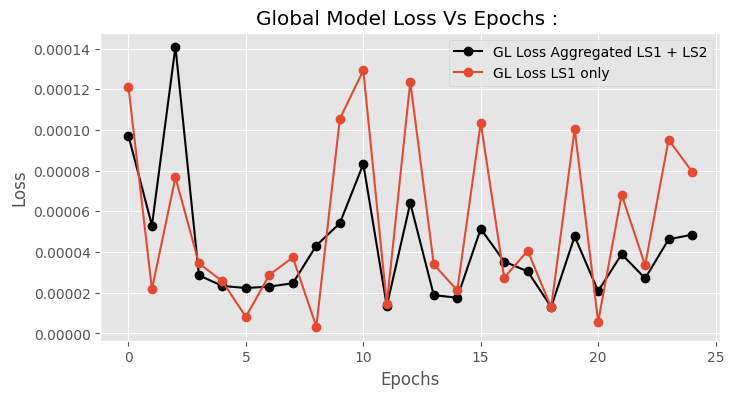

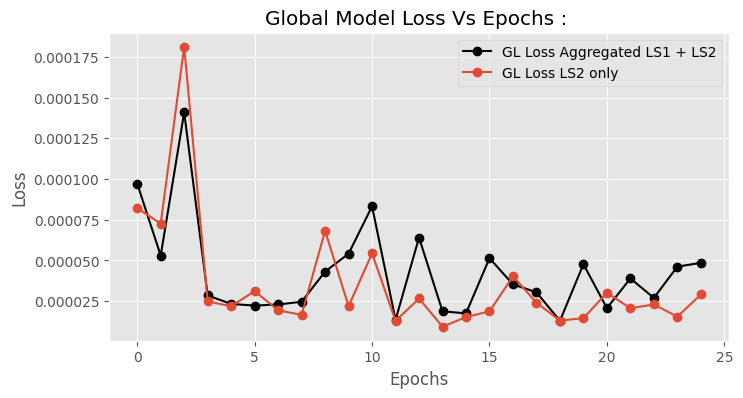

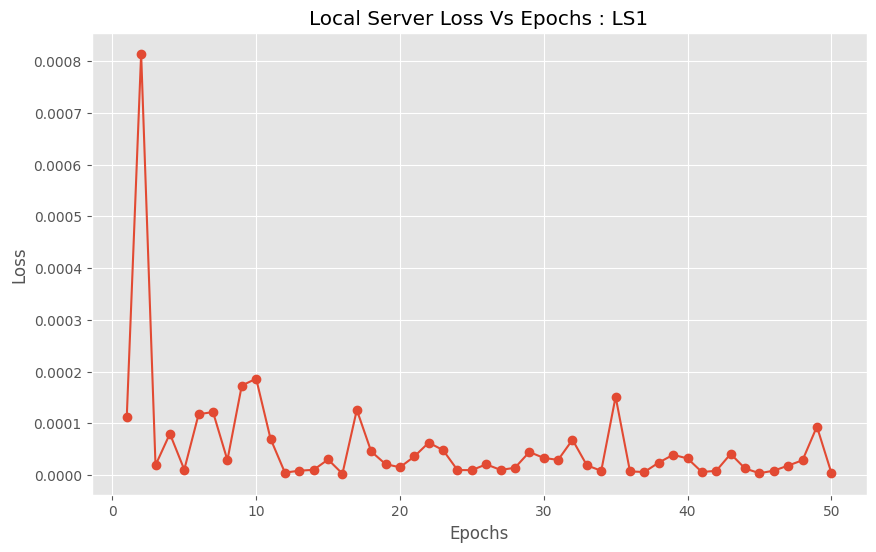

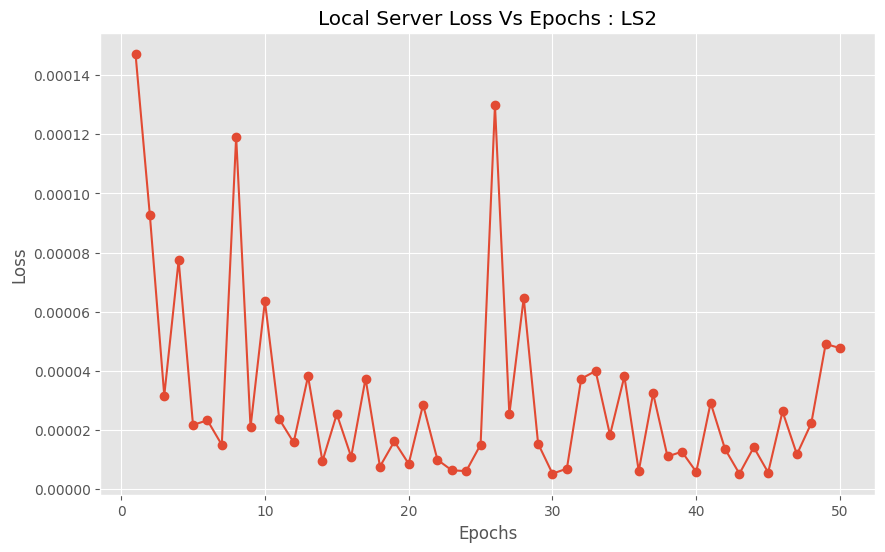

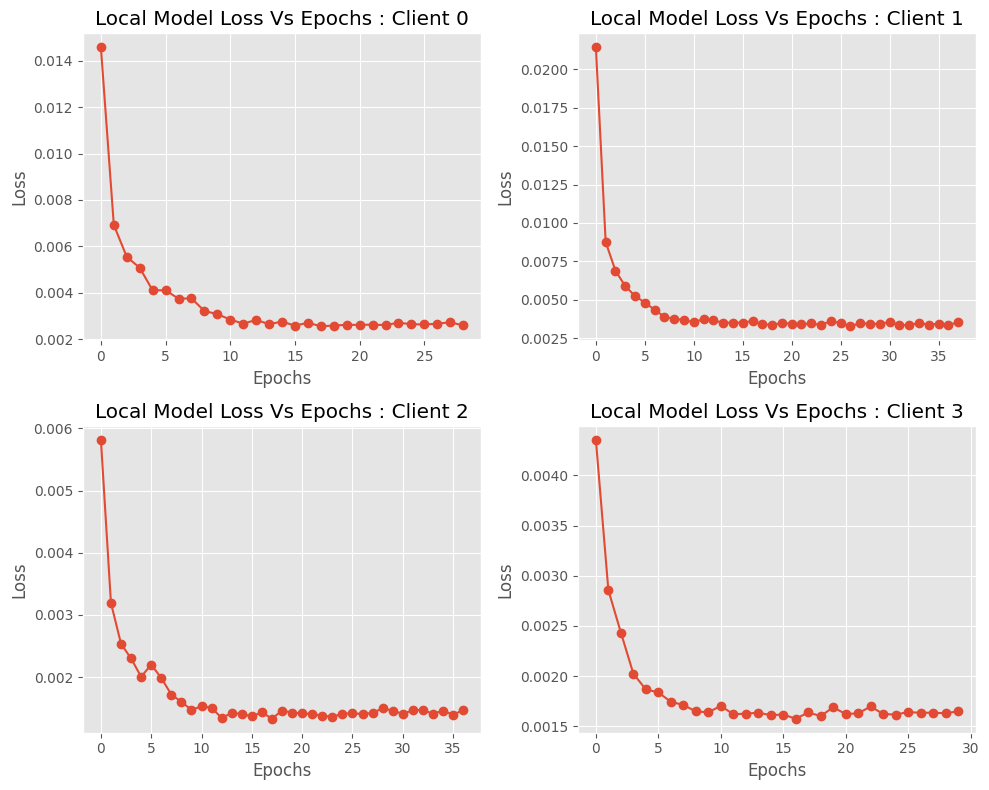

In [ ]:
plot_losses_global(losses_GL_LS1, 'LS1')
plot_losses_global(losses_GL_LS2, 'LS2')

plot_losses_local_server(losses_LS1, 'LS1')
plot_losses_local_server(losses_LS2, 'LS2')

plot_losses_local(epochs_losses)

## Federated Learning Model comparison

In [ ]:
def predictions_for_plotting(model, X_train, train_series, val_series, adjustment=True):
    """Generate predictions for training, validation, and test data using the given model for plotting purposes."""

    # Prepare the last input sequence from the training data
    last_input_seq_train = np.array([train_series[-N_STEPS_IN:]])
    # Predict on this sequence
    val_output = model.predict(last_input_seq_train, verbose=0)
    val_predictions = val_output.flatten().tolist()

    if adjustment:
        # Adjust the validation predictions by shifting them based on the last value of the input sequence
        val_first_pred = val_predictions[0]
        val_predictions = [x + (last_input_seq_train[0, -1, 0] - val_first_pred) for x in val_predictions]
        print(f"Shift Delta for first validation prediction: {round(abs(val_predictions[0] - val_first_pred), 5)}")

    # Prepare the last input sequence from the validation data
    last_input_seq_val = np.array([val_series[-N_STEPS_IN:]])
    # Predict on this sequence
    test_output = model.predict(last_input_seq_val, verbose=0)
    test_predictions = test_output.flatten().tolist()

    if adjustment:
        # Adjust the test predictions by shifting them based on the last value of the input sequence
        test_first_pred = test_predictions[0]
        test_predictions = [x + (last_input_seq_val[0, -1, 0] - test_first_pred) for x in test_predictions]
        print(f"Shift Delta for first test prediction: {round(abs(test_predictions[0] - test_first_pred), 5)}")

    # Generate predictions for the entire training data
    train_predictions = model.predict(X_train, verbose=0)[:, 0].flatten()

    # Convert predictions to numpy arrays
    val_predictions = np.array(val_predictions).flatten()
    test_predictions = np.array(test_predictions).flatten()

    return train_predictions, val_predictions, test_predictions


def plot(model, train_series, val_series, test_series, train_predictions, val_predictions, test_predictions, y_train, print_shape=False):
    """Plot the actual values and predictions for training, validation, and test datasets."""

    if print_shape:
        # Optionally print the shapes of the series and predictions
        print(f"train_series shape: {train_series.shape}")
        print(f"val_series shape: {val_series.shape}")
        print(f"test_series shape: {test_series.shape}")

        print(f"train_predictions shape: {np.array(train_predictions).shape}")
        print(f"val_predictions shape: {np.array(val_predictions).shape}")
        print(f"test_predictions shape: {np.array(test_predictions).shape}")


    plt.figure(figsize=(14, 7))

    # Plot actual training, validation, and test values
    plt.plot(np.arange(len(train_series)), train_series[:,0], label='Actual Training Values')
    plt.plot(np.arange(len(train_series), len(train_series) + len(val_series)), val_series[:,0], label='Actual Val Values')
    plt.plot(np.arange(len(train_series) + len(val_series), len(train_series) + len(val_series) + len(test_series)), test_series[:,0], label='Actual Test Values')

    # Plot input sequences used for testing validation and test predictions
    plt.plot(np.arange(len(train_series) - N_STEPS_IN, len(train_series)), train_series[-N_STEPS_IN:, 0], label='Input for Testing Validation')
    plt.plot(np.arange(len(train_series) + len(val_series) - N_STEPS_IN, len(train_series) + len(val_series)), val_series[-N_STEPS_IN:, 0], label='Input for Testing Test')

    # # Plot model predictions for training, validation, and test sets
    #plt.plot(np.arange(N_STEPS_IN, N_STEPS_IN + len(y_train)), train_predictions, label='Training Predictions')
    plt.plot(np.arange(len(train_series), len(train_series) + len(val_predictions)), val_predictions, label='Val Predictions')
    plt.plot(np.arange(len(train_series) + len(val_series), len(train_series) + len(val_series) + len(test_predictions)), test_predictions, label='Test Predictions')

    # Add vertical lines to mark the splits between training/validation and validation/test sets
    plt.axvline(x=len(train_series), color='r', linestyle='--', label='Train/Val Split')
    plt.axvline(x=len(train_series) + len(val_series), color='b', linestyle='--', label='Val/Test Split')

    # Display the legend and plot
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def cosine_similarity(w1, w2):
    """Calculate the cosine similarity between two weight matrices."""
    return np.dot(w1.flatten(), w2.flatten()) / (norm(w1.flatten()) * norm(w2.flatten()))


def euclidean_distance(w1, w2):
    """Calculate the Euclidean distance between two weight matrices."""
    return norm(w1.flatten() - w2.flatten())


def compare_models(weights1, weights2):
    """Compare two sets of model weights using cosine similarity and Euclidean distance."""
    cosine_similarities = []
    euclidean_distances = []

    # Iterate over each layer's weights in the two models
    for i, (w1, w2) in enumerate(zip(weights1, weights2)):
        cos_sim = cosine_similarity(w1, w2)  # Compute cosine similarity
        euc_dist = euclidean_distance(w1, w2)  # Compute Euclidean distance

        cosine_similarities.append(cos_sim)
        euclidean_distances.append(euc_dist)

    # Calculate mean and variance of cosine similarities
    mean_cos_sim = np.mean(cosine_similarities)
    var_cos_sim = np.var(cosine_similarities)

    # Calculate mean and variance of Euclidean distances
    mean_euc_dist = np.mean(euclidean_distances)
    var_euc_dist = np.var(euclidean_distances)

    # Return mean and variance for both metrics
    return mean_cos_sim, mean_euc_dist, var_cos_sim, var_euc_dist


def compare_and_display_model_matrix(params_list, model_names):
    """Compare model parameters and display cosine similarity and Euclidean distance matrices."""

    if len(model_names) != len(params_list):
        raise ValueError("Length of model_names must match length of params_list")

    # Initialize empty DataFrames for cosine similarity and Euclidean distance
    cosine_matrix = pd.DataFrame(index=model_names, columns=model_names)
    euclidean_matrix = pd.DataFrame(index=model_names, columns=model_names)

    # Compare each pair of models
    for i, params_1 in enumerate(params_list):
        for j, params_2 in enumerate(params_list):
            # Compute cosine similarity and Euclidean distance between models
            cosine, euclidean, _, _ = compare_models(params_1, params_2)

            # Store the rounded results in the matrices
            cosine_matrix.iloc[i, j] = round(cosine, 3)
            euclidean_matrix.iloc[i, j] = round(euclidean, 3)

    print("Cosine Similarity Matrix:")
    print(cosine_matrix)

    print("\nEuclidean Distance Matrix:")
    print(euclidean_matrix)

    return cosine_matrix, euclidean_matrix

In [ ]:
def evaluate(X, y, model):
    mae, mse, rmse, mape, _ = evaluate_model(model, (X, y), VERSION)
    return round(mse*100000, 2), round(mae*100000, 2)


def evaluate_test_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, train_series, val_series, test_series, title, do_plot=False):
    """Evaluate the model on training, validation, and test sets, and optionally plot the results."""

    train_mse, train_mae = evaluate(X_train, y_train, model)
    test_mse, test_mae = evaluate(X_test, y_test, model)
    val_mse, val_mae = evaluate(X_val, y_val, model)

    if do_plot:
        # If plotting is enabled, print the title
        print(title)
        # Generate predictions for plotting
        train_predictions, val_predictions, test_predictions = predictions_for_plotting(model, X_train, train_series, val_series)
        # Plot the actual vs. predicted values
        plot(model, train_series, val_series, test_series, train_predictions, val_predictions, test_predictions, y_train)

    # Return the evaluation metrics
    return train_mse, train_mae, test_mse, test_mae, val_mse, val_mae


In [ ]:
def compare_methods():
    """Compare models (Global, LS1, LS2, Local) across multiple clients and record errors."""

    # Initialize error matrix
    error_matrix = pd.DataFrame(index=[f"Client {i}" for i in range(4)], columns=["Global Model", "LS1 Model", "LS2 Model", "Local Model"])
    losses = []

    for client_id, df in client_data.items():
        loss = []
        print(f"Client ID: {client_id}")

        # Prepare data for the current client
        X_train, y_train, X_val, y_val, X_test, y_test, train_series, val_series, test_series = data_preparation(df, VERSION, N_STEPS_IN, N_STEPS_OUT, TRAIN_SIZE, VAL_SIZE)

        print(f"Train samples: {len(X_train)}, Val samples: {len(X_val)}, Test samples: {len(X_test)}")

        model = build_model()

        # Evaluate the global model on the client's data
        model.set_weights(params_GL)
        train_mse, train_mae, test_mse, test_mae, val_mse, val_mae = evaluate_test_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, train_series, val_series, test_series, "Global Model" + f" : Client ID: {client_id}", do_plot=True)
        loss.append([train_mse, val_mse, test_mse, train_mae, val_mae, test_mae])
        error_matrix.iloc[client_id, 0] = f"Train:{train_mse}, Val: {val_mse}, Test:{test_mse}"

        # Evaluate the LS1 model on the client's data
        model.set_weights(params_LS1)
        train_mse, train_mae, test_mse, test_mae, val_mse, val_mae = evaluate_test_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, train_series, val_series, test_series, "LS1 Model" + f" : Client ID: {client_id}", do_plot=True)
        loss.append([train_mse, val_mse, test_mse, train_mae, val_mae, test_mae])
        error_matrix.iloc[client_id, 1] = f"Train:{train_mse}, Val: {val_mse}, Test:{test_mse}"

        # Evaluate the LS2 model on the client's data
        model.set_weights(params_LS2)
        train_mse, train_mae, test_mse, test_mae, val_mse, val_mae = evaluate_test_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, train_series, val_series, test_series, "LS2 Model" + f" : Client ID: {client_id}", do_plot=True)
        loss.append([train_mse, val_mse, test_mse, train_mae, val_mae, test_mae])
        error_matrix.iloc[client_id, 2] = f"Train:{train_mse}, Val: {val_mse}, Test:{test_mse}"

        # Evaluate the local model on the client's data
        model = models[client_id]
        train_mse, train_mae, test_mse, test_mae, val_mse, val_mae = evaluate_test_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, train_series, val_series, test_series, "Local Model" + f" : Client ID: {client_id}", do_plot=True)
        loss.append([train_mse, val_mse, test_mse, train_mae, val_mae, test_mae])
        error_matrix.iloc[client_id, 3] = f"Train:{train_mse}, Val: {val_mse}, Test:{test_mse}"

        # Store losses for comparison
        losses.append(loss)

    print("\nError * 10e5 for better visibility\n")
    print(error_matrix.to_string(index=True))

    return losses, error_matrix


In [ ]:
#Load models
params_list = [params_GL, params_LS1, params_LS2] + [get_parameters(model) for model in models]
model_names = ["Global Model", "LS1 Model", "LS2 Model"] + [f"Model {i}" for i in range(len(models))]

Client ID: 0
Train samples: 1031, Val samples: 41, Test samples: 41
Global Model : Client ID: 0
Shift Delta for first validation prediction: 0.00691
Shift Delta for first test prediction: 0.00743


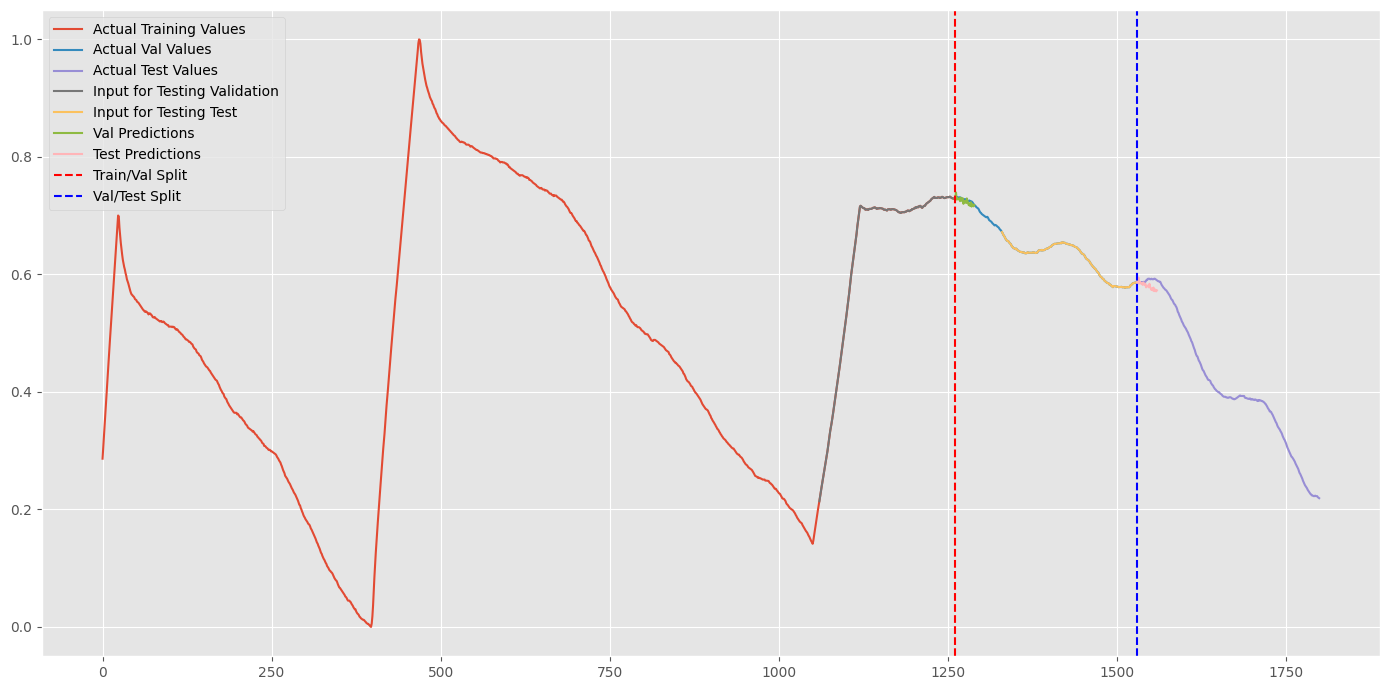

LS1 Model : Client ID: 0
Shift Delta for first validation prediction: 0.01332
Shift Delta for first test prediction: 0.01135


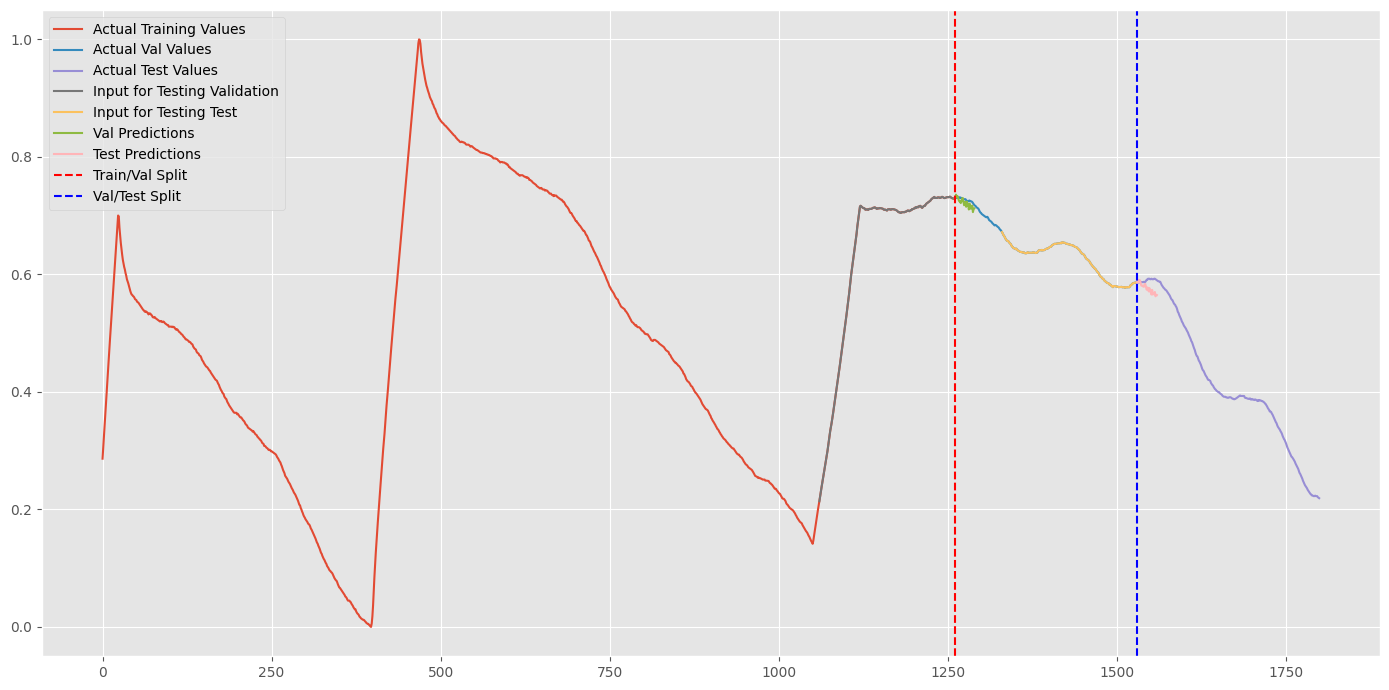

LS2 Model : Client ID: 0
Shift Delta for first validation prediction: 0.00389
Shift Delta for first test prediction: 0.0021


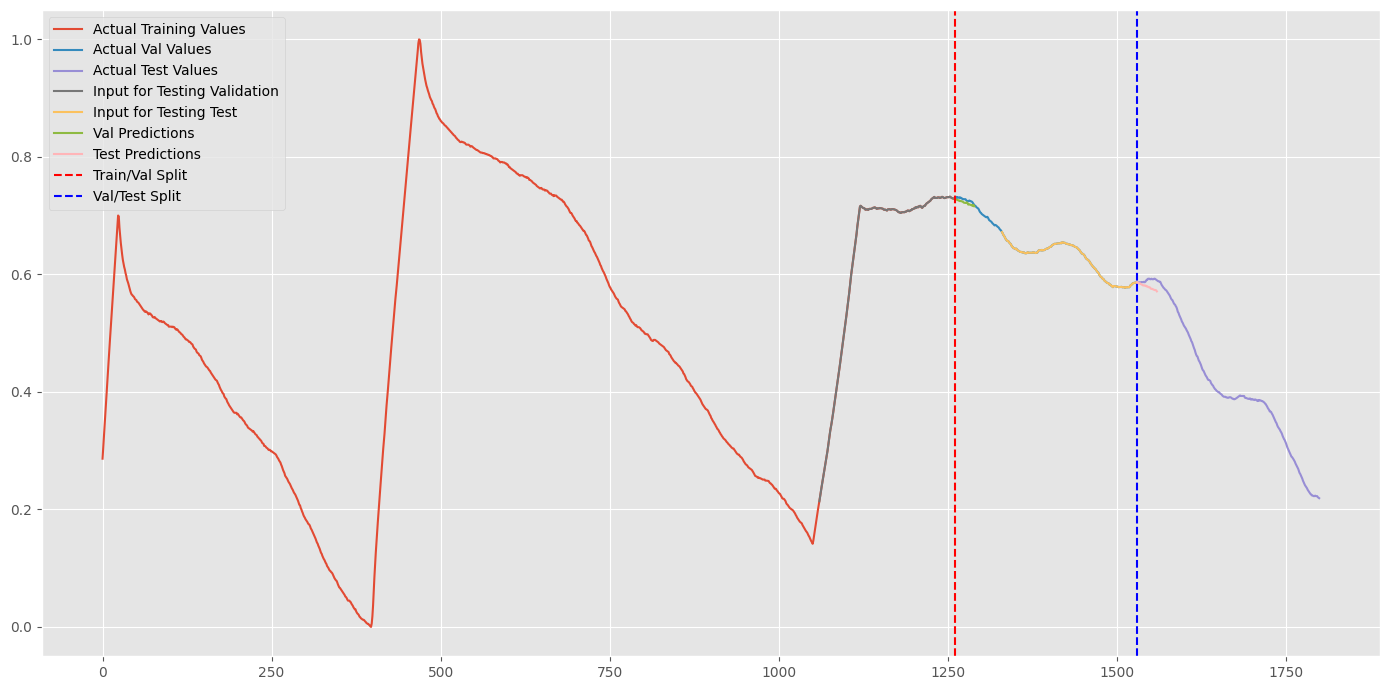

Local Model : Client ID: 0
Shift Delta for first validation prediction: 0.00827
Shift Delta for first test prediction: 0.00585


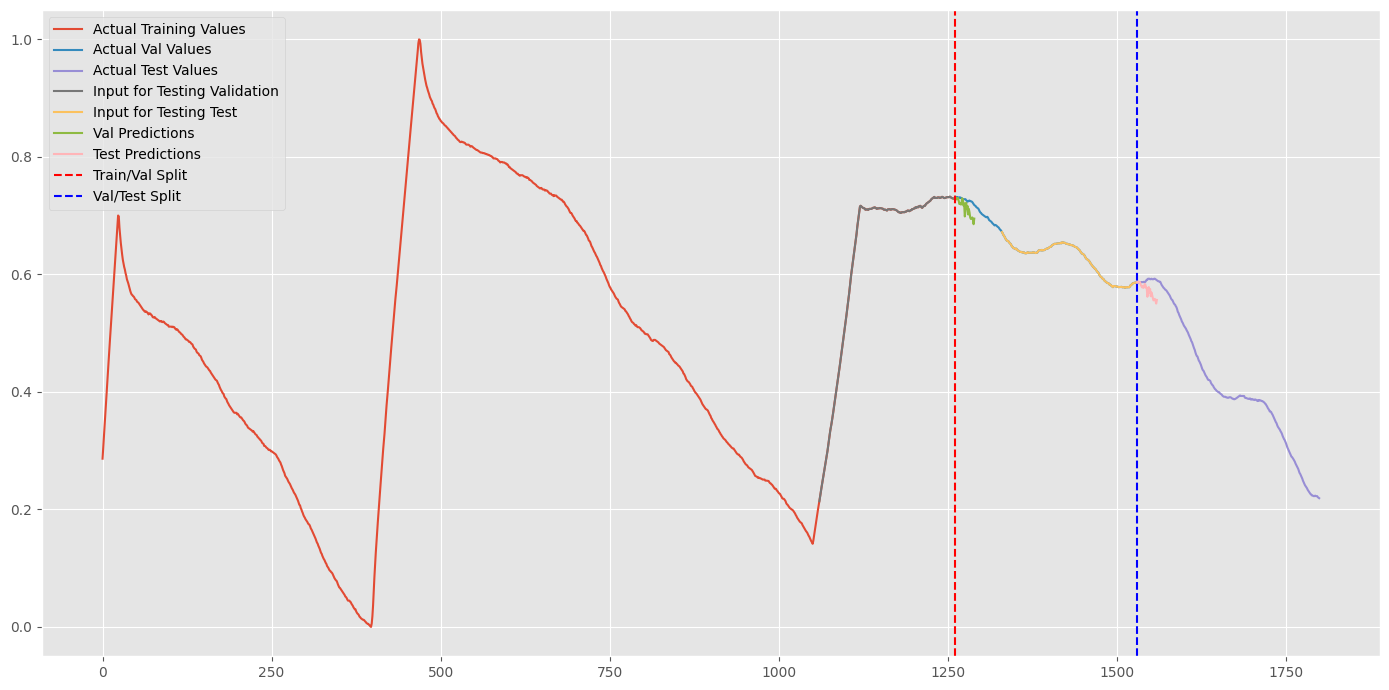

Client ID: 1
Train samples: 947, Val samples: 23, Test samples: 24
Global Model : Client ID: 1
Shift Delta for first validation prediction: 0.00977
Shift Delta for first test prediction: 0.00634


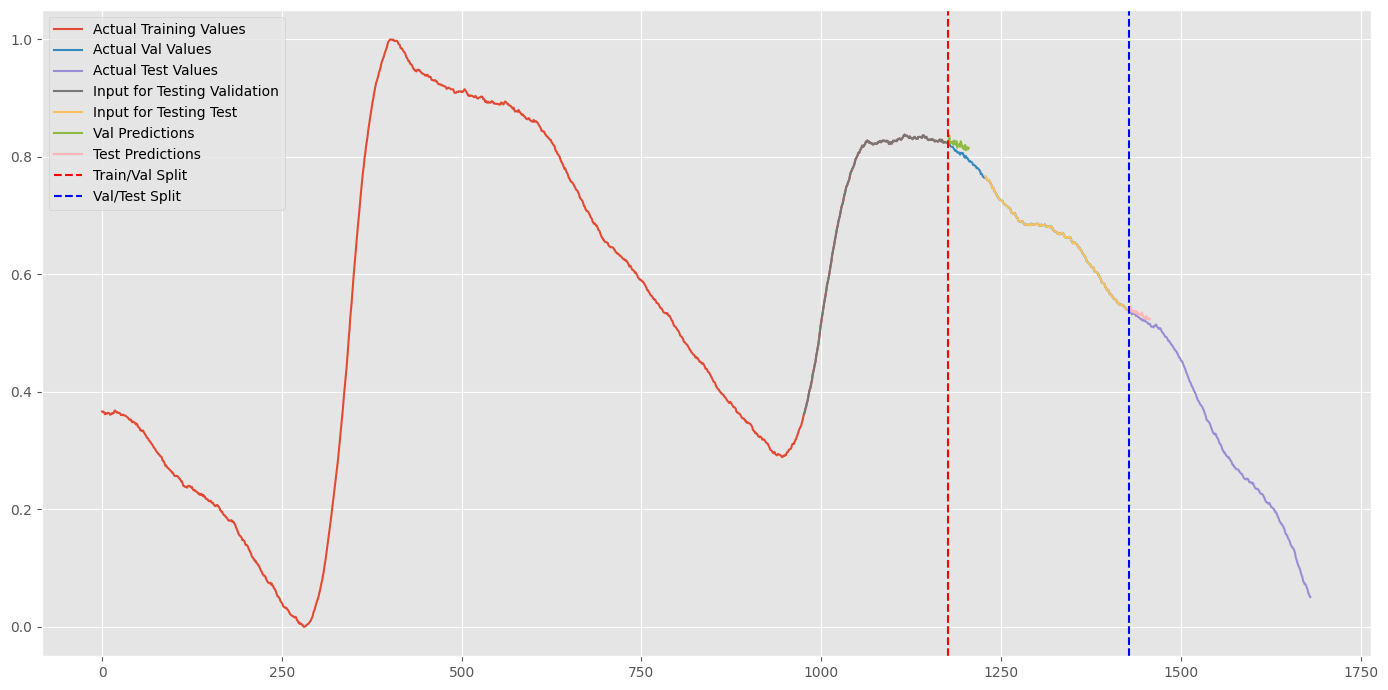

LS1 Model : Client ID: 1
Shift Delta for first validation prediction: 0.01778
Shift Delta for first test prediction: 0.00807


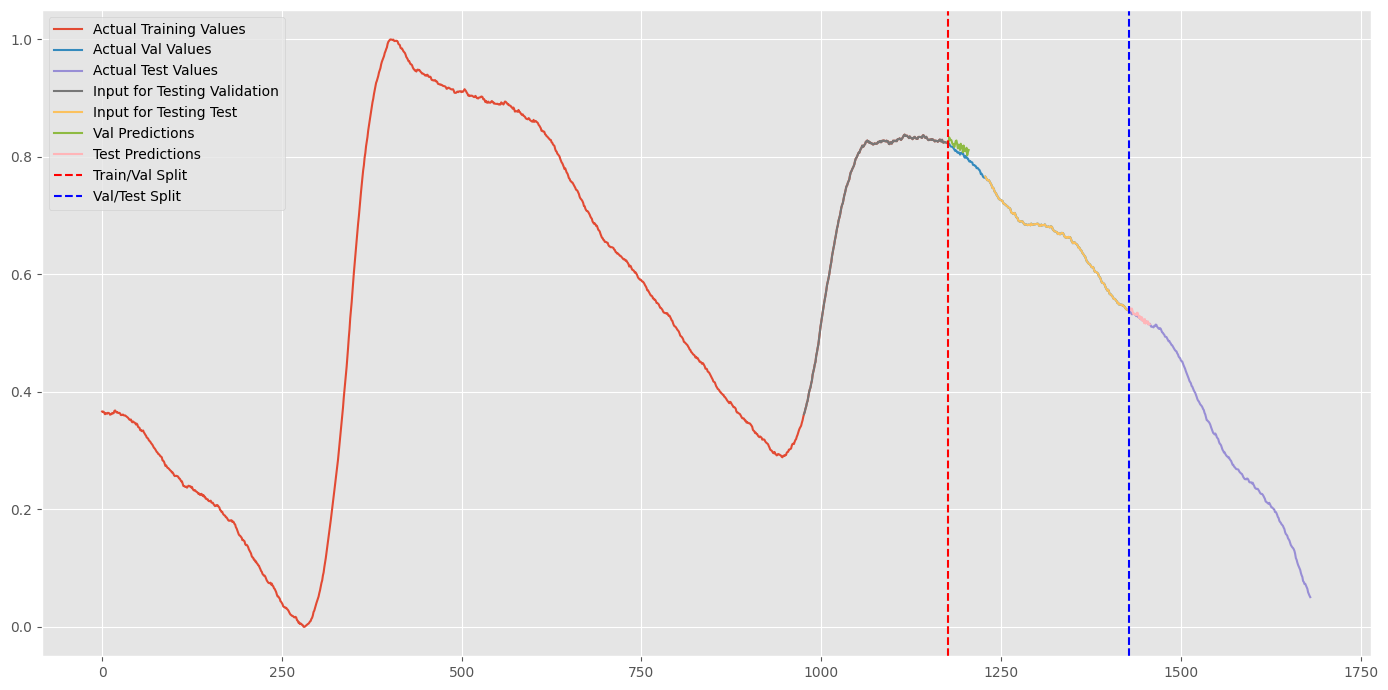

LS2 Model : Client ID: 1
Shift Delta for first validation prediction: 0.00625
Shift Delta for first test prediction: 0.00315


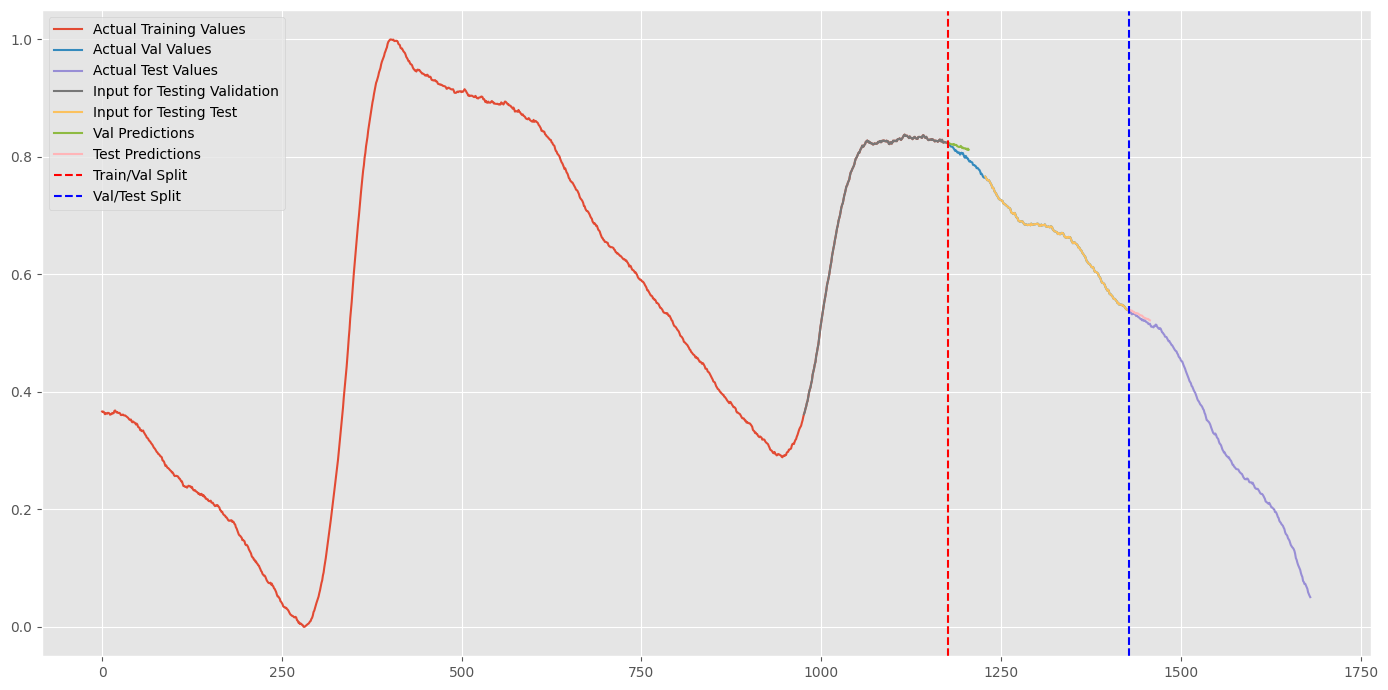

Local Model : Client ID: 1
Shift Delta for first validation prediction: 0.0172
Shift Delta for first test prediction: 0.01666


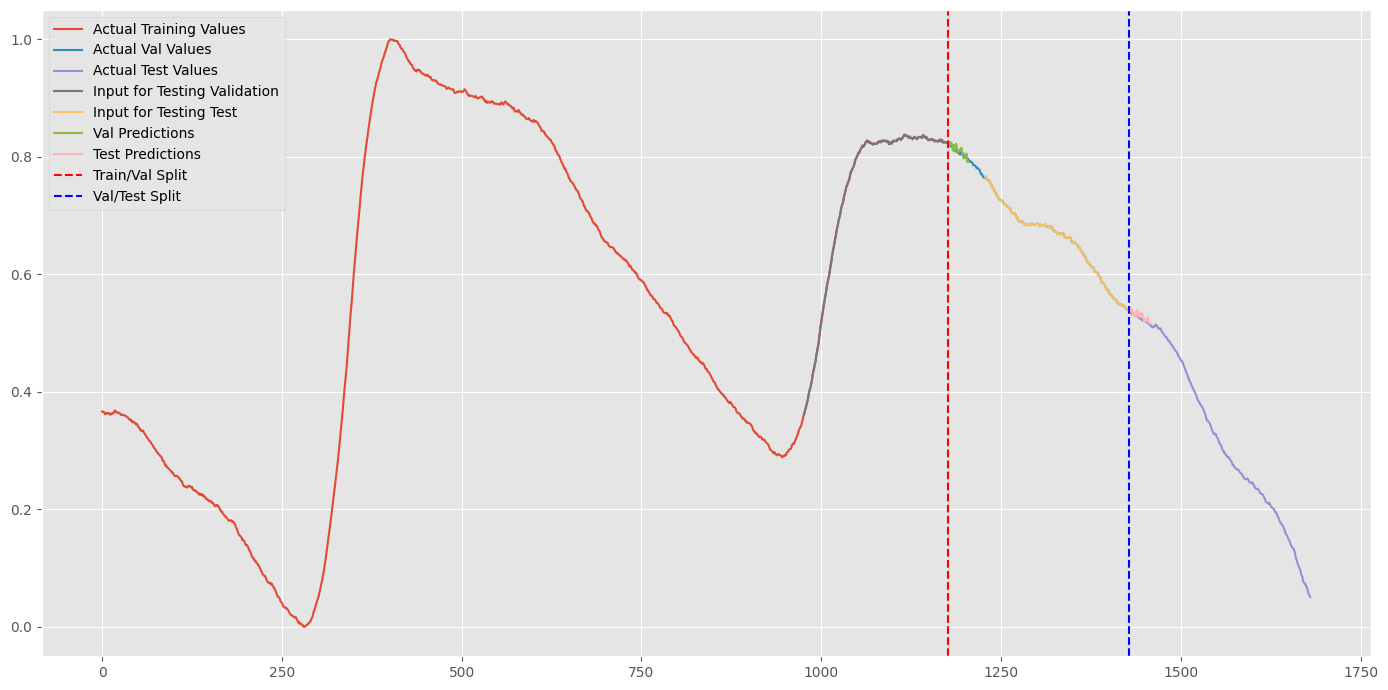

Client ID: 2
Train samples: 1625, Val samples: 169, Test samples: 169
Global Model : Client ID: 2
Shift Delta for first validation prediction: 0.01427
Shift Delta for first test prediction: 0.00351


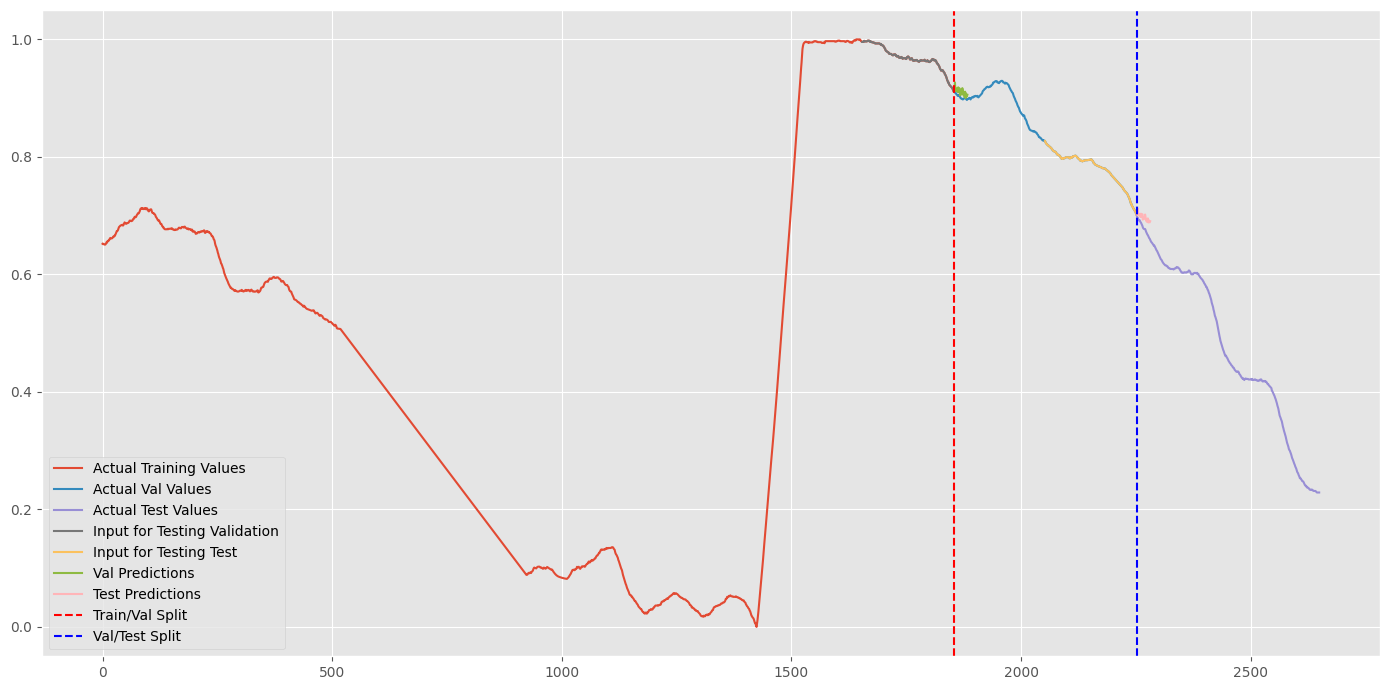

LS1 Model : Client ID: 2
Shift Delta for first validation prediction: 0.02077
Shift Delta for first test prediction: 0.00911


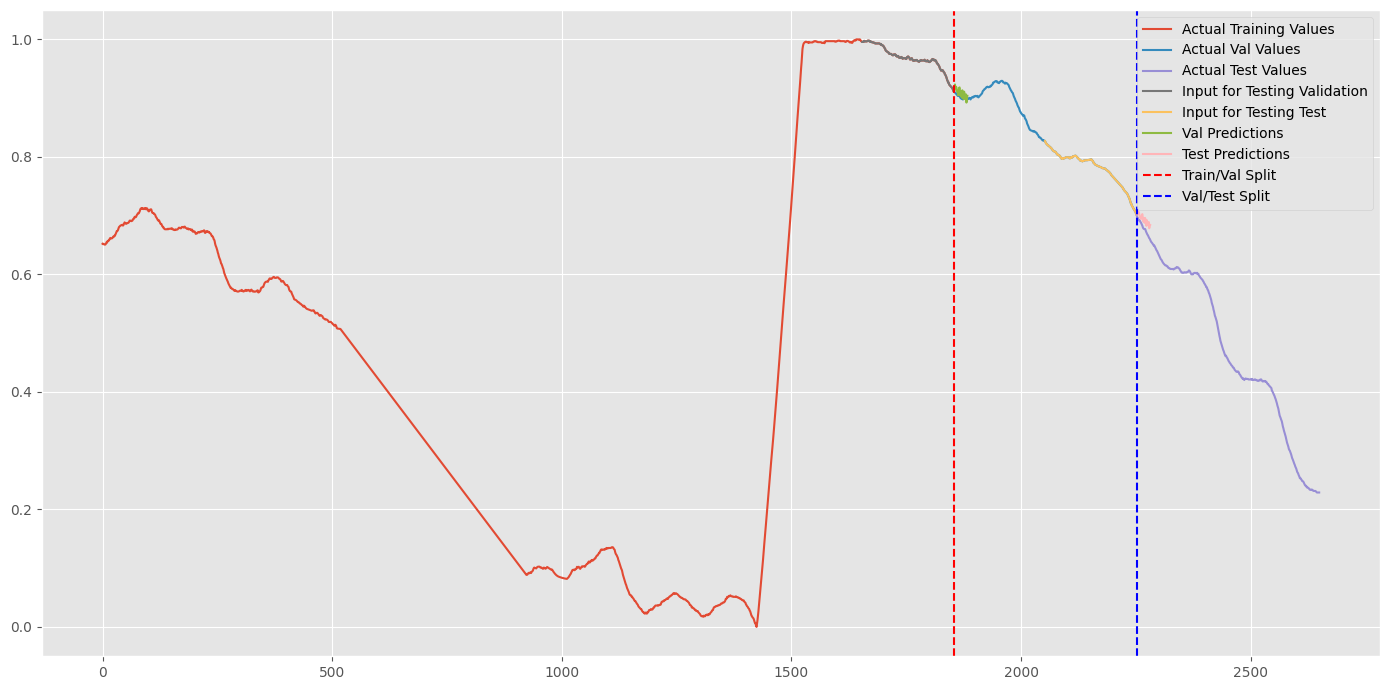

LS2 Model : Client ID: 2
Shift Delta for first validation prediction: 0.00774
Shift Delta for first test prediction: 0.00116


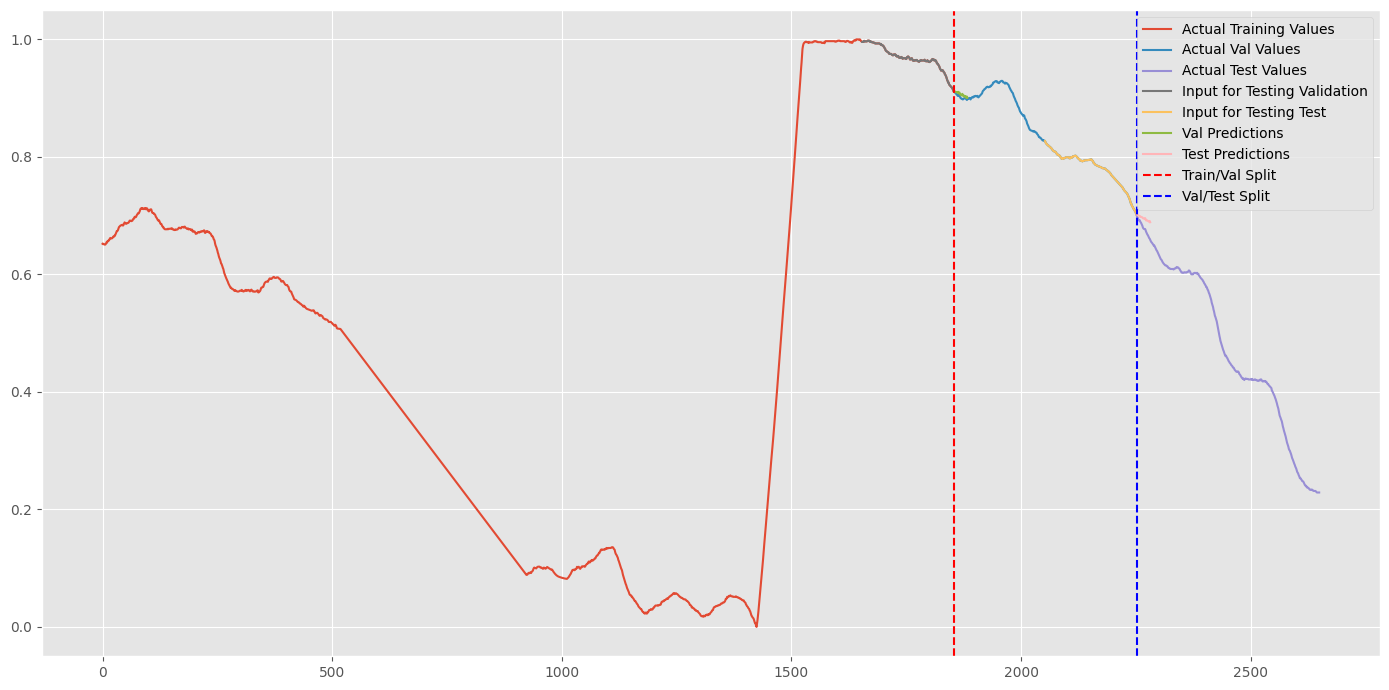

Local Model : Client ID: 2
Shift Delta for first validation prediction: 0.00657
Shift Delta for first test prediction: 0.00952


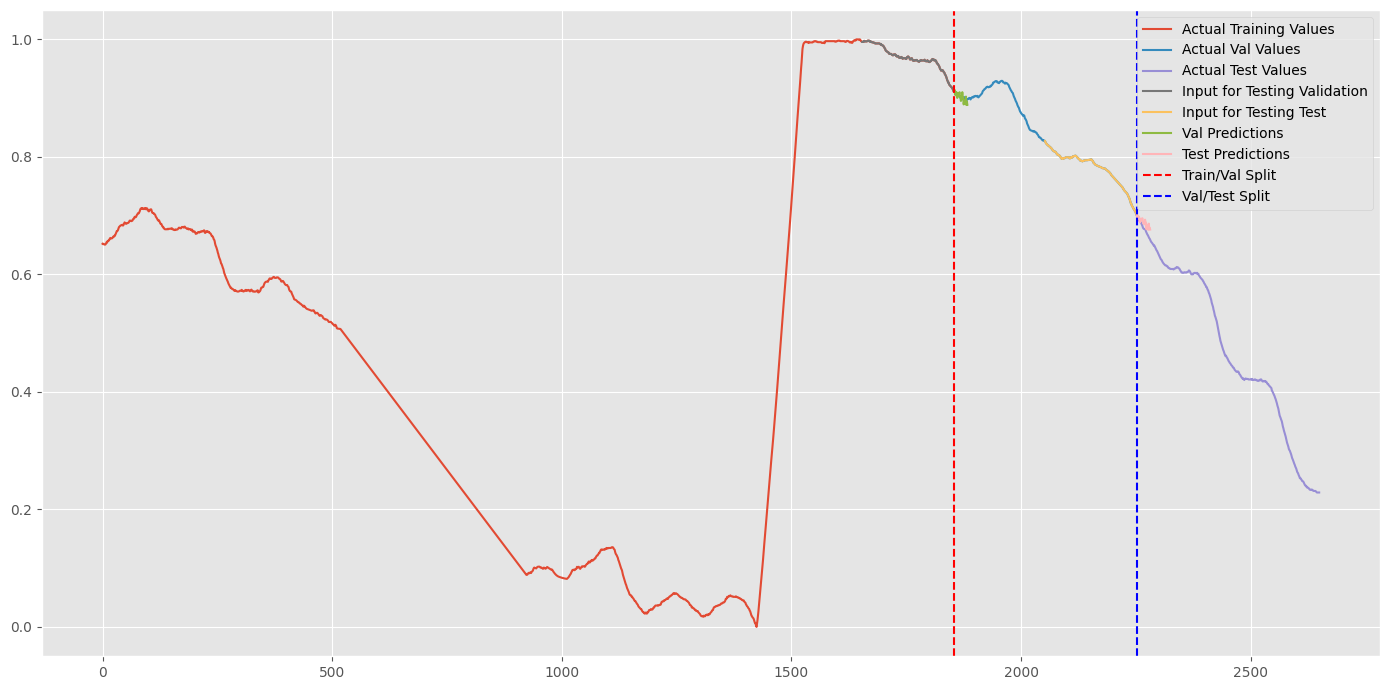

Client ID: 3
Train samples: 1800, Val samples: 207, Test samples: 206
Global Model : Client ID: 3
Shift Delta for first validation prediction: 0.00519
Shift Delta for first test prediction: 0.00677


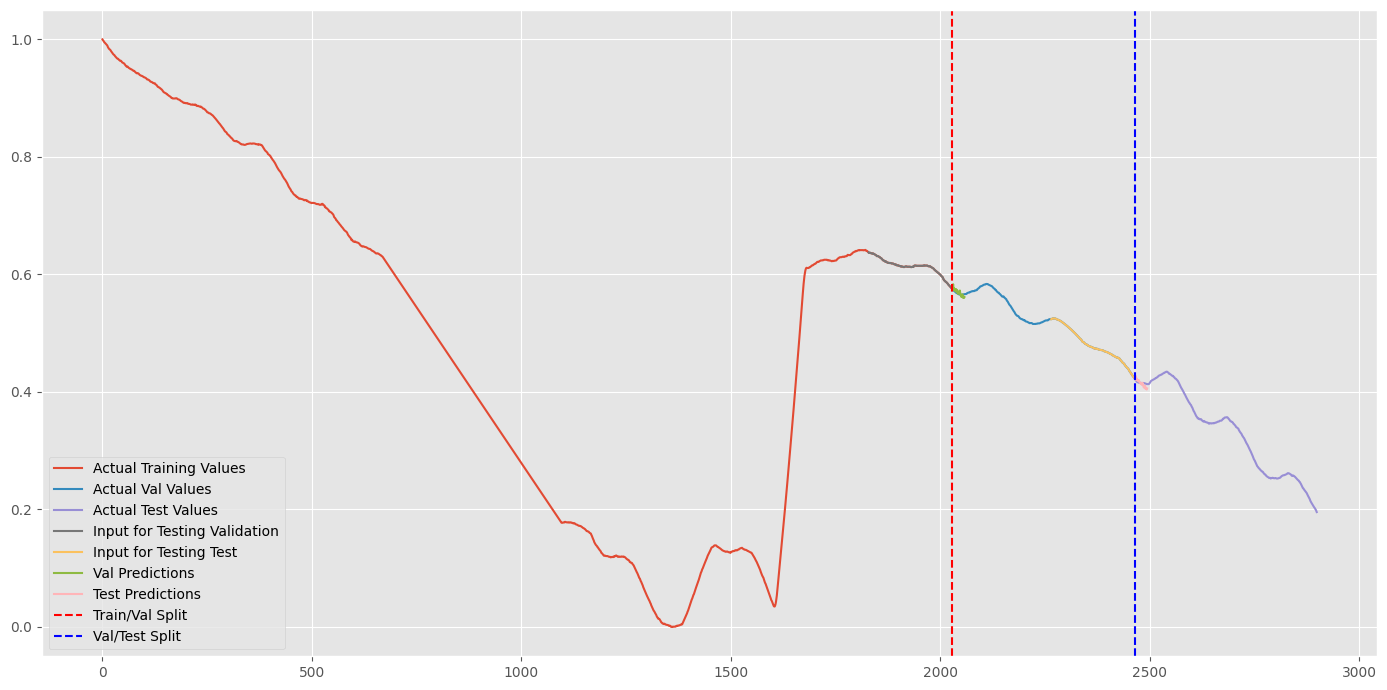

LS1 Model : Client ID: 3
Shift Delta for first validation prediction: 0.0081
Shift Delta for first test prediction: 0.00593


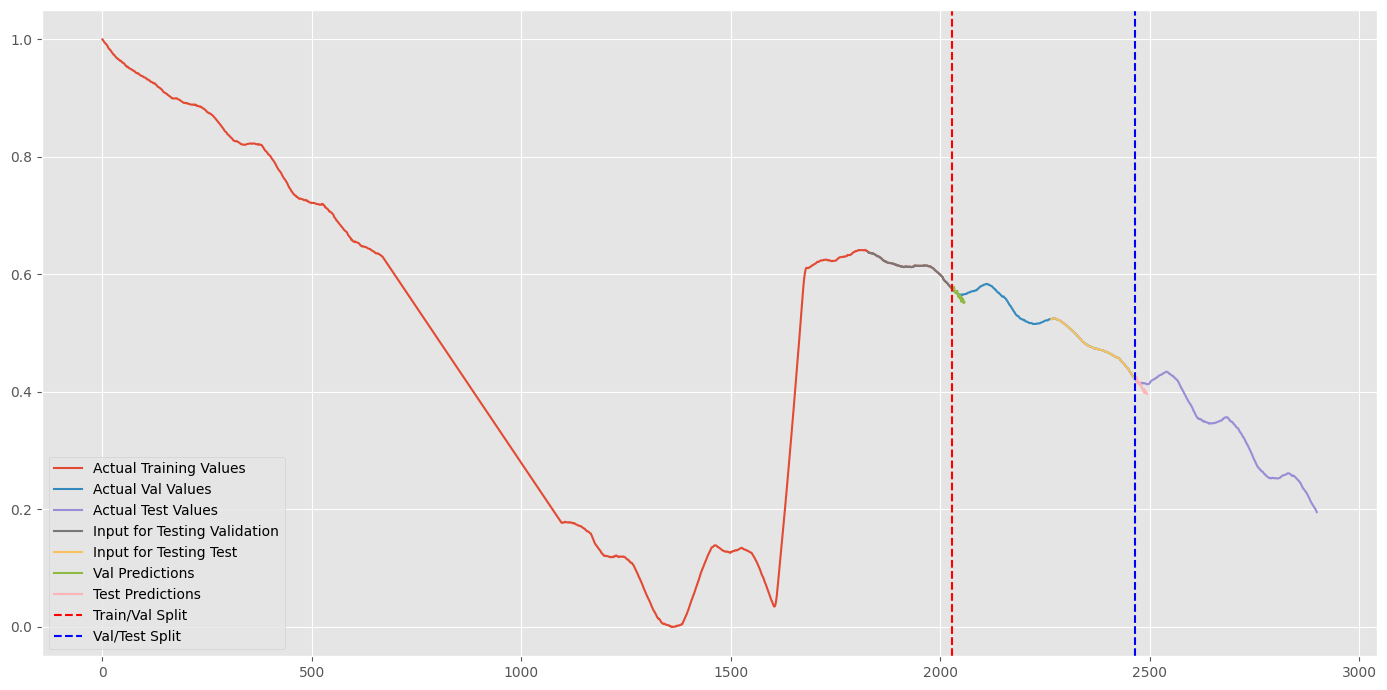

LS2 Model : Client ID: 3
Shift Delta for first validation prediction: 0.00081
Shift Delta for first test prediction: 0.0029


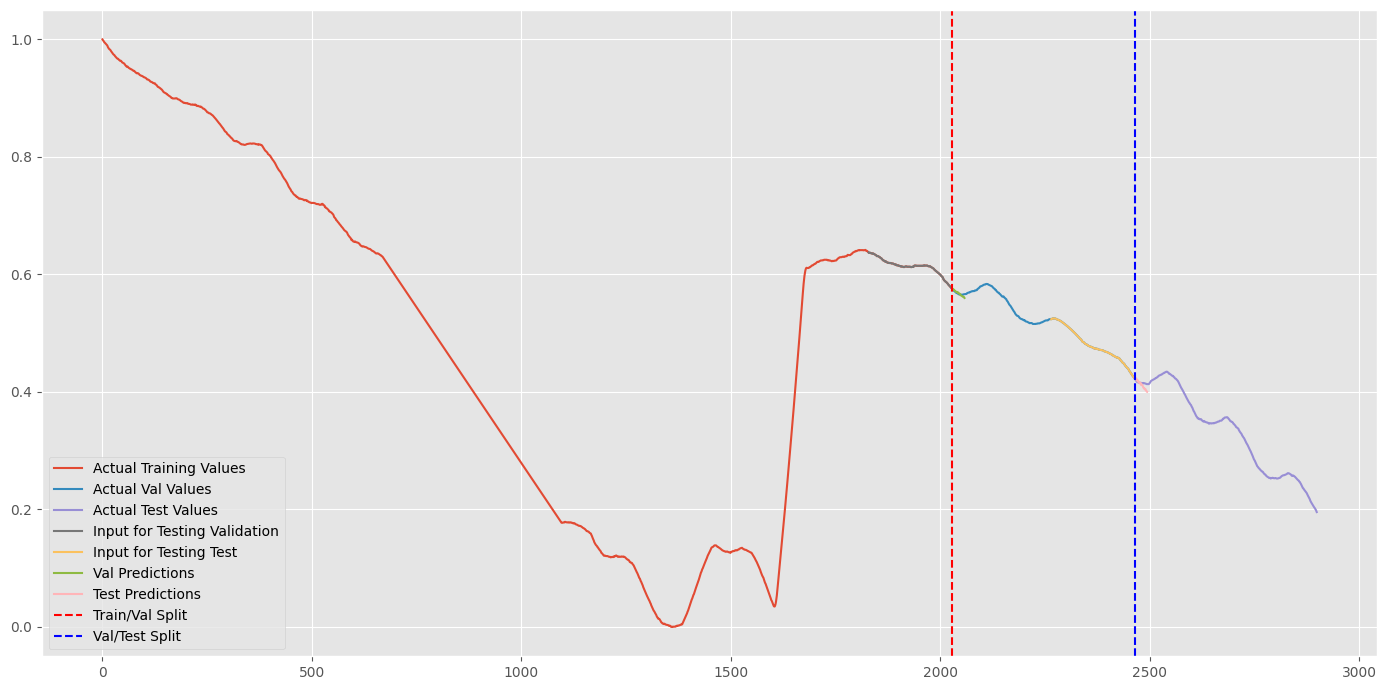

Local Model : Client ID: 3
Shift Delta for first validation prediction: 0.00226
Shift Delta for first test prediction: 0.00489


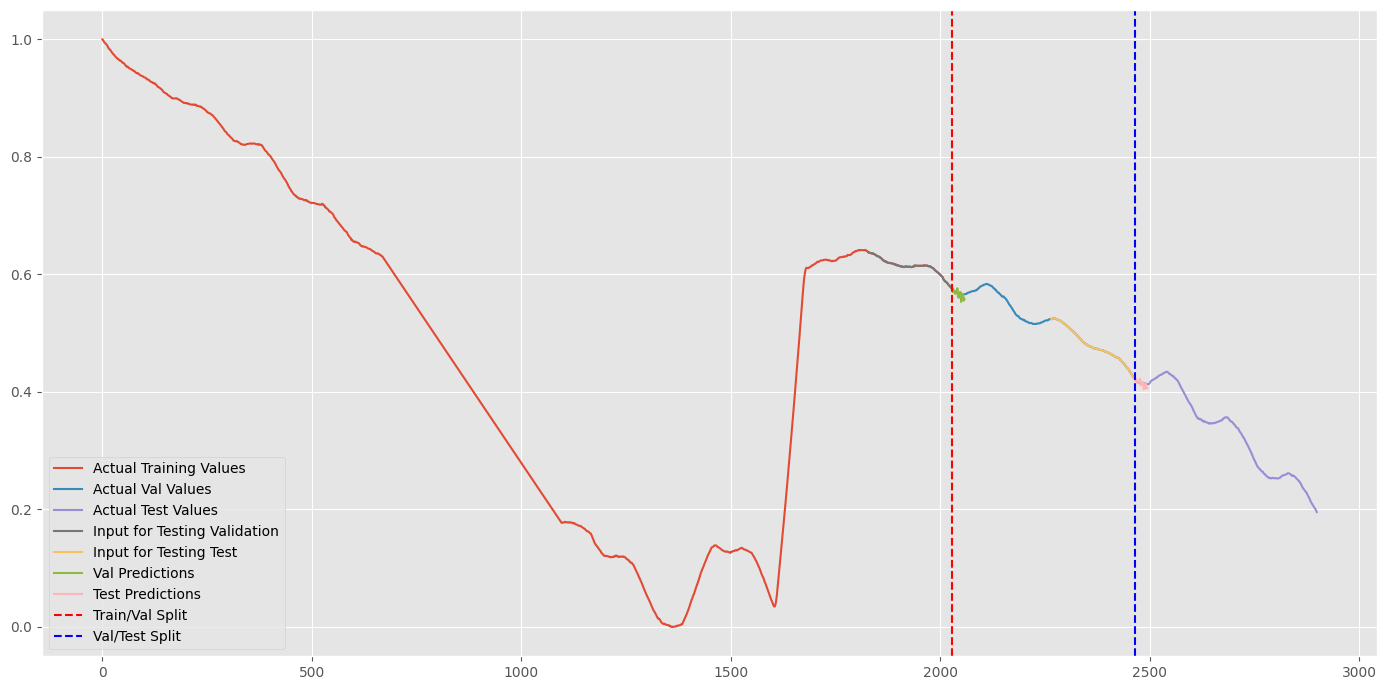


Error * 10e5 for better visibility

                               Global Model                          LS1 Model                         LS2 Model                         Local Model
Client 0  Train:11.65, Val: 1.51, Test:0.43  Train:15.45, Val: 4.79, Test:0.21  Train:5.54, Val: 0.16, Test:0.56   Train:27.05, Val: 8.42, Test:0.35
Client 1  Train:17.64, Val: 0.53, Test:1.23  Train:27.07, Val: 2.26, Test:0.34  Train:8.17, Val: 0.84, Test:1.57  Train:33.21, Val: 9.21, Test:33.67
Client 2   Train:19.22, Val: 6.6, Test:3.03  Train:26.36, Val: 23.99, Test:2.8  Train:9.07, Val: 2.25, Test:0.77    Train:5.93, Val: 1.23, Test:5.55
Client 3     Train:4.72, Val: 4.7, Test:1.7   Train:74.55, Val: 6.35, Test:5.5    Train:3.74, Val: 1.1, Test:0.3   Train:15.27, Val: 6.09, Test:6.43


Cosine Similarity Matrix:
             Global Model LS1 Model LS2 Model Model 0 Model 1 Model 2 Model 3
Global Model          1.0     0.945     0.955   0.905   0.903   0.917   0.925
LS1 Model           0.945       1.

In [ ]:
losses, error_matrix = compare_methods()
print("\n")
cosine_matrix, euclidean_matrix = compare_and_display_model_matrix(params_list, model_names)

In [ ]:
def plot_client_losses(losses, error_matrix):
    """Plot training, validation, and test losses for each client across different models."""

    num_clients = len(losses)
    models = ["Global Model", "LS1 Model", "LS2 Model", "Local Model"]
    loss_types = ['Train', 'Val', 'Test']

    for client_id in range(num_clients):
        # Extract losses for the current client
        client_losses = np.array(losses[client_id])
        client_losses = client_losses[:, :3]

        if client_losses.ndim == 1:
            raise ValueError(f"Expected 2D array for client_losses, but got 1D array for Client {client_id}")

        if client_losses.ndim != 2 or client_losses.shape[1] != len(loss_types):
            raise ValueError(f"Expected 2D array with {len(loss_types)} columns (for Train, Val, Test losses) "
                             f"for Client {client_id}, but got shape {client_losses.shape}")

        # Create subplots: one for all losses (Train, Val, Test) and one for Test loss only
        fig, axs = plt.subplots(1, 2, figsize=(12, 3))
        bar_width = 0.2
        index = np.arange(len(models))


        # Plot Train, Val, and Test losses for each model
        for i, loss_type in enumerate(loss_types):
            axs[0].bar(index + i * bar_width, client_losses[:, i], bar_width, label=loss_type)

        # Set titles and labels for the first subplot
        axs[0].set_title(f"Client {client_id}: Train, Val, and Test Losses")
        axs[0].set_xlabel("Model")
        axs[0].set_ylabel("Loss")
        axs[0].set_xticks(index + bar_width)
        axs[0].set_xticklabels(models)
        axs[0].legend()

        # Plot Test loss for each model
        test_losses = client_losses[:, 2]
        axs[1].bar(models, test_losses, color = ['darkred', 'royalblue', 'mediumpurple', 'darkorange'])

        # Set titles and labels for the second subplot
        axs[1].set_title(f"Client {client_id}: Test Loss")
        axs[1].set_xlabel("Model")
        axs[1].set_ylabel("Test Loss")

        # Adjust layout and display the plots
        plt.tight_layout()
        plt.grid(True)
        plt.show()


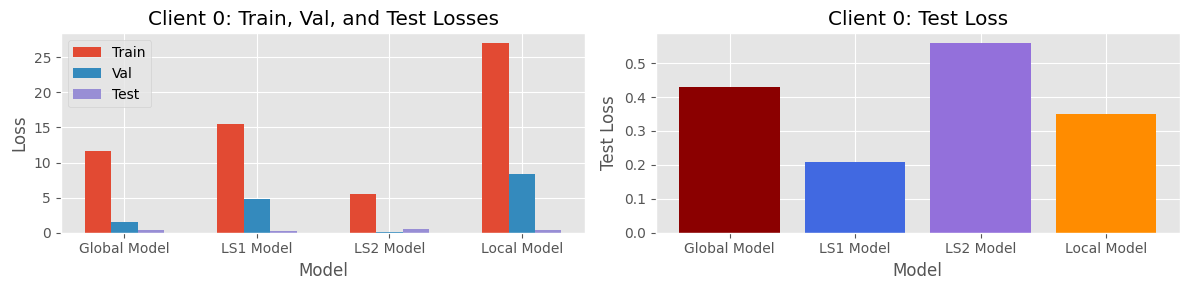

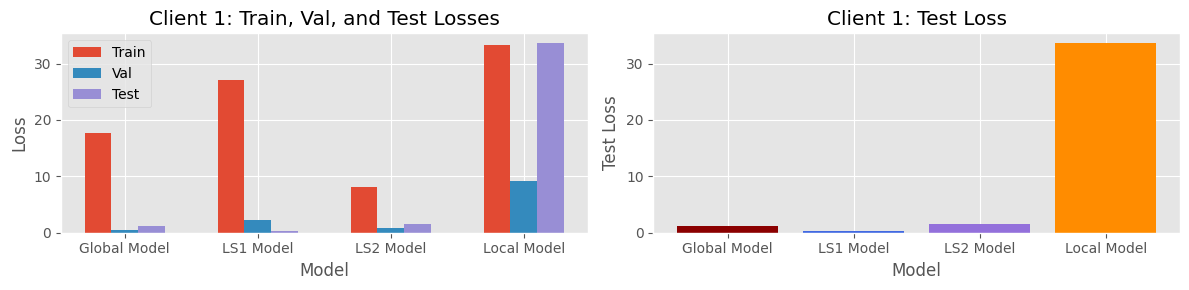

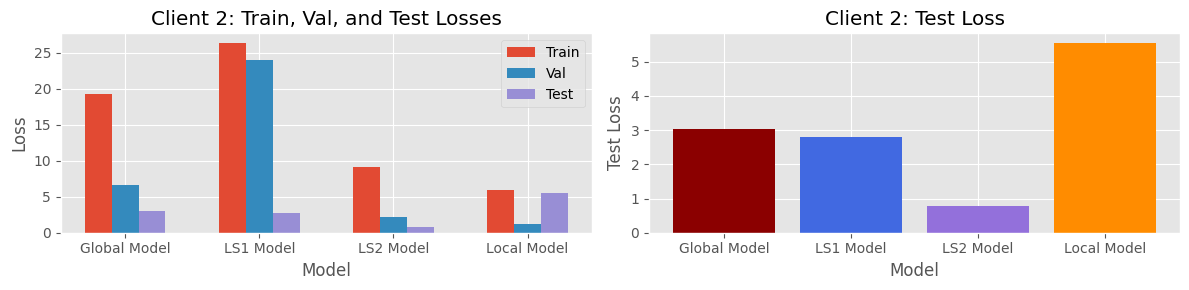

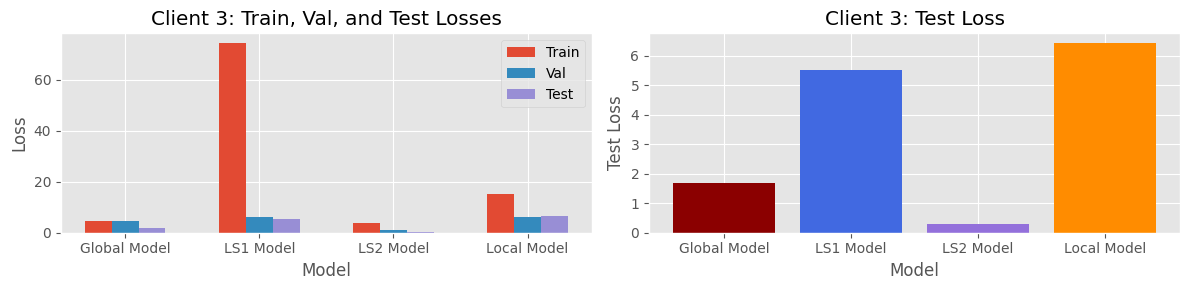

In [ ]:
plot_client_losses(losses, error_matrix)

In [ ]:
# Mapping of loss types to their corresponding indices
loss_plot = {
    'train_mse': 0,
    'val_mse': 1,
    'test_mse': 2,
    'train_mae': 3,
    'val_mae': 4,
    'test_mae': 5
}


def matrix_distance_selection_for_plot(df):
    """Select the first three rows of the specified columns from the matrix and transpose them into a list to create the submatrix of interest."""

    selected_columns = df[['Model 0', 'Model 1', 'Model 2', 'Model 3']]
    first_three_rows = selected_columns.iloc[:3]
    result_list = first_three_rows.transpose().values.tolist()
    return result_list


def plot_result_losses_vs_similarity(cosine_matrix, euclidean_matrix, losses, loss):
    """Plot the specified loss against cosine and Euclidean similarity with local model for each client."""

    # Prepare lists of cosine and Euclidean similarities
    list_cosine = matrix_distance_selection_for_plot(cosine_matrix)
    list_euclidean = matrix_distance_selection_for_plot(euclidean_matrix)

    nb = loss_plot[loss]  # Get the index corresponding to the selected loss

    # Plot Loss vs. Cosine Similarity
    for client_id in client_data:
        x_values = list_cosine[client_id]
        y_values = [value[nb] for value in losses[client_id]]
        y_values = y_values[:-1]  # Exclude the last value for comparison
        sorted_pairs = sorted(zip(x_values, y_values))
        sorted_x, sorted_y = zip(*sorted_pairs)
        plt.plot(sorted_x, sorted_y, label=f'Client {client_id}', marker='o')

    plt.xlabel('Cosine Similarity with Local Model')
    plt.ylabel('Loss : ' + loss)
    plt.title('Loss vs Cosine Similarity')
    plt.legend()
    plt.show()

    # Plot Loss vs. Euclidean Similarity
    for client_id in client_data:
        x_values = list_euclidean[client_id]
        y_values = [value[nb] for value in losses[client_id]]
        y_values = y_values[:-1]  # Exclude the last value for comparison
        sorted_pairs = sorted(zip(x_values, y_values))
        sorted_x, sorted_y = zip(*sorted_pairs)
        plt.plot(sorted_x, sorted_y, label=f'Client {client_id}', marker='o')

    plt.xlabel('Euclidean Similarity with Local Model')
    plt.ylabel('Loss : ' + loss)
    plt.title('Loss vs Euclidean Similarity')
    plt.legend()
    plt.grid(True)
    plt.show()


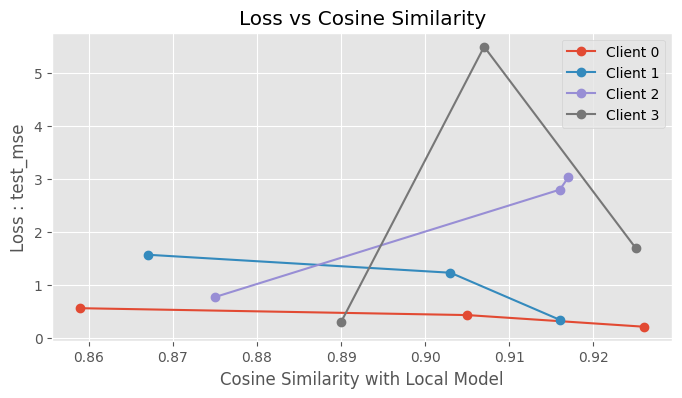

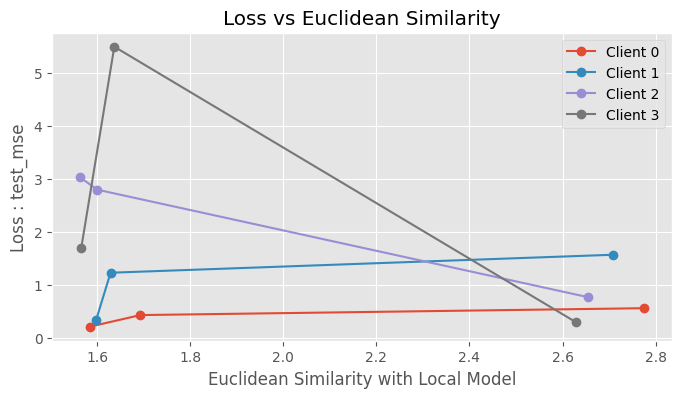

In [ ]:
plot_result_losses_vs_similarity(cosine_matrix, euclidean_matrix, losses, 'test_mse')

#DRAFTS (not working)


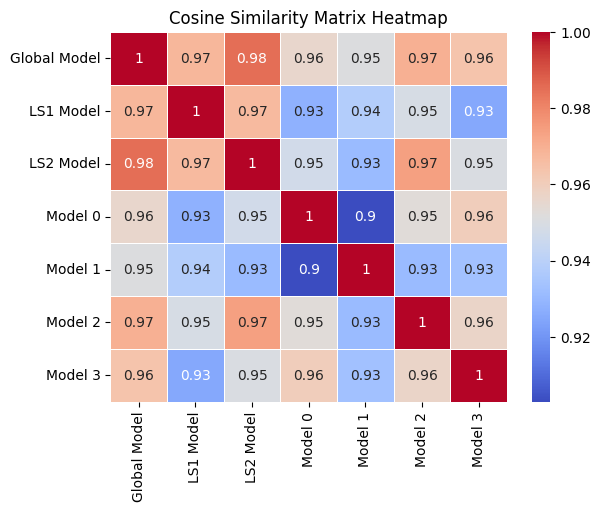

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Exemple de DataFrame pour la matrice de similarité cosinus
data = {
    'Global Model': [1.0, 0.968, 0.985, 0.956, 0.951, 0.970, 0.964],
    'LS1 Model': [0.968, 1.0, 0.967, 0.928, 0.938, 0.949, 0.925],
    'LS2 Model': [0.985, 0.967, 1.0, 0.947, 0.931, 0.974, 0.950],
    'Model 0': [0.956, 0.928, 0.947, 1.0, 0.903, 0.953, 0.960],
    'Model 1': [0.951, 0.938, 0.931, 0.903, 1.0, 0.931, 0.933],
    'Model 2': [0.970, 0.949, 0.974, 0.953, 0.931, 1.0, 0.957],
    'Model 3': [0.964, 0.925, 0.950, 0.960, 0.933, 0.957, 1.0],
}

cosine_similarity_df = pd.DataFrame(data, index=['Global Model', 'LS1 Model', 'LS2 Model', 'Model 0', 'Model 1', 'Model 2', 'Model 3'])

sns.heatmap(cosine_similarity_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Cosine Similarity Matrix Heatmap')
plt.show()


In [ ]:
# def data_preparation(series, version, n_steps_in, n_steps_out, train_size, val_size):
#     if len(series) == 0:
#         raise ValueError("The series is empty")

#     split_idx_train = int(train_size * len(series))
#     split_idx_val = int((train_size + val_size) * len(series))

#     train_series = series[:split_idx_train].values
#     val_series = series[split_idx_train:split_idx_val].values
#     test_series = series[split_idx_val:].values

#     X_train, y_train = [], []
#     X_val, y_val = [], []
#     X_test, y_test = [], []

#     for i in range(len(train_series_scaled) - n_steps_in - n_steps_out + 1):
#         X_train.append(train_series_scaled[i:i + n_steps_in])
#         y_train.append(train_series_scaled[i + n_steps_in:i + n_steps_in + n_steps_out])
#     for i in range(len(val_series_scaled) - n_steps_in - n_steps_out + 1):
#         X_val.append(val_series_scaled[i:i + n_steps_in])
#         y_val.append(val_series_scaled[i + n_steps_in:i + n_steps_in + n_steps_out])
#     for i in range(len(test_series_scaled) - n_steps_in - n_steps_out + 1):
#         X_test.append(test_series_scaled[i:i + n_steps_in])
#         y_test.append(test_series_scaled[i + n_steps_in:i + n_steps_in + n_steps_out])

#     X_train = np.array(X_train)
#     y_train = np.array(y_train)
#     X_val = np.array(X_val)
#     y_val = np.array(y_val)
#     X_test = np.array(X_test)
#     y_test = np.array(y_test)

#     y_train = y_train[:,:,0]
#     y_val = y_val[:,:,0]
#     y_test = y_test[:,:,0]

#     return X_train, y_train, X_val, y_val, X_test, y_test, train_series_scaled, val_series_scaled, test_series_scaled


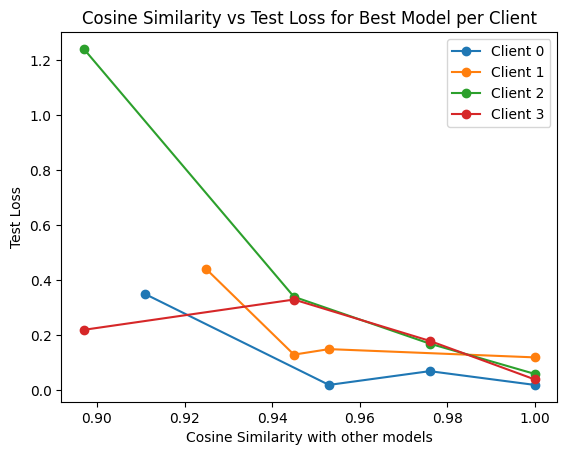

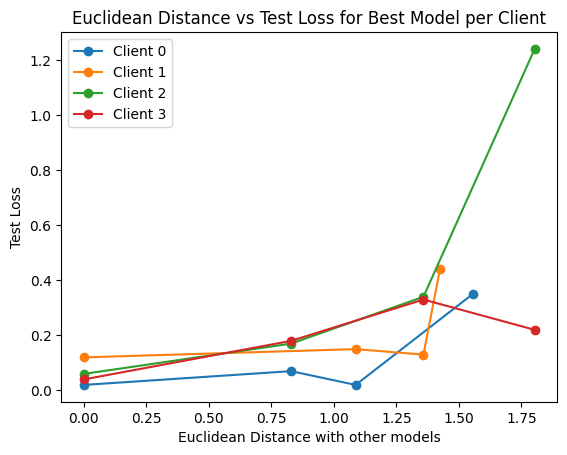

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Test loss values from the image (inferred from the table)
test_losses = {
    'Client 0': [0.02, 0.02, 0.07, 0.35],
    'Client 1': [0.15, 0.12, 0.13, 0.44],
    'Client 2': [0.17, 0.34, 0.06, 1.24],
    'Client 3': [0.18, 0.33, 0.04, 0.22]
}

# Cosine similarity matrix (inferred from the table)
cosine_similarity = np.array([
    [1.0, 0.953, 0.976, 0.911, 0.896, 0.918, 0.911],
    [0.953, 1.0, 0.945, 0.925, 0.898, 0.917, 0.893],
    [0.976, 0.945, 1.0, 0.897, 0.885, 0.912, 0.917],
    [0.911, 0.925, 0.897, 1.0, 0.957, 0.972, 0.922],
    [0.896, 0.897, 0.885, 0.957, 1.0, 0.952, 0.923],
    [0.918, 0.917, 0.912, 0.972, 0.952, 1.0, 0.949],
    [0.911, 0.893, 0.917, 0.922, 0.923, 0.949, 1.0]
])

# Euclidean distance matrix (inferred from the table)
euclidean_distance = np.array([
    [0.0, 1.087, 0.829, 1.555, 1.545, 1.513, 1.46],
    [1.087, 0.0, 1.358, 1.424, 1.462, 1.461, 1.488],
    [0.829, 1.358, 0.0, 1.803, 1.775, 1.739, 1.651],
    [1.555, 1.424, 1.803, 0.0, 0.451, 0.348, 0.537],
    [1.545, 1.462, 1.775, 0.451, 0.0, 0.478, 0.478],
    [1.513, 1.461, 1.739, 0.348, 0.478, 0.0, 0.478],
    [1.46, 1.488, 1.651, 0.537, 0.478, 0.478, 0.0]
])

# Model indices mapping (inferred from the table):
# 0: Global Model, 1: LS1 Model, 2: LS2 Model, 3: Local Model

model_names = ['Global Model', 'LS1 Model', 'LS2 Model', 'Local Model']

# Find the model with the lowest test loss for each client
best_models = {}
for client, losses in test_losses.items():
    best_model_idx = np.argmin(losses)
    best_models[client] = best_model_idx

    # Prepare data for plotting
cosine_similarity_data = []
euclidean_distance_data = []
test_loss_data = []

for client, best_model_idx in best_models.items():
    cosine_similarity_values = cosine_similarity[best_model_idx, :4]  # Select only the first 4 models (Global, LS1, LS2, Local)
    euclidean_distance_values = euclidean_distance[best_model_idx, :4]  # Select only the first 4 models (Global, LS1, LS2, Local)
    loss_value = test_losses[client]

    cosine_similarity_data.append(cosine_similarity_values)
    euclidean_distance_data.append(euclidean_distance_values)
    test_loss_data.append(loss_value)

# Plot Cosine Similarity vs Test Loss
for idx, (cos_sim_values, loss_value) in enumerate(zip(cosine_similarity_data, test_loss_data)):
    sorted_pairs = sorted(zip(cos_sim_values, loss_value))
    sorted_x, sorted_y = zip(*sorted_pairs)
    plt.plot(sorted_x, sorted_y, label=f'Client {idx}', marker='o')
plt.xlabel('Cosine Similarity with other models')
plt.ylabel('Test Loss')
plt.title('Cosine Similarity vs Test Loss for Best Model per Client')
plt.legend()
plt.show()

# Plot Euclidean Distance vs Test Loss
for idx, (euc_dist_values, loss_value) in enumerate(zip(euclidean_distance_data, test_loss_data)):
    sorted_pairs = sorted(zip(euc_dist_values, loss_value))
    sorted_x, sorted_y = zip(*sorted_pairs)
    plt.plot(sorted_x, sorted_y, label=f'Client {idx}', marker='o')
plt.xlabel('Euclidean Distance with other models')
plt.ylabel('Test Loss')
plt.title('Euclidean Distance vs Test Loss for Best Model per Client')
plt.legend()
plt.show()


In [ ]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
      for y_curr in y:
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
      plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

In [ ]:
series = np.array(df_client)
time = np.arange(len(series))

split_time = 2100

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

scaler = MinMaxScaler(feature_range=(0, 1))
x_train = scaler.fit_transform(x_train.reshape(-1, 1)).flatten()
x_valid = scaler.transform(x_valid.reshape(-1, 1)).flatten()

window_size = 100
batch_size = 32
shuffle_buffer_size = 100
prediction_steps = 400

def windowed_dataset(series, window_size, batch_size, shuffle_buffer, prediction_steps):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + prediction_steps, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + prediction_steps))
    dataset = dataset.map(lambda window: (window[:window_size], window[window_size:]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size, prediction_steps)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size, prediction_steps)

for x, y in train_set.take(1):
    print(f"Input batch shape: {x.shape}")
    print(f"Output batch shape: {y.shape}")


for x, y in train_set.take(1):
    print(f"Input batch shape: {x.shape}")
    print(f"Output batch shape: {y.shape}")


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(prediction_steps)
])

init_weights = model.get_weights()

model.summary()



Input batch shape: (32, 100)
Output batch shape: (32, 400)
Input batch shape: (32, 100)
Output batch shape: (32, 400)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 100, 64)           256       
                                                                 
 lstm_2 (LSTM)               (None, 100, 128)          98816     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 400)               51600     
  

Epoch 1/10
51/51 [==============================] - 8s 33ms/step - loss: 0.2291 - mae: 0.6659
Epoch 2/10
51/51 [==============================] - 1s 25ms/step - loss: 0.0112 - mae: 0.0978
Epoch 3/10
51/51 [==============================] - 1s 23ms/step - loss: 0.0033 - mae: 0.0654
Epoch 4/10
51/51 [==============================] - 1s 23ms/step - loss: 0.0034 - mae: 0.0661
Epoch 5/10
51/51 [==============================] - 2s 36ms/step - loss: 0.0034 - mae: 0.0665
Epoch 6/10
51/51 [==============================] - 1s 26ms/step - loss: 0.0034 - mae: 0.0661
Epoch 7/10
51/51 [==============================] - 1s 24ms/step - loss: 0.0034 - mae: 0.0657
Epoch 8/10
51/51 [==============================] - 1s 24ms/step - loss: 0.0033 - mae: 0.0659
Epoch 9/10
51/51 [==============================] - 1s 24ms/step - loss: 0.0034 - mae: 0.0657
Epoch 10/10
51/51 [==============================] - 1s 24ms/step - loss: 0.0033 - mae: 0.0655


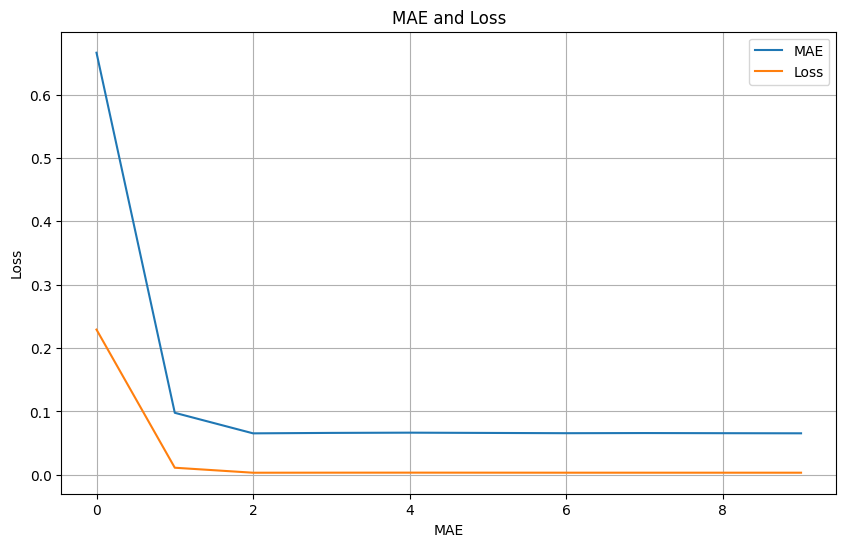

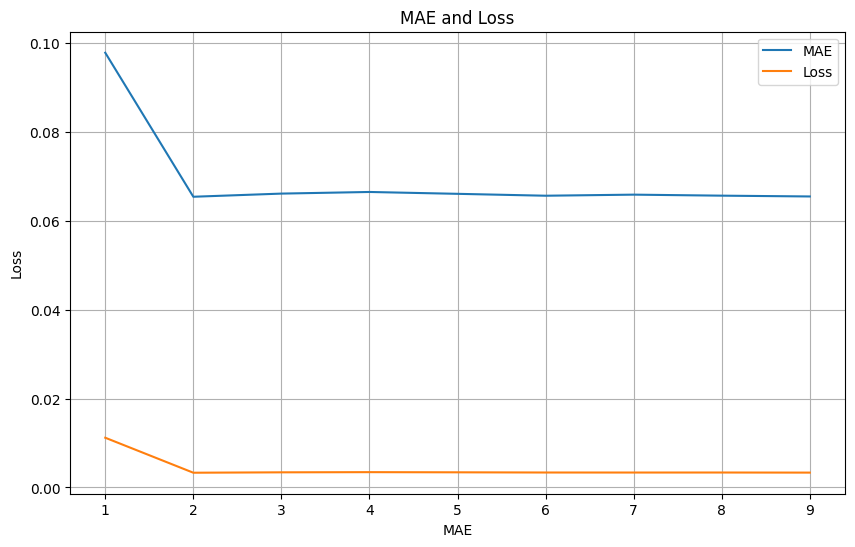

In [ ]:
tf.keras.backend.clear_session()

model.set_weights(init_weights)

learning_rate = 8e-2

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=10)

mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss))

plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

1/1 [==============================] - 0s 44ms/step


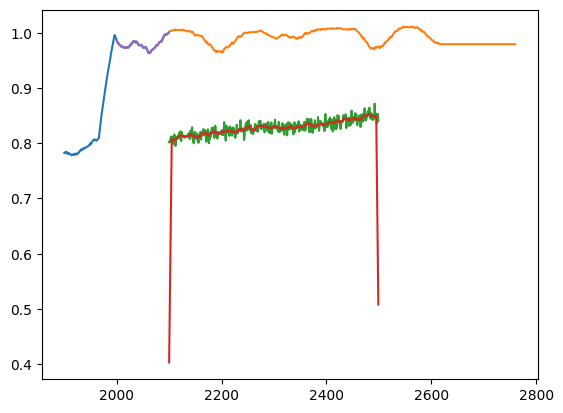

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

forecast_series = x_train[split_time-window_size:split_time]
#forecast_series = [2]*window_size
'''np.random.seed(112)
forecast_series = np.random.rand(window_size)
forecast_series = forecast_series.tolist()
'''
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axes
results = forecast.squeeze()
window_avg = 10
window = np.ones(window_avg) / window_avg
results_avg = np.convolve(results, window, mode='same')

# Plot the results

plt.plot(time_train[1900:],x_train[1900:])
plt.plot(time_valid, x_valid)
plt.plot(np.arange(split_time, split_time+prediction_steps), results)
plt.plot(np.arange(split_time, split_time+prediction_steps), results_avg)
plt.plot(time_train[split_time-window_size:split_time],forecast_series)

Epoch 1/100
51/51 [==============================] - 4s 23ms/step - loss: 0.2743 - lr: 1.0000e-04
Epoch 2/100
51/51 [==============================] - 1s 23ms/step - loss: 0.2741 - lr: 1.1220e-04
Epoch 3/100
51/51 [==============================] - 1s 23ms/step - loss: 0.2740 - lr: 1.2589e-04
Epoch 4/100
51/51 [==============================] - 1s 24ms/step - loss: 0.2738 - lr: 1.4125e-04
Epoch 5/100
51/51 [==============================] - 2s 33ms/step - loss: 0.2736 - lr: 1.5849e-04
Epoch 6/100
51/51 [==============================] - 1s 23ms/step - loss: 0.2734 - lr: 1.7783e-04
Epoch 7/100
51/51 [==============================] - 1s 23ms/step - loss: 0.2732 - lr: 1.9953e-04
Epoch 8/100
51/51 [==============================] - 1s 23ms/step - loss: 0.2729 - lr: 2.2387e-04
Epoch 9/100
51/51 [==============================] - 1s 25ms/step - loss: 0.2727 - lr: 2.5119e-04
Epoch 10/100
51/51 [==============================] - 1s 24ms/step - loss: 0.2723 - lr: 2.8184e-04
Epoch 11/100
51/51 

(0.0001, 1.0, 0.0, 0.01)

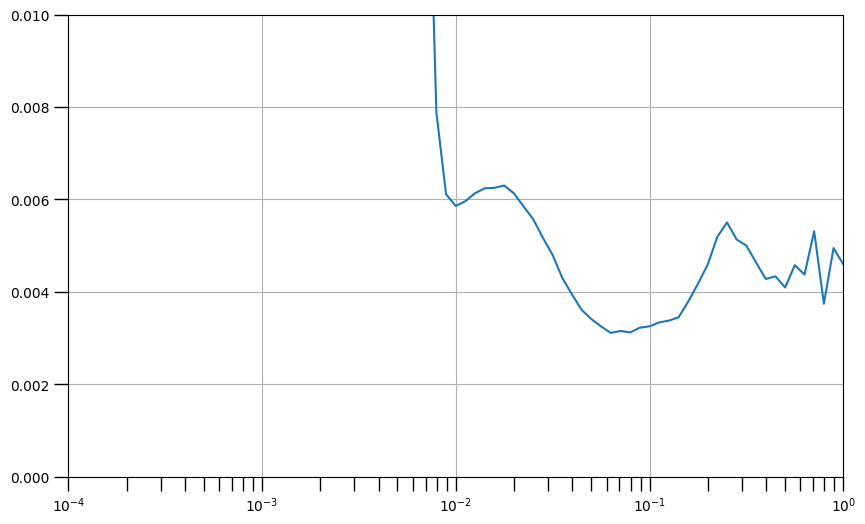

In [ ]:
#Find the best LEARNING_RATE

model.set_weights(init_weights)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

# Define the learning rate array
lrs = 1e-4 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))

plt.grid(True)

plt.semilogx(lrs, history.history["loss"])

plt.tick_params('both', length=10, width=1, which='both')

plt.axis([1e-4, 1, 0, 0.01])

##Pytorch and tests

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


def my_scorer(y_true, y_pred):
    return -mean_squared_error(y_true, y_pred)

custom_scorer = make_scorer(my_scorer, greater_is_better=False)
model = KerasRegressor(build_fn=build_lstm_model)

# Paramètres de la grille
param_grid = {
    'input_size': [INPUT_SIZE],
    'hidden_size': [50, 100, 150],
    'output_size': [OUTPUT_SIZE],
    'num_layers': [1, 2, 3],
    'version': ['short', 'long'],
    'prediction_steps': [PREDICTION_STEPS],
    'epochs': [10, 20],
    'batch_size': [32, 64]
}

# GridSearchCV avec custom scorer
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=custom_scorer, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [ ]:
from sklearn.preprocessing import StandardScaler

NUM_CLIENTS = 3
BATCH_SIZE = 32
SEQUENCE_LENGTH = 400
# give 10 input and get 4-10 outputs
# changing number of feqtures
def data_preparation(series, sequence_length=SEQUENCE_LENGTH, train_size=0.8):
    if series.empty:
        raise ValueError("The series is empty")
    split_idx = int(train_size * len(series))
    train_series = series[:split_idx]
    test_series = series[split_idx:]
    #scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = StandardScaler()
    train_series_scaled = scaler.fit_transform(train_series.values.reshape(-1, 1))
    test_series_scaled = scaler.transform(test_series.values.reshape(-1, 1))
    X_train, y_train = [], []
    X_test, y_test = [], []
    for i in range(len(train_series_scaled) - sequence_length):
        X_train.append(train_series_scaled[i:i + sequence_length])
        y_train.append(train_series_scaled[i + sequence_length])

    X_train = np.array(X_train)
    y_train = np.array(y_train)


    for i in range(len(test_series_scaled) - sequence_length):
        X_test.append(test_series_scaled[i:i + sequence_length])
        y_test.append(test_series_scaled[i + sequence_length])
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, y_train, X_test, y_test


def create_dataloaders(client_data, batch_size=BATCH_SIZE, sequence_length=SEQUENCE_LENGTH):
    trainloaders = []
    valloaders = []
    for client_id, series in client_data.items():
        X_train, y_train, X_val, y_val = data_preparation(series, sequence_length)
        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
        trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        trainloaders.append(trainloader)
        valloaders.append(valloader)
    return trainloaders, valloaders

'''client_data = {
    0: df_N1OZ['Soil Hum (N1 - OZ)'],
    1: df_N2OZ['Soil Hum (N2 - OZ)'],
    2: df_N0OZ['Soil Hum (N0 - OZ)']
}
client_data = {
    2: df_N0OZ['Soil Hum (N0 - OZ)']
}'''
'''client_data = {
    0: df_N1OZ['Moving Average'],
    1: df_N2OZ['Moving Average'],
    2: df_N0OZ['Moving Average']
}'''


trainloaders, valloaders = create_dataloaders(client_data)

for i, trainloader in enumerate(trainloaders):
    print(f"Client {i} - Number of training batches: {len(trainloader)}")
    for inputs, labels in trainloader:
      print("Forme des entrées (inputs):", inputs.shape)
      print("Forme des labels:", labels.shape)
      break

for i, valloader in enumerate(valloaders):
    print(f"Client {i} - Number of test batches: {len(valloader)}")



Client 0 - Number of training batches: 55
Forme des entrées (inputs): torch.Size([32, 400, 1])
Forme des labels: torch.Size([32, 1])
Client 0 - Number of test batches: 5


In [ ]:
#PYTORCH

INPUT_SIZE = 1
HIDDEN_SIZE = 20
NUM_LAYERS = 7
OUTPUT_SIZE = 1
LEARNING_RATE = 0.01

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
        #return out.view(out.size(0), -1)

max_grad_norm = 50.0

def train_LSM(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    epoch_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_samples = 0
        i = 0
        for inputs, targets in train_loader:
            inputs = inputs.view(-1, SEQUENCE_LENGTH, 1).to(DEVICE)
            #targets = targets.view(-1, OUTPUT_LENGTH).to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            if i== -1 :
              print(f"Batch number {i}")
              #print(f"Ready inputs : {inputs[0]} ")
              print(f"Raw outputs : {outputs[0]} ")
              print(f"Raw targets : {targets[0]} ")
            loss = criterion(outputs, targets)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

            running_loss += loss.item() * targets.size(0)
            total_samples += targets.size(0)
            i = 1

        epoch_loss = running_loss / total_samples if total_samples > 0 else float('inf')
        epoch_losses.append(epoch_loss)

        if (epoch) % 2 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return model, epoch_losses


def test(net, test_loader, criterion):
    net.eval()
    total_loss = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.view(-1, SEQUENCE_LENGTH, 1)
            #targets = targets.view(-1, OUTPUT_LENGTH).to(DEVICE)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * targets.size(0)
            total += targets.size(0)
    avg_loss = total_loss / total if total > 0 else float('inf')
    print(f'Test Loss: {avg_loss:.4f}')
    return avg_loss, None


def get_parameters(model):
    return [param.data.cpu().numpy() for param in model.parameters()]


def set_parameters(model, parameters):
    for param, new_param in zip(model.parameters(), parameters):
        param.data = torch.tensor(new_param).to(param.device)


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Dict[str, Scalar]:
    num_samples_list = [num_samples for num_samples, _ in metrics]
    num_samples_sum = sum(num_samples_list)
    weighted_metrics: Dict[str, List[float]] = {}

    for num_samples, metrics_dict in metrics:
        for metric, value in metrics_dict.items():
            if metric not in weighted_metrics:
                weighted_metrics[metric] = []
            weighted_metrics[metric].append(value * num_samples)

    return {metric: sum(values) / num_samples_sum for metric, values in weighted_metrics.items()}


Client 0 selected. Train samples: 1741, Test samples: 136
Client 0 - Number of training batches: 55
Client 0 - Number of test batches: 5
Epoch [0/25], Loss: 0.9003
Epoch [2/25], Loss: 0.7711
Epoch [4/25], Loss: 0.7664
Epoch [6/25], Loss: 0.7651
Epoch [8/25], Loss: 0.7649


KeyboardInterrupt: 

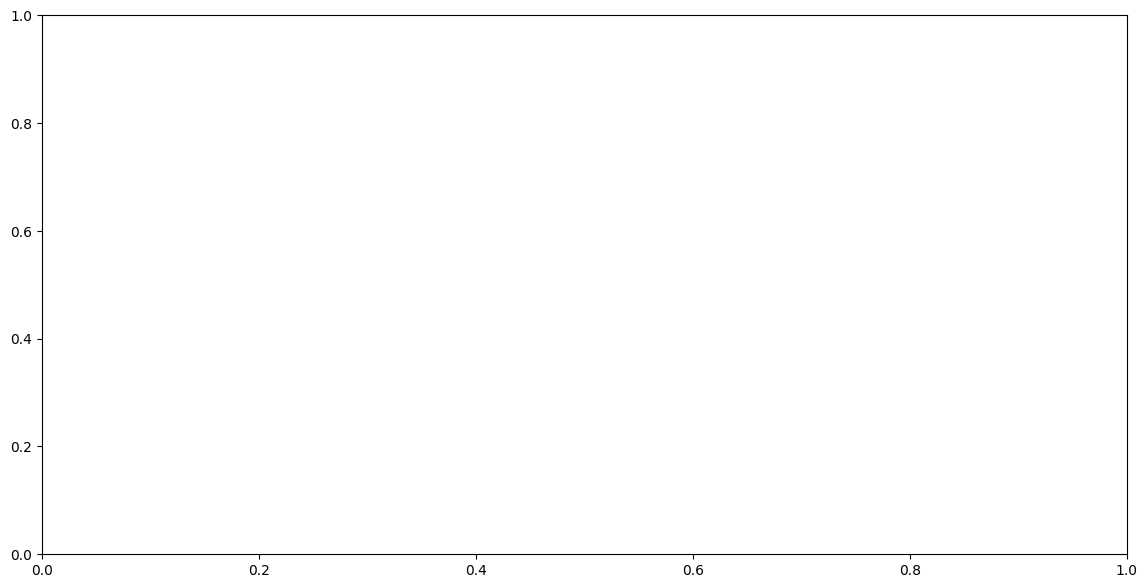

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

NUM_EPOCHS = 25
metrics = []
FUTURE_PERIOD = 200

num_clients = len(client_data)
fig, axs = plt.subplots(num_clients, 1, figsize=(14, 7 * num_clients))

if num_clients == 1:
    axs = [axs]

for idx, client_id in enumerate(client_data.keys()):
    df_client = client_data[client_id]

    X_train, y_train, X_test, y_test = data_preparation(df_client, SEQUENCE_LENGTH)
    print(f"Client {client_id} selected. Train samples: {len(X_train)}, Test samples: {len(X_test)}")

    single_client_model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS).to(DEVICE)
    single_criterion = nn.MSELoss()
    single_optimizer = optim.Adam(single_client_model.parameters(), lr=LEARNING_RATE)

    single_train_loader = trainloaders[idx]
    single_test_loader = valloaders[idx]
    print(f"Client {idx} - Number of training batches: {len(single_train_loader)}")
    print(f"Client {idx} - Number of test batches: {len(single_test_loader)}")

    single_client_model, epoch_losses = train_LSM(single_client_model, single_train_loader, single_criterion, single_optimizer, NUM_EPOCHS)

    single_client_model.eval()
    train_predictions = []
    test_predictions = []
    future_predictions = []

    with torch.no_grad():
        for i in range(len(X_train)):
            input_seq = torch.tensor(X_train[i], dtype=torch.float32).unsqueeze(0).to(DEVICE)
            output = single_client_model(input_seq)
            output_np = output.cpu().numpy()
            if i % 30000 == 0:
                print(f"Input {i}: {input_seq}")
                print(f"Output shape for input {i}: {output.shape}")
                print(f"Output for input {i}: {output_np}")
            train_predictions.append(output_np)

    with torch.no_grad():
        last_input_seq = torch.tensor(X_train[-1], dtype=torch.float32).unsqueeze(0).to(DEVICE)
        for i in range(len(X_test)):
            future_output = single_client_model(last_input_seq)
            test_predictions.append(future_output.cpu().numpy())
            last_input_seq = torch.cat((last_input_seq[:, 1:, :], future_output.unsqueeze(0)), dim=1)

    with torch.no_grad():
        for i in range(FUTURE_PERIOD):
            future_output = single_client_model(last_input_seq)
            future_predictions.append(future_output.cpu().numpy())
            last_input_seq = torch.cat((last_input_seq[:, 1:, :], future_output.unsqueeze(0)), dim=1)

    train_predictions = np.array(train_predictions).flatten()
    test_predictions = np.array(test_predictions).flatten()
    future_predictions = np.array(future_predictions).flatten()

    mae_train = mean_absolute_error(y_train, train_predictions)
    mse_train = mean_squared_error(y_train, train_predictions)
    rmse_train = np.sqrt(mse_train)

    plt.plot(np.arange(len(y_train)), y_train, label='Actual Training Values')
    plt.plot(np.arange(len(y_train)), train_predictions, label='Training Predictions')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual Test Values')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), test_predictions, label='Test Predictions')
    plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + FUTURE_PERIOD), future_predictions, label='Future Predictions')

    plt.axvline(x=len(y_train), color='r', linestyle='--', label='Train/Test Split')
    plt.axvline(x=len(y_train) + len(y_test), color='g', linestyle='--', label='Future Predictions Start')

    plt.legend()
    plt.title(f"Predictions\nMAE: {mae_train:.4f}, MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}")
    plt.tight_layout()
    plt.show()

    mae_test = mean_absolute_error(y_test, test_predictions)
    mse_test = mean_squared_error(y_test, test_predictions)
    rmse_test = np.sqrt(mse_test)

    final_loss = epoch_losses[-1]
    num_samples = len(single_train_loader.dataset) + len(single_test_loader.dataset)
    metrics.append((num_samples, {"loss": final_loss, "mae": mae_test, "mse": mse_test, "rmse": rmse_test}))

final_metrics = weighted_average(metrics)
print(f"Final average loss across all clients FOR TRAINING DATA: {final_metrics['loss']:.6f}")
print(f"Final average MAE across all clients: {final_metrics['mae']:.6f}")
print(f"Final average MSE across all clients: {final_metrics['mse']:.6f}")
print(f"Final average RMSE across all clients: {final_metrics['rmse']:.6f}")


In [ ]:
from flwr.common import (
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetParametersIns,
    GetParametersRes,
    Status,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)

class FlowerClient(fl.client.Client):
    def __init__(self, net, trainloader, valloader, criterion, optimizer):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.criterion = criterion
        self.optimizer = optimizer

    def get_parameters(self, config) -> List[np.ndarray]:
        ndarrays: List[np.ndarray] = [val.cpu().numpy() for val in self.net.state_dict().values()]
        return ndarrays

    def set_parameters(self, parameters: List[np.ndarray]) -> None:
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = {k: torch.tensor(v) for k, v in params_dict}
        self.net.load_state_dict(state_dict, strict=True)

    def fit(self, ins: FitIns) -> FitRes:
        parameters_original = ins.parameters
        config = ins.config
        ndarrays_original = parameters_to_ndarrays(parameters_original)
        self.set_parameters(ndarrays_original)

        local_epochs = int(config["local_epochs"])
        server_round = config["server_round"]
        self.train(self.trainloader, self.criterion, self.optimizer, num_epochs=local_epochs)

        ndarrays_updated = self.get_parameters()
        parameters_updated = ndarrays_to_parameters(ndarrays_updated)

        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=parameters_updated,
            num_examples=len(self.trainloader.dataset),
            metrics={},
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        parameters_original = ins.parameters
        config = ins.config
        ndarrays_original = parameters_to_ndarrays(parameters_original)
        self.set_parameters(ndarrays_original)

        loss, accuracy = self.test(self.valloader, self.criterion)

        status = Status(code=Code.OK, message="Success")
        return EvaluateRes(
            status=status,
            loss=float(loss),
            num_examples=len(self.valloader.dataset),
            metrics={"accuracy": float(accuracy)},
        )

    def train(self, trainloader, criterion, optimizer, num_epochs=5):
        return train(self.net, trainloader, criterion, optimizer, num_epochs)

    def test(self, valloader, criterion):
        return test(self.net, valloader, criterion)




In [ ]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def client_fn(cid: str) -> FlowerClient:

    model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS).to(DEVICE)

    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    return FlowerClient(model, trainloader, valloader, criterion, optimizer).to_client()


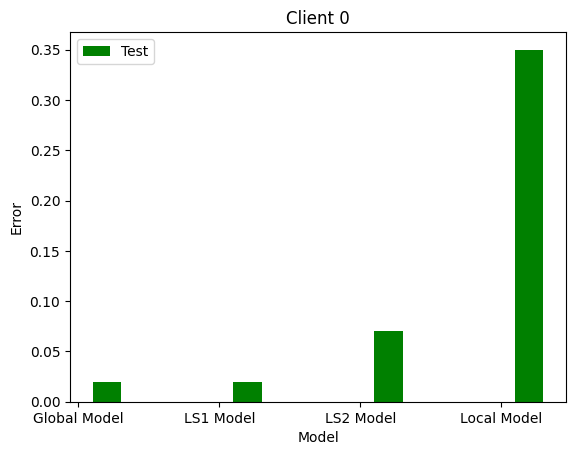

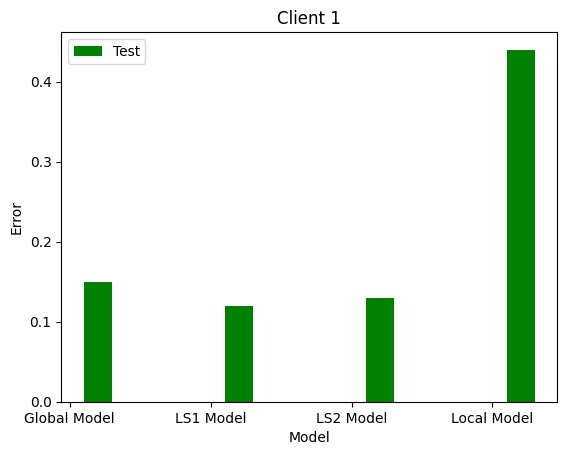

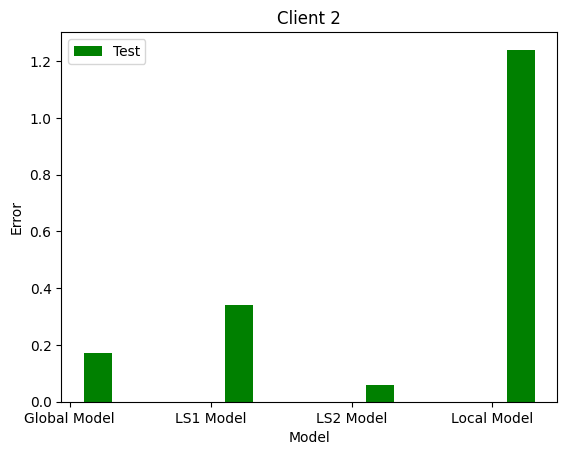

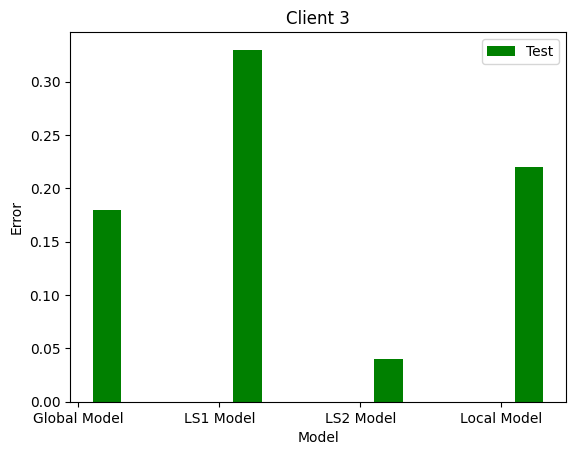

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Données extraites de l'image fournie
data = {
    "Client 0": {
        "Global Model": (0.67, 0.05, 0.02),
        "LS1 Model": (2.34, 1.03, 0.02),
        "LS2 Model": (0.78, 0.02, 0.07),
        "Local Model": (3.03, 0.19, 0.35)
    },
    "Client 1": {
        "Global Model": (1.28, 0.03, 0.15),
        "LS1 Model": (4.34, 0.9, 0.12),
        "LS2 Model": (1.51, 0.04, 0.13),
        "Local Model": (7.03, 4.4, 0.44)
    },
    "Client 2": {
        "Global Model": (1.18, 0.23, 0.17),
        "LS1 Model": (3.22, 4.15, 0.34),
        "LS2 Model": (1.27, 0.4, 0.06),
        "Local Model": (1.53, 1.71, 1.24)
    },
    "Client 3": {
        "Global Model": (0.38, 0.22, 0.18),
        "LS1 Model": (5.96, 0.92, 0.33),
        "LS2 Model": (0.29, 0.03, 0.04),
        "Local Model": (1.69, 0.2, 0.22)
    }
}
#data = error_matrix
# Création des graphiques pour chaque client
for client, values in data.items():
    models = list(values.keys())
    train_values = [values[model][0] for model in models]
    val_values = [values[model][1] for model in models]
    test_values = [values[model][2] for model in models]

    x = np.arange(len(models))  # positions des labels
    width = 0.2  # largeur des barres

    fig, ax = plt.subplots()
    #ax.bar(x - width, train_values, width, label='Train')
    #ax.bar(x, val_values, width, label='Val')
    ax.bar(x + width, test_values, width, label='Test', color = 'green')

    ax.set_xlabel('Model')
    ax.set_ylabel('Error')
    ax.set_title(f'{client}')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()

    plt.show()
